<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/AirLiquide/AirLiquide_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AIFREUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-27 13:00:34,411 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-27 13:00:34,413 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AIFREUR
2019-08-27 13:03:39,329 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-27 13:10:16,757 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-27 13:13:33,656 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-27 13:16:56,024 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-27 13:20:20,868 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-27 13:23:47,145 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-27 13:27:05,644 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-27 13:30:33,662 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-3

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-27 13:40:13,372 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_439__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AIFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AIFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AIFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  1.04998  1.05098  1.03797  1.04247  3.749024
2018-01-02 09:00:00  1.04288  1.04648  1.03897  1.04048  3.043659
2018-01-02 10:00:00  1.04047  1.04548  1.04047  1.04197  1.867866
2018-01-02 11:00:00  1.04248  1.04548  1.04197  1.04297  1.682944
2018-01-02 12:00:00  1.04297  1.04598  1.04247  1.04548  1.778887
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  1.06860  1.07548  1.06860  1.07098  1.729022
2018-12-31 09:00:00  1.07087  1.07298  1.06847  1.07298  1.284485
2018-12-31 10:00:00  1.07298  1.07798  1.07247  1.07697  1.126881
2018-12-31 11:00:00  1.07698  1.07698  1.07347  1.07398  0.945896
2018-12-31 12:00:00  1.07397  1.08398  1.07347  1.08397  1.866543

[2275 rows x 5 columns]

Open         High          Low        Close       Volume
count  2275.000000  2275.000000  2275.000000  2275.000000  2275.000000
mean      1.064897     1.067350     1.062410     1.064886     2.570276
std       0.034460     0.034328     0.034589     0.034554     1.959433
min       0.973380     0.975770     0.971470     0.973370     0.006624
25%       1.046480     1.049480     1.043920     1.046470     1.469962
50%       1.069970     1.072480     1.067470     1.069980     2.053412
75%       1.087725     1.089970     1.085470     1.087970     3.022347
max       1.150470     1.151980     1.147970     1.150480    21.550400

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  1.09597  1.09698  1.09447  1.09554  1.753845    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  1.095713  1.083281  1.088668  1.096830  1.095761  1.095284    1.096730    1.095175  1.090941  1.096488  1.095382  1.096383  1.096104  1.096488  1.095667  1.092177                1.098409                 1.096488                1.094566                1.099370                 1.096488                1.093606                1.100330                 1.096488                1.092645                1.101291                 1.096488                1.091684  1.095761  1.095786  1.093258                1.097683                 1.095761                1.093840                1.098643                 1.095761                1.092879                1.099604                 1.095761                1.091919                1.100565                 1.095761   
2018-01-09 14:00:00  1.09548  1.09658  1.09487  1.09647  6.132004    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  1.096092  1.086483  1.089257  1.096872  1.095919  1.095335    1.096730    1.095175  1.091544  1.096299  1.095656  1.096161  1.096101  1.096299  1.096005  1.092797                1.097859                 1.096299                1.094738                1.098640                 1.096299                1.093958                1.099420                 1.096299                1.093178                1.100200                 1.096299                1.092397  1.095919  1.096206  1.093774                1.097479                 1.095919                1.094358                1.098260                 1.095919                1.093578                1.099040                 1.095919                1.092798                1.099820                 1.095919   
2018-01-09 15:00:00  1.09647  1.09948  1.09547  1.09898 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000    2225.000000  2225.000000   2225.000000     2225.000000     2225.000000       2225.000000  2225.000000  2225.000000  2225.000000  2225.000000   2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000  2225.000000  2225.000000  2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000   
mean      1.064764     1.067214     1.062256     1.064737     2.586472    15.997753     2.019326   185.444045      30.423371    11.378427      0.034157        0.023820        0.002247          0.004045     6.597753     2.533483    26.943820     2.019326      2.005843    26.943820     1.064761     1.064708     0.041138     1.064729     1.064772     1.064255     1.064681     1.064599     1.064436     1.064769     1.064729     1.064767     1.064756     1.064769     1.064748     1.064858                1.072407                 1.064769                1.057130                1.076227                 1.064769                1.053311                1.080046                 1.064769                1.049492                1.083865                 1.064769                1.045673     1.064772     1.064742     1.064846                1.072410                 1.064772                1.057133                1.076229                 1.064772                1.053314                1.080049   
std       0.034705     0.034575     0.034828     0.034794     1.976061     8.580055     1.412650   101.900637       0.854312     2.620424      0.181674        0.152523        0.047362          0.063485     3.353096     1.102596    14.557378     1.412650      1.403830    14.557378     0.034460     0.033694     1.064414     0.034874     0.034412     0.034187     0.034562     0.034385     0.035176     0.034532     0.034830     0.034589     0.034567     0.034532     0.034721     0.034116                0.034363                 0.034532                0.035257                0.034490                 0.034532                0.035819                0.034757                 0.034532                0.036505                0.035161                 0.034532                0.037309     0.034412     0.034683     0.034180                0.034251                 0.034412                0.035130                0.034384                 0.034412                0.035689                0.034656   
min       0.973380     0.975770     0.9714

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.692247  0.687872  0.696884  0.689797  0.081101    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.686334  0.620159  0.976333  0.696165  0.692476  0.692985    0.702349    0.695899  0.661854  0.698373  0.689453  0.697661  0.693676  0.698373  0.689902  0.676783                0.660313                 0.698373                0.736746                0.636312                 0.698373                0.758672                0.613202                 0.698373                0.778416                0.592030                 0.698373                0.796456  0.692476  0.691221  0.682927                0.663999                 0.692476                0.726157                0.639362                 0.692476                0.748941                0.617878                 0.692476                0.769782                0.596713                 0.692476   
2018-01-09 14:00:00  0.689480  0.685602  0.699150  0.695048  0.284322    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.688578  0.640767  0.976590  0.696408  0.693415  0.693293    0.702349    0.695899  0.665195  0.697260  0.691003  0.696364  0.693653  0.697260  0.691825  0.680708                0.657142                 0.697260                0.737689                0.632180                 0.697260                0.760502                0.608143                 0.697260                0.781045                0.586127                 0.697260                0.799806  0.693415  0.693622  0.686168                0.662789                 0.693415                0.729088                0.637124                 0.693415                0.752684                0.614683                 0.693415                0.774251                0.592618                 0.693415   
2018-01-09 15:00:00  0.695070  0.702060  

140086

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpfue25mzr
  JVM stdout: /tmp/tmpfue25mzr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpfue25mzr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_1t03yt
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_135004_mod...  0.568079  0.691085              0.481308  0.498970  0.248971
1  DeepLearning_grid_1_AutoML_20190827_135004_mod...  0.560345  0.691770              0.434177  0.499311  0.249311
2  DeepLearning_grid_1_AutoML_20190827_135004_mod...  0.559781  1.004315              0.480946  0.595030  0.354061
3  DeepLearning_grid_1_AutoML_20190827_135004_mod...  0.556880  3.638634              0.480221  0.646464  0.417916
4  DeepLearning_grid_1_AutoML_20190827_135004_mod...  0.538189  0.753203              0.500000  0.522829  0.273350
5  DeepLearning_grid_1_AutoML_20190827_135004_mod...  0.523526  1.174022              0.500000  0.593538  0.352287
6  DeepLearning_grid_1_AutoML_20190827_135004_mod...  0.505438  0.699337              0.495327  0.502814  0.252822
7              DeepLearning_1_AutoML_20190827_135004  0.480744  1.122976              0.500000  0.604068  0.364898
8  DeepLearning_grid_1_AutoML_20190827_135004_mod...  0.466967  0.705407              0.500000  0.505898  0.255933
9  DeepLearning_grid_1_AutoML_20190827_135004_mod...  0.463503  0.728179              0.500000  0.514910  0.265133

variable  relative_importance  scaled_importance  percentage
0                     CORREL_8             1.000000           1.000000    0.001217
1                        DX_20             0.997952           0.997952    0.001214
2                          BOP             0.995371           0.995371    0.001211
3         HT_PHASOR_quadrature             0.990777           0.990777    0.001205
4               STOCHRSI_fastd             0.989357           0.989357    0.001204
...                        ...                  ...                ...         ...
1033  BBANDS_middleband_12_3_4             0.697867           0.697867    0.000849
1034  BBANDS_middleband_12_6_4             0.688414           0.688414    0.000838
1035                      SINH             0.684107           0.684107    0.000832
1036             MINMAX_max_20             0.683177           0.683177    0.000831
1037            CDL3LINESTRIKE             0.682860           0.682860    0.000831

[1038 rows x 4 columns]

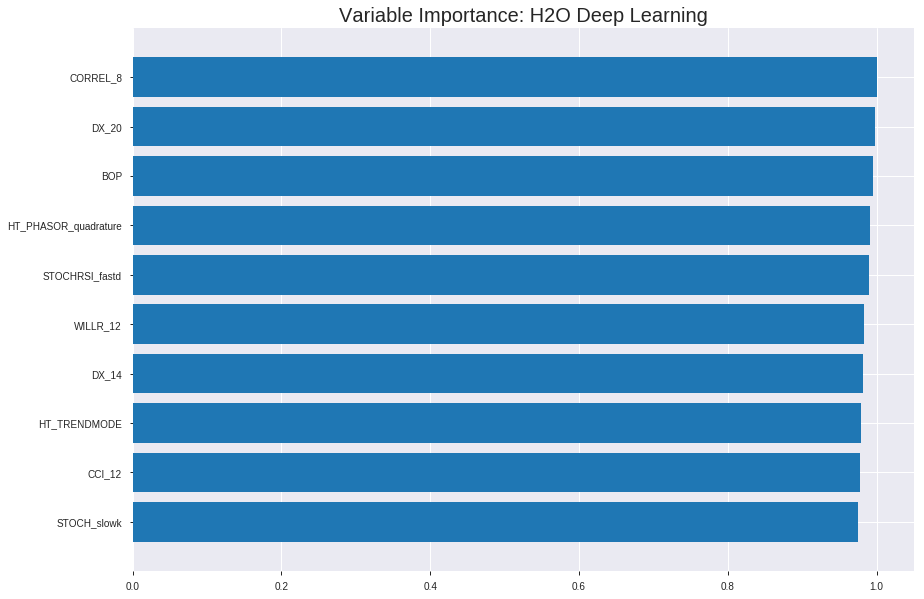

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_135004_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24873326379841307
RMSE: 0.49873165509962675
LogLoss: 0.6906094531238209
Mean Per-Class Error: 0.46637648214968164
AUC: 0.5329898766302199
pr_auc: 0.544357443992166
Gini: 0.06597975326043981
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4409048899023703: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    744   0.9933   (744.0/749.0)
1      2    805   0.0025   (2.0/807.0)
Total  7    1549  0.4794   (746.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.440905     0.683362   394
max f2                       0.436102     0.843436   399
max f0point5                 0.458591     0.578994   360
max accuracy                 0.496619     0.542416   241
max precision                0.541674     0.714286   8
max recall                   0.436102     1          399
max specificity              0.544022     0.998665   0
max absolute_mcc             0.496619     0.0763321  241
max min_per_class_accuracy   0.512934     0.511772   159
max mean_per_class_accuracy  0.496619     0.533624   241

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 50.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102828                   0.542762           1.08457   1.08457            0.5625           0.543269  0.5625                      0.543269            0.0111524       0.0111524                  8.45725    8.45725
    2        0.0205656                   0.541346           1.5666    1.32559            0.8125           0.541982  0.6875                      0.542626            0.016109        0.0272615                  56.6605    32.5589
    3        0.0302057                   0.540681           1.02834   1.23072            0.533333         0.541034  0.638298                    0.542118            0.00991326      0.0371747                  2.83354    23.0721
    4        0.0404884                   0.539838           1.08457   1.1936             0.5625           0.540243  0.619048                    0.541642            0.0111524       0.0483271                  8.45725    19.3604
    5        0.0501285                   0.539001           0.771252  1.11238            0.4              0.539458  0.576923                    0.541222            0.00743494      0.0557621                  -22.8748   11.2382
    6        0.100257                    0.53356            1.11238   1.11238            0.576923         0.536287  0.576923                    0.538754            0.0557621       0.111524                   11.2382    11.2382
    7        0.150386                    0.530504           0.914625  1.04646            0.474359         0.531896  0.542735                    0.536468            0.0458488       0.157373                   -8.53748   4.64631
    8        0.200514                    0.527732           1.11238   1.06294            0.576923         0.528945  0.551282                    0.534587            0.0557621       0.213135                   11.2382    6.29428
    9        0.300129                    0.523758           0.995163  1.04045            0.516129         0.525636  0.539615                    0.531616            0.0991326       0.312268                   -0.483671  4.04464
    10       0.400386                    0.518392           1.02586   1.03679            0.532051         0.521114  0.537721                    0.528987            0.10285         0.415118                   2.58634    3.67948
    11       0.5                         0.512734           0.970284  1.02354            0.503226         0.515456  0.530848                    0.526291            0.0966543       0.511772                   -2.97158   2.3544
    12       0.600257                    0.506501           1.17418   1.0487             0.608974         0.509511  0.543897                    0.523488            0.11772         0.629492                   17.4181    4.87039
    13       0.699871                    0.499563           0.945405  1.034              0.490323         0.503375  0.536272                    0.520626            0.094176        0.723668                   -5.45949   3.40012
    14       0.800129                    0.489899           0.976424  1.02679            0.50641          0.495318  0.53253                     0.517455            0.0978934       0.821561                   -2.35758   2.67867
    15       0.899743                    0.478988           0.920526  1.01502            0.477419         0.484813  0.526429                    0.513841            0.0916976       0.913259                   -7.9474    1.50221
    16       1                           0.436102           0.865186  1                  0.448718         0.462214  0.518638                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24950235470744464
RMSE: 0.4995021068098158
LogLoss: 0.6921533940014738
Mean Per-Class Error: 0.4467923841862722
AUC: 0.5480434958363651
pr_auc: 0.5658811731855717
Gini: 0.09608699167273027
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41307134886155816: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    209  0.9631   (209.0/217.0)
1      3    225  0.0132   (3.0/228.0)
Total  11   434  0.4764   (212.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.413071     0.679758  388
max f2                       0.405821     0.840088  399
max f0point5                 0.420931     0.574324  378
max accuracy                 0.524466     0.552809  191
max precision                0.543589     1         0
max recall                   0.405821     1         399
max specificity              0.543589     1         0
max absolute_mcc             0.541582     0.117584  9
max min_per_class_accuracy   0.524567     0.548387  190
max mean_per_class_accuracy  0.529789     0.553208  114

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 50.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.542519           1.95175   1.95175            1                0.543253  1                           0.543253            0.0219298       0.0219298                  95.1754   95.1754
    2        0.0202247                   0.541594           1.46382   1.73489            0.75             0.541984  0.888889                    0.542689            0.0131579       0.0350877                  46.3816   73.4893
    3        0.0314607                   0.540583           0.780702  1.39411            0.4              0.541073  0.714286                    0.542112            0.00877193      0.0438596                  -21.9298  39.411
    4        0.0404494                   0.539031           1.46382   1.4096             0.75             0.539532  0.722222                    0.541538            0.0131579       0.0570175                  46.3816   40.96
    5        0.0516854                   0.538551           0.780702  1.27288            0.4              0.538727  0.652174                    0.540927            0.00877193      0.0657895                  -21.9298  27.2883
    6        0.101124                    0.536489           0.798445  1.04094            0.409091         0.537503  0.533333                    0.539253            0.0394737       0.105263                   -20.1555  4.09357
    7        0.150562                    0.535131           1.33074   1.1361             0.681818         0.535808  0.58209                     0.538122            0.0657895       0.171053                   33.0742   13.6096
    8        0.2                         0.532346           1.24203   1.16228            0.636364         0.53378   0.595506                    0.537049            0.0614035       0.232456                   24.2026   16.2281
    9        0.301124                    0.52979            1.17105   1.16523            0.6              0.531169  0.597015                    0.535074            0.118421        0.350877                   17.1053   16.5226
    10       0.4                         0.527329           0.842803  1.08553            0.431818         0.528535  0.55618                     0.533458            0.0833333       0.434211                   -15.7197  8.55263
    11       0.501124                    0.524652           1.12768   1.09403            0.577778         0.526175  0.560538                    0.531988            0.114035        0.548246                   12.768    9.40327
    12       0.6                         0.520618           0.754087  1.03801            0.386364         0.522949  0.531835                    0.530499            0.0745614       0.622807                   -24.5913  3.80117
    13       0.698876                    0.500463           0.931519  1.02295            0.477273         0.514678  0.524116                    0.52826             0.0921053       0.714912                   -6.84809  2.29452
    14       0.8                         0.459862           0.954191  1.01425            0.488889         0.482377  0.519663                    0.52246             0.0964912       0.811404                   -4.5809   1.42544
    15       0.898876                    0.434065           0.975877  1.01003            0.5              0.446616  0.5175                      0.514117            0.0964912       0.907895                   -2.41228  1.00329
    16       1                           0.405821           0.910819  1                  0.466667         0.419903  0.51236                     0.50459             


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:05:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:05:36  2 min 43.604 sec  277 obs/sec       0.284704  1             443        0.67946          2.23029             -0.849234      0.473288        0.481842           0.843556         0.481362                         0.619636           2.07024               -0.536734        0.475119          0.493471             0.780702           0.485393
    2019-08-27 14:06:01  3 min  9.099 sec  391 obs/sec       6.20758   21            9659       0.500375         0.693897            -0.00289365    0.505312        0.758488           1.00158          0.478792                         0.500272           0.69369               -0.00169853      0.502193          0.752319             0.997856           0.48764
    2019-08-27 14:06:25  3 min 33.456 sec  568 obs/sec       17.0219   58            26486      0.499653         0.692453            -8.26266e-07   0.5             0                  1                0.481362                         0.499881           0.69291               -0.00013575      0.5               0                    1                  0.48764
    2019-08-27 14:06:50  3 min 57.863 sec  674 obs/sec       29.7558   101           46300      0.498732         0.690609            0.00368263     0.53299         0.544357           1.08457          0.479434                         0.499502           0.692153              0.00138039       0.548043          0.565881             1.95175            0.476404
    2019-08-27 14:07:14  4 min 22.405 sec  771 obs/sec       44.9312   152           69913      0.507463         0.708317            -0.0315075     0.5             0                  1                0.481362                         0.506595           0.706546              -0.0271836       0.5               0                    1                  0.48764
    2019-08-27 14:07:39  4 min 47.405 sec  890 obs/sec       64.7371   219           100731     0.499809         0.692765            -0.000625921   0.5             0                  1                0.481362                         0.499886           0.692919              -0.000154974     0.5               0                    1                  0.48764
    2019-08-27 14:08:04  5 min 12.423 sec  974 obs/sec       85.0411   288           132324     0.501822         0.696803            -0.00870444    0.5             0                  1                0.481362                         0.501472           0.6961                -0.00651273      0.5               0                    1                  0.48764
    2019-08-27 14:08:07  5 min 14.934 sec  974 obs/sec       85.0411   288           132324     0.498732         0.690609            0.00368263     0.53299         0.544357           1.08457          0.479434                         0.499502           0.692153              0.00138039       0.548043          0.565881             1.95175            0.476404

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CORREL_8                  1.0                    1.0                  0.0012166394914405248
DX_20                     0.9979521632194519     0.9979521632194519   0.0012141480123412857
BOP                       0.995370626449585      0.995370626449585    0.0012110072127584598
HT_PHASOR_quadrature      0.9907770156860352     0.9907770156860352   0.0012054184444952188
STOCHRSI_fastd            0.9893574714660645     0.9893574714660645   0.0012036913709373561
---                       ---                    ---                  ---
BBANDS_middleband_12_3_4  0.6978666186332703     0.6978666186332703   0.0008490520879873006
BBANDS_middleband_12_6_4  0.6884139776229858     0.6884139776229858   0.0008375516316357784
SINH                      0.6841065883636475     0.6841065883636475   0.0008323110917578605
MINMAX_max_20             0.6831774115562439     0.6831774115562439   0.0008311806185594428
CDL3LINESTRIKE            0.6828597187995911     0.6828597187995911   0.0008307941010055543


See the whole table with table.as_data_frame()


('accuracy', 0.5650224215246636)

('F1', 0.6925373134328358)

('auc', 0.5680792781179503)

('logloss', 0.6910849799922374)

('mean_per_class_error', 0.4326055430228811)

('rmse', 0.4989698027654379)

('mse', 0.24897086407178)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


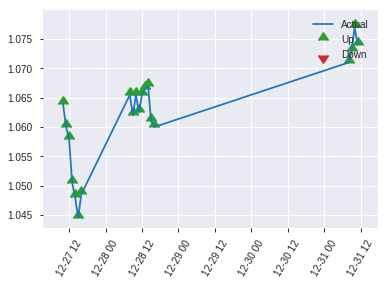


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24897086407178
RMSE: 0.4989698027654379
LogLoss: 0.6910849799922374
Mean Per-Class Error: 0.4326055430228811
AUC: 0.5680792781179503
pr_auc: 0.583290203931298
Gini: 0.13615855623590067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5143291754032796: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    103  0.9626   (103.0/107.0)
1      0    116  0        (0.0/116.0)
Total  4    219  0.4619   (103.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.514329     0.692537  218
max f2                       0.514329     0.849195  218
max f0point5                 0.525459     0.589744  165
max accuracy                 0.530883     0.565022  98
max precision                0.538472     1         0
max recall                   0.514329     1         218
max specificity              0.538472     1         0
max absolute_mcc             0.514329     0.140717  218
max min_per_class_accuracy   0.529951     0.551724  108
max mean_per_class_accuracy  0.530883     0.567394  98

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 52.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.538021           1.28161   1.28161            0.666667         0.538291  0.666667                    0.538291            0.0172414       0.0172414                  28.1609   28.1609
    2        0.0224215                   0.537673           1.92241   1.53793            1                0.537781  0.8                         0.538087            0.0172414       0.0344828                  92.2414   53.7931
    3        0.0313901                   0.536966           1.92241   1.64778            1                0.537314  0.857143                    0.537866            0.0172414       0.0517241                  92.2414   64.7783
    4        0.0403587                   0.536822           0.961207  1.49521            0.5              0.536933  0.777778                    0.537659            0.00862069      0.0603448                  -3.87931  49.5211
    5        0.0538117                   0.536694           0.640805  1.28161            0.333333         0.536746  0.666667                    0.537431            0.00862069      0.0689655                  -35.9195  28.1609
    6        0.103139                    0.535861           1.22335   1.25375            0.636364         0.536274  0.652174                    0.536878            0.0603448       0.12931                    22.3354   25.3748
    7        0.152466                    0.534021           1.22335   1.24391            0.636364         0.534885  0.647059                    0.536233            0.0603448       0.189655                   22.3354   24.3915
    8        0.201794                    0.533052           0.873824  1.15345            0.454545         0.533571  0.6                         0.535582            0.0431034       0.232759                   -12.6176  15.3448
    9        0.300448                    0.53223            1.04859   1.11902            0.545455         0.532653  0.58209                     0.53462             0.103448        0.336207                   4.85893   11.9017
    10       0.399103                    0.53144            1.04859   1.10161            0.545455         0.531748  0.573034                    0.53391             0.103448        0.439655                   4.85893   10.1608
    11       0.502242                    0.529829           1.08658   1.09852            0.565217         0.530593  0.571429                    0.533229            0.112069        0.551724                   8.65817   9.85222
    12       0.600897                    0.528263           0.873824  1.06163            0.454545         0.529086  0.552239                    0.532549            0.0862069       0.637931                   -12.6176  6.16315
    13       0.699552                    0.525965           1.04859   1.05979            0.545455         0.527133  0.551282                    0.531785            0.103448        0.741379                   4.85893   5.97922
    14       0.798206                    0.523527           0.961207  1.04761            0.5              0.52489   0.544944                    0.530933            0.0948276       0.836207                   -3.87931  4.76075
    15       0.896861                    0.52109            0.524295  0.990043           0.272727         0.522263  0.515                       0.529979            0.0517241       0.887931                   -47.5705  -0.99569
    16       1                           0.509063           1.08658   1                  0.565217         0.517271  0.520179                    0.528668        

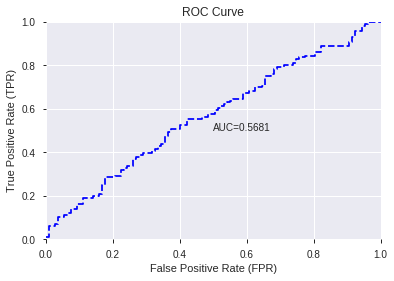

This function is available for GLM models only


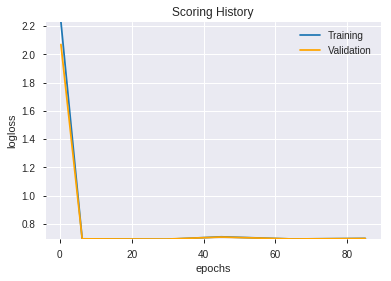

--2019-08-27 14:12:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  48.6MB/s    in 6.4s    

2019-08-27 14:12:59 (54.8 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unknown

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_135004_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_135004_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_141310_model_6  0.550918  0.687228              0.447510  0.497080  0.247089
1  DeepLearning_grid_1_AutoML_20190827_141310_model_5  0.539075  0.702078              0.455769  0.504327  0.254345
2  DeepLearning_grid_1_AutoML_20190827_141310_model_2  0.537464  0.933415              0.500000  0.562344  0.316231
3  DeepLearning_grid_1_AutoML_20190827_141310_model_1  0.537303  1.123318              0.479858  0.589394  0.347386
4  DeepLearning_grid_1_AutoML_20190827_141310_model_4  0.528601  0.945626              0.500000  0.564464  0.318619
5  DeepLearning_grid_1_AutoML_20190827_141310_model_3  0.527554  0.888409              0.500000  0.556497  0.309689
6               DeepLearning_1_AutoML_20190827_141310  0.513535  0.834593              0.500000  0.549395  0.301835
7  DeepLearning_grid_1_AutoML_20190827_141310_model_9  0.500161  0.691572              0.500000  0.499219  0.249220
8  DeepLearning_grid_1_AutoML_20190827_141310_model_8  0.500000  0.692356              0.500000  0.499604  0.249604
9  DeepLearning_grid_1_AutoML_20190827_141310_model_7  0.499114  0.816730              0.500000  0.549949  0.302444

variable  relative_importance  scaled_importance  percentage
0           STOCHF_fastk             1.000000           1.000000    0.022038
1           HT_TRENDMODE             0.993671           0.993671    0.021899
2            HT_DCPERIOD             0.991828           0.991828    0.021858
3                    OBV             0.987619           0.987619    0.021766
4                BETA_12             0.976409           0.976409    0.021519
5                 SAREXT             0.967745           0.967745    0.021328
6              dayofweek             0.966412           0.966412    0.021298
7                  DX_12             0.954258           0.954258    0.021030
8                weekday             0.951975           0.951975    0.020980
9               WILLR_12             0.946442           0.946442    0.020858
10                ADX_12             0.945555           0.945555    0.020839
11                BETA_8             0.942096           0.942096    0.020762
12                   BOP             0.936767           0.936767    0.020645
13        STOCHRSI_fastd             0.933995           0.933995    0.020584
14        STOCHRSI_fastk             0.932037           0.932037    0.020541
15                 CCI_8             0.929271           0.929271    0.020480
16         days_in_month             0.926923           0.926923    0.020428
17              CORREL_8             0.917604           0.917604    0.020223
18          aroondown_20             0.910751           0.910751    0.020072
19             CORREL_24             0.908171           0.908171    0.020015
20               BETA_20             0.907517           0.907517    0.020000
21             aroonup_8             0.904880           0.904880    0.019942
22               WILLR_8             0.904457           0.904457    0.019933
23           AROONOSC_30             0.904400           0.904400    0.019932
24           AROONOSC_24             0.899164           0.899164    0.019816
25            aroonup_20             0.894416           0.894416    0.019712
26                ADXR_8             0.892083           0.892083    0.019660
27                CCI_12             0.892073           0.892073    0.019660
28                 ROC_8             0.889271           0.889271    0.019598
29  HT_PHASOR_quadrature             0.886727           0.886727    0.019542
30           STOCH_slowd             0.886014           0.886014    0.019526
31                MFI_24             0.885378           0.885378    0.019512
32             CORREL_14             0.881323           0.881323    0.019423
33                   SUB             0.880655           0.880655    0.019408
34       MACDFIX_hist_12             0.878887           0.878887    0.019369
35                 DX_20             0.878300           0.878300    0.019356
36           MINUS_DI_24             0.877764           0.877764    0.019345
37    LINEARREG_SLOPE_24             0.872655           0.872655    0.019232
38          STOCHF_fastd             0.872421           0.872421    0.019227
39     MACDFIX_signal_12             0.871997           0.871997    0.019217
40           STOCH_slowk             0.869314           0.869314    0.019158
41            PLUS_DM_24             0.864278           0.864278    0.019047
42            aroonup_30             0.863104           0.863104    0.019021
43                 DX_14             0.862782           0.862782    0.019014
44                 CMO_8             0.861721           0.861721    0.018991
45                ROC_12             0.859947           0.859947    0.018952
46            PLUS_DM_30             0.857858           0.857858    0.018906
47            MACDFIX_20             0.856635           0.856635    0.018879
48              WILLR_14             0.856513           0.856513    0.018876
49           MINUS_DI_30             0.843164           0.843164    0.018582

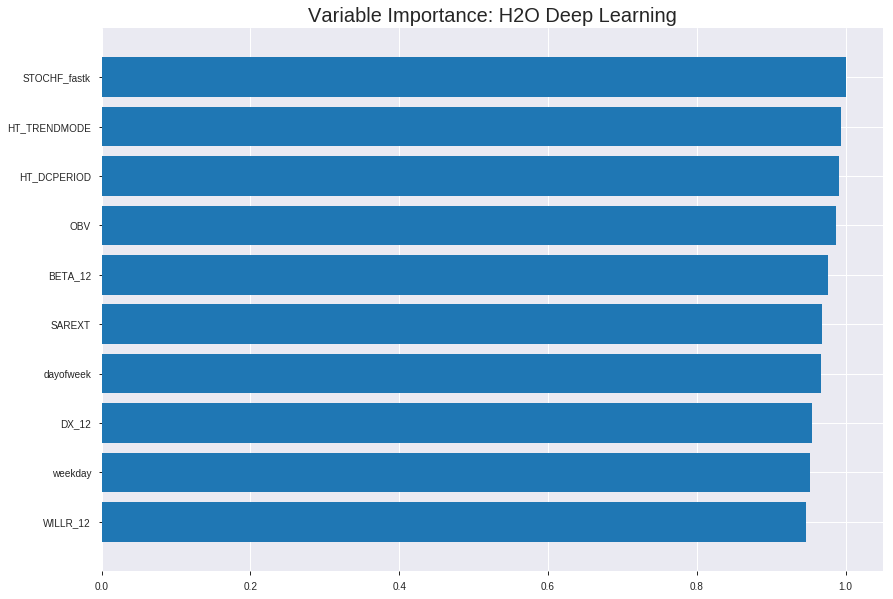

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_141310_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24399919552317817
RMSE: 0.49396274710060695
LogLoss: 0.6808752059777781
Mean Per-Class Error: 0.41611202379711565
AUC: 0.6060530107884449
pr_auc: 0.6243036208203397
Gini: 0.21210602157688974
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49274197214393944: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      118  631   0.8425   (631.0/749.0)
1      60   747   0.0743   (60.0/807.0)
Total  178  1378  0.4441   (691.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.492742     0.683753  334
max f2                       0.435431     0.843436  399
max f0point5                 0.518419     0.599464  253
max accuracy                 0.522999     0.58419   233
max precision                0.782515     1         0
max recall                   0.435431     1         399
max specificity              0.782515     1         0
max absolute_mcc             0.527681     0.168212  215
max min_per_class_accuracy   0.524217     0.579926  228
max mean_per_class_accuracy  0.527681     0.583888  215

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 53.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.672838           1.92813   1.92813            1                0.707785  1                           0.707785            0.0198265       0.0198265                  92.8129   92.8129
    2        0.0205656                   0.641888           1.4461    1.68711            0.75             0.652437  0.875                       0.680111            0.0148699       0.0346964                  44.6097   68.7113
    3        0.0302057                   0.615657           1.15688   1.51789            0.6              0.629304  0.787234                    0.663896            0.0111524       0.0458488                  15.6877   51.7889
    4        0.0404884                   0.608416           1.20508   1.43845            0.625            0.611599  0.746032                    0.650614            0.0123916       0.0582404                  20.5081   43.8445
    5        0.0501285                   0.600673           1.15688   1.3843             0.6              0.605633  0.717949                    0.641964            0.0111524       0.0693928                  15.6877   38.4298
    6        0.100257                    0.578618           1.28542   1.33486            0.666667         0.588831  0.692308                    0.615398            0.0644362       0.133829                   28.5419   33.4858
    7        0.150386                    0.562661           1.23598   1.3019             0.641026         0.570269  0.675214                    0.600355            0.0619579       0.195787                   23.598    30.1899
    8        0.200514                    0.553111           1.28542   1.29778            0.666667         0.557691  0.673077                    0.589689            0.0644362       0.260223                   28.5419   29.7779
    9        0.300129                    0.541753           1.11956   1.23863            0.580645         0.546705  0.642398                    0.575422            0.111524        0.371747                   11.9559   23.8627
    10       0.400386                    0.532735           1.00114   1.17916            0.519231         0.537027  0.611557                    0.565808            0.100372        0.472119                   0.114384  17.9161
    11       0.5                         0.52418            1.0698    1.15737            0.554839         0.528403  0.600257                    0.558356            0.106568        0.578686                   6.98005   15.7373
    12       0.600257                    0.517773           0.951705  1.12302            0.49359          0.520912  0.582441                    0.552102            0.0954151       0.674102                   -4.82954  12.3022
    13       0.699871                    0.510577           0.758812  1.07118            0.393548         0.513838  0.555556                    0.546656            0.0755886       0.74969                    -24.1188  7.11827
    14       0.800129                    0.502452           0.902265  1.05002            0.467949         0.506524  0.544578                    0.541627            0.0904585       0.840149                   -9.77346  5.00172
    15       0.899743                    0.491032           0.920526  1.03568            0.477419         0.496721  0.537143                    0.536656            0.0916976       0.931846                   -7.9474   3.56807
    16       1                           0.435431           0.679789  1                  0.352564         0.478967  0.518638                    0.530872         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24989037919102447
RMSE: 0.4998903671716674
LogLoss: 0.6930481384060589
Mean Per-Class Error: 0.4553520899021748
AUC: 0.532106475867087
pr_auc: 0.5386703036158177
Gini: 0.06421295173417407
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4364381214559697: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    216  0.9954   (216.0/217.0)
1      0    228  0        (0.0/228.0)
Total  1    444  0.4854   (216.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.436438     0.678571   398
max f2                       0.436438     0.840708   398
max f0point5                 0.507796     0.570809   263
max accuracy                 0.507796     0.548315   263
max precision                0.693707     0.714286   5
max recall                   0.436438     1          398
max specificity              0.719944     0.995392   0
max absolute_mcc             0.507796     0.0935443  263
max min_per_class_accuracy   0.519513     0.534562   207
max mean_per_class_accuracy  0.507796     0.544648   263

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 52.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.698069           1.17105   1.17105            0.6              0.708306  0.6                         0.708306            0.0131579       0.0131579                  17.1053   17.1053
    2        0.0202247                   0.673108           0.975877  1.08431            0.5              0.685612  0.555556                    0.69822             0.00877193      0.0219298                  -2.41228  8.4308
    3        0.0314607                   0.644752           0.390351  0.836466           0.2              0.659166  0.428571                    0.684272            0.00438596      0.0263158                  -60.9649  -16.3534
    4        0.0404494                   0.630071           1.46382   0.975877           0.75             0.638631  0.5                         0.67413             0.0131579       0.0394737                  46.3816   -2.41228
    5        0.0516854                   0.606521           1.5614    1.10317            0.8              0.61592   0.565217                    0.661475            0.0175439       0.0570175                  56.1404   10.3166
    6        0.101124                    0.57177            1.24203   1.17105            0.636364         0.585553  0.6                         0.624358            0.0614035       0.118421                   24.2026   17.1053
    7        0.150562                    0.558955           0.798445  1.0487             0.409091         0.564581  0.537313                    0.60473             0.0394737       0.157895                   -20.1555  4.87038
    8        0.2                         0.552451           1.06459   1.05263            0.545455         0.555434  0.539326                    0.592544            0.0526316       0.210526                   6.45933   5.26316
    9        0.301124                    0.538522           1.17105   1.0924             0.6              0.545465  0.559701                    0.576734            0.118421        0.328947                   17.1053   9.23998
    10       0.4                         0.527647           0.931519  1.05263            0.477273         0.532492  0.539326                    0.565798            0.0921053       0.421053                   -6.84809  5.26316
    11       0.501124                    0.519509           1.12768   1.06778            0.577778         0.52288   0.547085                    0.557137            0.114035        0.535088                   12.768    6.77759
    12       0.6                         0.510708           0.931519  1.04532            0.477273         0.514877  0.535581                    0.550173            0.0921053       0.627193                   -6.84809  4.53216
    13       0.698876                    0.504943           0.887161  1.02295            0.454545         0.507679  0.524116                    0.544161            0.0877193       0.714912                   -11.2839  2.29452
    14       0.8                         0.499793           0.737329  0.986842           0.377778         0.502322  0.505618                    0.538872            0.0745614       0.789474                   -26.2671  -1.31579
    15       0.898876                    0.492117           1.19767   1.01003            0.613636         0.496044  0.5175                      0.534161            0.118421        0.907895                   19.7667   1.00329
    16       1                           0.425766           0.910819  1                  0.466667         0.476312  0.51236                     0.528311       


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:16:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:16:33  1 min 47.342 sec  943 obs/sec       1.25578   1             1954       0.530194         0.780676            -0.125986      0.55619         0.572283           1.32559          0.472365                         0.544574           0.822978              -0.18697         0.526104          0.539789             1.17105            0.485393
    2019-08-27 14:16:38  1 min 52.886 sec  1921 obs/sec      8.8329    7             13744      0.493963         0.680875            0.0226453      0.606053        0.624304           1.92813          0.444087                         0.49989            0.693048              -0.000172656     0.532106          0.53867              1.17105            0.485393
    2019-08-27 14:16:44  1 min 58.289 sec  2607 obs/sec      20.2301   16            31478      0.490966         0.673232            0.0344685      0.636398        0.659922           1.92813          0.449229                         0.51133            0.721073              -0.0464732       0.53912           0.530637             0.780702           0.478652
    2019-08-27 14:16:49  2 min  3.403 sec  2941 obs/sec      31.6536   25            49253      0.475602         0.64189             0.093952       0.681059        0.698899           1.92813          0.400386                         0.501816           0.703384              -0.00789238      0.573066          0.553851             0.390351           0.465169
    2019-08-27 14:16:54  2 min  8.487 sec  3136 obs/sec      43.0739   34            67023      0.468877         0.625453            0.119396       0.701771        0.728427           1.92813          0.391388                         0.515595           0.743674              -0.0640023       0.561747          0.548915             0.390351           0.45618
    2019-08-27 14:16:59  2 min 13.670 sec  3251 obs/sec      54.5398   43            84864      0.454077         0.595098            0.17411        0.744161        0.767338           1.92813          0.36054                          0.507504           0.725965              -0.0308694       0.557371          0.547973             0.780702           0.476404
    2019-08-27 14:17:04  2 min 18.890 sec  3326 obs/sec      65.9987   52            102694     0.445991         0.576299            0.203259       0.773751        0.791503           1.92813          0.325835                         0.513902           0.741401              -0.0570257       0.542111          0.543364             1.17105            0.462921
    2019-08-27 14:17:05  2 min 19.366 sec  3324 obs/sec      65.9987   52            102694     0.493963         0.680875            0.0226453      0.606053        0.624304           1.92813          0.444087                         0.49989            0.693048              -0.000172656     0.532106          0.53867              1.17105            0.485393

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
STOCHF_fastk  1.0                    1.0                  0.022038458265741946
HT_TRENDMODE  0.9936713576316833     0.9936713576316833   0.021898984745028993
HT_DCPERIOD   0.9918283820152283     0.9918283820152283   0.02185836840382097
OBV           0.9876189231872559     0.9876189231872559   0.021765598421119338
BETA_12       0.9764091968536377     0.9764091968536377   0.021518553335145508
---           ---                    ---                  ---
ROC_12        0.8599470257759094     0.8599470257759094   0.018951906638311294
PLUS_DM_30    0.8578576445579529     0.8578576445579529   0.018905859897538135
MACDFIX_20    0.8566350936889648     0.8566350936889648   0.018878916761234193
WILLR_14      0.8565129637718201     0.8565129637718201   0.0188762252061522
MINUS_DI_30   0.8431643843650818     0.8431643843650818   0.018582043095989858


See the whole table with table.as_data_frame()


('accuracy', 0.5739910313901345)

('F1', 0.7018633540372671)

('auc', 0.5509184660006445)

('logloss', 0.6872281584975966)

('mean_per_class_error', 0.43739929100870123)

('rmse', 0.49708008394851955)

('mse', 0.24708860985826725)

deeplearning prediction progress: |███████████████████████████████████████| 100%


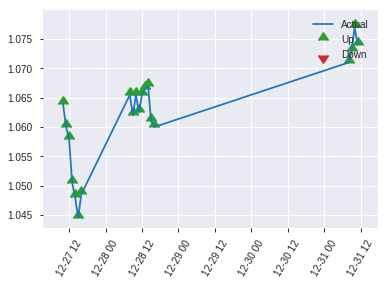


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24708860985826725
RMSE: 0.49708008394851955
LogLoss: 0.6872281584975966
Mean Per-Class Error: 0.43739929100870123
AUC: 0.5509184660006445
pr_auc: 0.5674691941297184
Gini: 0.10183693200128907
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48617287711789564: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      14   93   0.8692   (93.0/107.0)
1      3    113  0.0259   (3.0/116.0)
Total  17   206  0.4305   (96.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.486173     0.701863  205
max f2                       0.479854     0.848083  213
max f0point5                 0.486173     0.601064  205
max accuracy                 0.498499     0.573991  174
max precision                0.713511     1         0
max recall                   0.466629     1         220
max specificity              0.713511     1         0
max absolute_mcc             0.486173     0.197636  205
max min_per_class_accuracy   0.520114     0.514019  111
max mean_per_class_accuracy  0.498499     0.562601  174

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 53.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.694033           1.92241   1.92241            1                0.706926  1                           0.706926            0.0258621       0.0258621                  92.2414   92.2414
    2        0.0224215                   0.672195           0         1.15345            0                0.688674  0.6                         0.699625            0               0.0258621                  -100      15.3448
    3        0.0313901                   0.643076           1.92241   1.37315            1                0.650578  0.714286                    0.685612            0.0172414       0.0431034                  92.2414   37.3153
    4        0.0403587                   0.627826           1.92241   1.49521            1                0.639598  0.777778                    0.675386            0.0172414       0.0603448                  92.2414   49.5211
    5        0.0538117                   0.620348           0.640805  1.28161            0.333333         0.622867  0.666667                    0.662256            0.00862069      0.0689655                  -35.9195  28.1609
    6        0.103139                    0.582978           1.22335   1.25375            0.636364         0.601028  0.652174                    0.632973            0.0603448       0.12931                    22.3354   25.3748
    7        0.152466                    0.565504           1.04859   1.18737            0.545455         0.575414  0.617647                    0.614351            0.0517241       0.181034                   4.85893   18.7373
    8        0.201794                    0.558083           0.69906   1.06801            0.363636         0.561242  0.555556                    0.601369            0.0344828       0.215517                   -30.094   6.80077
    9        0.300448                    0.540122           1.22335   1.11902            0.636364         0.549305  0.58209                     0.584274            0.12069         0.336207                   22.3354   11.9017
    10       0.399103                    0.528409           0.961207  1.08001            0.5              0.534562  0.561798                    0.571985            0.0948276       0.431034                   -3.87931  8.00077
    11       0.502242                    0.520114           0.835832  1.02986            0.434783         0.524632  0.535714                    0.562261            0.0862069       0.517241                   -16.4168  2.98645
    12       0.600897                    0.510946           0.786442  0.9899             0.409091         0.515571  0.514925                    0.554595            0.0775862       0.594828                   -21.3558  -1.01004
    13       0.699552                    0.503843           1.39812   1.04747            0.727273         0.507501  0.544872                    0.547954            0.137931        0.732759                   39.8119   4.74691
    14       0.798206                    0.497536           1.13597   1.05841            0.590909         0.500369  0.550562                    0.542073            0.112069        0.844828                   13.5972   5.84076
    15       0.896861                    0.487968           1.04859   1.05733            0.545455         0.492833  0.55                        0.536656            0.103448        0.948276                   4.85893   5.73276
    16       1                           0.460584           0.501499  1                  0.26087          0.478726  0.520179                    0.530681        

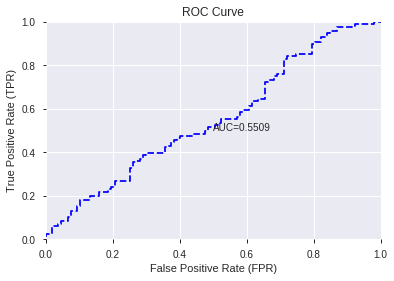

This function is available for GLM models only


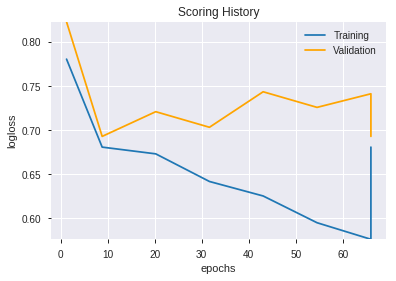

--2019-08-27 14:19:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_141310_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_141310_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHF_fastk',
 'HT_TRENDMODE',
 'HT_DCPERIOD',
 'OBV',
 'BETA_12',
 'SAREXT',
 'dayofweek',
 'DX_12',
 'weekday',
 'WILLR_12',
 'ADX_12',
 'BETA_8',
 'BOP',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'CCI_8',
 'days_in_month',
 'CORREL_8',
 'aroondown_20',
 'CORREL_24',
 'BETA_20',
 'aroonup_8',
 'WILLR_8',
 'AROONOSC_30',
 'AROONOSC_24',
 'aroonup_20',
 'ADXR_8',
 'CCI_12',
 'ROC_8',
 'HT_PHASOR_quadrature',
 'STOCH_slowd',
 'MFI_24',
 'CORREL_14',
 'SUB',
 'MACDFIX_hist_12',
 'DX_20',
 'MINUS_DI_24',
 'LINEARREG_SLOPE_24',
 'STOCHF_fastd',
 'MACDFIX_signal_12',
 'STOCH_slowk',
 'PLUS_DM_24',
 'aroonup_30',
 'DX_14',
 'CMO_8',
 'ROC_12',
 'PLUS_DM_30',
 'MACDFIX_20',
 'WILLR_14',
 'MINUS_DI_30']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_142005_model_1  0.52699  0.697278                   0.5  0.502001  0.252005

variable  relative_importance  scaled_importance  percentage
0                  DX_12             0.234497           1.000000    0.070350
1                 CCI_12             0.231435           0.986942    0.069431
2                  DX_20             0.192561           0.821167    0.057769
3             aroonup_30             0.170617           0.727586    0.051186
4               WILLR_14             0.154951           0.660781    0.046486
5            HT_DCPERIOD             0.147379           0.628488    0.044214
6            AROONOSC_24             0.140751           0.600225    0.042226
7                 MFI_24             0.131925           0.562588    0.039578
8                 SAREXT             0.120906           0.515597    0.036272
9                    OBV             0.099680           0.425082    0.029904
10          STOCHF_fastk             0.097954           0.417718    0.029386
11                   BOP             0.096565           0.411798    0.028970
12           MINUS_DI_30             0.090575           0.386254    0.027173
13                BETA_8             0.089629           0.382217    0.026889
14               BETA_20             0.082569           0.352110    0.024771
15        STOCHRSI_fastd             0.081265           0.346549    0.024380
16               BETA_12             0.079265           0.338020    0.023780
17                 CCI_8             0.077583           0.330848    0.023275
18        STOCHRSI_fastk             0.077503           0.330505    0.023251
19                 DX_14             0.074822           0.319074    0.022447
20           MINUS_DI_24             0.069176           0.294996    0.020753
21               WILLR_8             0.058930           0.251305    0.017679
22          HT_TRENDMODE             0.056610           0.241411    0.016983
23             aroonup_8             0.050671           0.216085    0.015202
24             CORREL_14             0.049367           0.210521    0.014810
25          STOCHF_fastd             0.045864           0.195586    0.013759
26           STOCH_slowk             0.043090           0.183755    0.012927
27       MACDFIX_hist_12             0.042934           0.183091    0.012880
28              CORREL_8             0.040877           0.174317    0.012263
29  HT_PHASOR_quadrature             0.040508           0.172746    0.012153
30            PLUS_DM_24             0.034142           0.145598    0.010243
31                   SUB             0.032681           0.139368    0.009805
32                ADXR_8             0.032130           0.137015    0.009639
33          aroondown_20             0.029957           0.127751    0.008987
34                 ROC_8             0.029311           0.124994    0.008793
35             CORREL_24             0.028685           0.122327    0.008606
36            MACDFIX_20             0.026577           0.113335    0.007973
37           STOCH_slowd             0.025806           0.110048    0.007742
38                ROC_12             0.024916           0.106253    0.007475
39                 CMO_8             0.017404           0.074217    0.005221
40     MACDFIX_signal_12             0.014771           0.062990    0.004431
41           AROONOSC_30             0.014765           0.062964    0.004430
42            PLUS_DM_30             0.012692           0.054124    0.003808
43             dayofweek             0.011150           0.047547    0.003345
44               weekday             0.011122           0.047428    0.003337
45                ADX_12             0.007169           0.030570    0.002151
46    LINEARREG_SLOPE_24             0.004501           0.019195    0.001350
47         days_in_month             0.003975           0.016949    0.001192
48              WILLR_12             0.000766           0.003267    0.000230
49            aroonup_20             0.000323           0.001377    0.000097

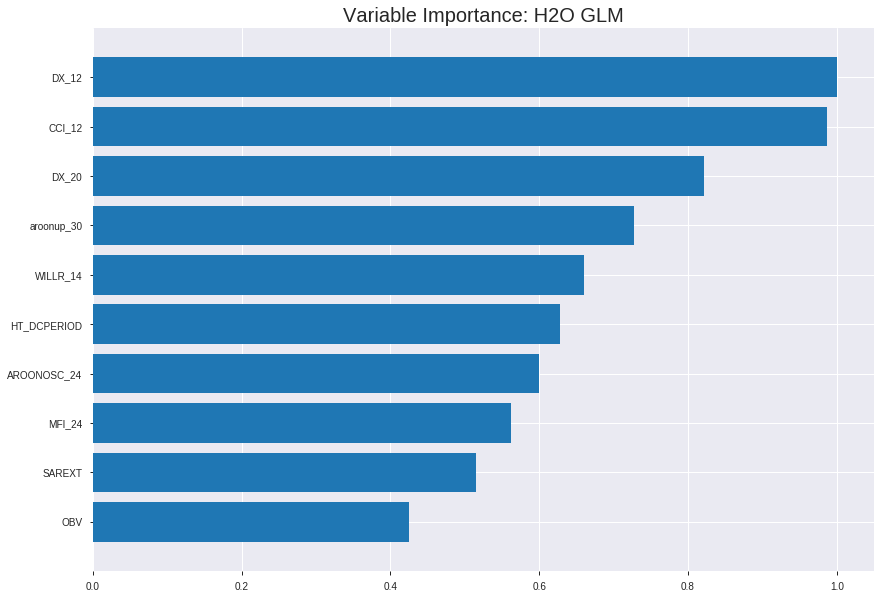

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_142005_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24161145966210035
RMSE: 0.49153988613550004
LogLoss: 0.6761133966665747
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2154.9115712492066
Residual deviance: 2104.0648904263803
AIC: 2206.0648904263803
AUC: 0.6028790142329384
pr_auc: 0.6062344471983971
Gini: 0.20575802846587687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41481179126063783: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      91   658   0.8785   (658.0/749.0)
1      33   774   0.0409   (33.0/807.0)
Total  124  1432  0.4441   (691.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414812     0.69138   338
max f2                       0.331932     0.843626  393
max f0point5                 0.502402     0.596998  220
max accuracy                 0.514464     0.579692  201
max precision                0.725521     1         0
max recall                   0.283488     1         398
max specificity              0.725521     1         0
max absolute_mcc             0.514464     0.157822  201
max min_per_class_accuracy   0.517519     0.574969  195
max mean_per_class_accuracy  0.514464     0.578867  201

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 51.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.681243           1.5666    1.5666             0.8125           0.703278  0.8125                      0.703278            0.016109        0.016109                   56.6605   56.6605
    2        0.0205656                   0.65531            1.08457   1.32559            0.5625           0.668483  0.6875                      0.68588             0.0111524       0.0272615                  8.45725   32.5589
    3        0.0302057                   0.64877            1.15688   1.27174            0.6              0.652015  0.659574                    0.675072            0.0111524       0.0384139                  15.6877   27.1745
    4        0.0404884                   0.640405           1.08457   1.22421            0.5625           0.643828  0.634921                    0.667137            0.0111524       0.0495663                  8.45725   22.4209
    5        0.0501285                   0.632872           1.15688   1.21126            0.6              0.636849  0.628205                    0.661313            0.0111524       0.0607187                  15.6877   21.126
    6        0.100257                    0.610385           1.55733   1.3843             0.807692         0.620557  0.717949                    0.640935            0.0780669       0.138786                   55.7335   38.4298
    7        0.150386                    0.594508           1.16182   1.31014            0.602564         0.601913  0.679487                    0.627928            0.0582404       0.197026                   16.1821   31.0139
    8        0.200514                    0.582121           1.06294   1.24834            0.551282         0.58882   0.647436                    0.618151            0.0532838       0.25031                    6.29428   24.834
    9        0.300129                    0.558851           1.14444   1.21385            0.593548         0.56946   0.62955                     0.60199             0.114002        0.364312                   14.4438   21.3854
    10       0.400386                    0.5367             1.00114   1.16059            0.519231         0.547267  0.601926                    0.588287            0.100372        0.464684                   0.114384  16.0591
    11       0.5                         0.517454           1.08224   1.14498            0.56129          0.52707   0.59383                     0.576091            0.107807        0.572491                   8.22401   14.4981
    12       0.600257                    0.501688           0.988784  1.11889            0.512821         0.509786  0.5803                      0.565017            0.0991326       0.671623                   -1.1216   11.8893
    13       0.699871                    0.482447           0.870768  1.08358            0.451613         0.492114  0.561983                    0.55464             0.086741        0.758364                   -12.9232  8.35766
    14       0.800129                    0.460608           0.840466  1.05311            0.435897         0.47141   0.546185                    0.544211            0.0842627       0.842627                   -15.9534  5.31146
    15       0.899743                    0.424077           0.957845  1.04257            0.496774         0.444246  0.540714                    0.533144            0.0954151       0.938042                   -4.21553  4.25668
    16       1                           0.278692           0.61799   1                  0.320513         0.388454  0.518638                    0.518638           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24601675960152491
RMSE: 0.4960007657267526
LogLoss: 0.6853015122109968
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 616.6992856395483
Residual deviance: 609.9183458677871
AIC: 711.9183458677871
AUC: 0.5826562373676126
pr_auc: 0.5831734680712265
Gini: 0.16531247473522526
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36899373738597335: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    212  0.977    (212.0/217.0)
1      1    227  0.0044   (1.0/228.0)
Total  6    439  0.4787   (213.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368994     0.68066   393
max f2                       0.353447     0.84195   396
max f0point5                 0.540273     0.582437  196
max accuracy                 0.542025     0.573034  193
max precision                0.7956       1         0
max recall                   0.353447     1         396
max specificity              0.7956       1         0
max absolute_mcc             0.594674     0.161909  89
max min_per_class_accuracy   0.540273     0.570175  196
max mean_per_class_accuracy  0.558512     0.57347   159

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 53.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.757805           1.17105   1.17105            0.6              0.773746  0.6                         0.773746            0.0131579       0.0131579                  17.1053    17.1053
    2        0.0202247                   0.715598           1.46382   1.30117            0.75             0.745742  0.666667                    0.7613              0.0131579       0.0263158                  46.3816    30.117
    3        0.0314607                   0.697595           0.780702  1.11529            0.4              0.708098  0.571429                    0.742299            0.00877193      0.0350877                  -21.9298   11.5288
    4        0.0404494                   0.678298           1.46382   1.19274            0.75             0.684978  0.611111                    0.729561            0.0131579       0.0482456                  46.3816    19.2739
    5        0.0516854                   0.671487           1.17105   1.18802            0.6              0.674997  0.608696                    0.717699            0.0131579       0.0614035                  17.1053    18.8024
    6        0.101124                    0.638302           1.33074   1.2578             0.681818         0.651145  0.644444                    0.685162            0.0657895       0.127193                   33.0742    25.7797
    7        0.150562                    0.607897           1.41946   1.31088            0.727273         0.623359  0.671642                    0.664868            0.0701754       0.197368                   41.9458    31.088
    8        0.2                         0.597497           1.24203   1.29386            0.636364         0.603433  0.662921                    0.649682            0.0614035       0.258772                   24.2026    29.386
    9        0.301124                    0.57588            0.997563  1.19436            0.511111         0.58656   0.61194                     0.628484            0.100877        0.359649                   -0.243665  19.4357
    10       0.4                         0.558095           1.10895   1.17325            0.568182         0.565407  0.601124                    0.612892            0.109649        0.469298                   10.8951    17.3246
    11       0.501124                    0.540004           0.997563  1.13779            0.511111         0.548623  0.58296                     0.599923            0.100877        0.570175                   -0.243665  13.7794
    12       0.6                         0.522915           0.798445  1.08187            0.409091         0.531515  0.554307                    0.58865             0.0789474       0.649123                   -20.1555   8.18713
    13       0.698876                    0.499844           0.887161  1.05432            0.454545         0.512497  0.540193                    0.577876            0.0877193       0.736842                   -11.2839   5.43239
    14       0.8                         0.473349           0.867446  1.0307             0.444444         0.486712  0.52809                     0.566352            0.0877193       0.824561                   -13.2554   3.07018
    15       0.898876                    0.439207           0.931519  1.01979            0.477273         0.457587  0.5225                      0.554388            0.0921053       0.916667                   -6.84809   1.97917
    16       1                           0.332817           0.824074  1                  0.422222         0.405027  0.51236                     0.5


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 14:20:06  0.000 sec   2            2.8       51            1.38166           1.38293
    2019-08-27 14:20:06  0.083 sec   4            1.7       51            1.38026           1.38194
    2019-08-27 14:20:06  0.110 sec   6            1.1       51            1.37847           1.38081
    2019-08-27 14:20:06  0.139 sec   8            0.67      51            1.37627           1.37959
    2019-08-27 14:20:06  0.167 sec   10           0.42      51            1.37368           1.37828
    2019-08-27 14:20:06  0.194 sec   12           0.26      51            1.37071           1.37688
    2019-08-27 14:20:06  0.218 sec   14           0.16      51            1.36741           1.37538
    2019-08-27 14:20:06  0.247 sec   16           0.1       51            1.36398           1.37391
    2019-08-27 14:20:06  0.268 sec   18           0.062     51            1.36057           1.37257
    2019-08-27 14:20:06  0.296 sec   20           0.038     51            1.35738           1.37151
    2019-08-27 14:20:06  0.318 sec   22           0.024     51            1.35457           1.37083
    2019-08-27 14:20:06  0.341 sec   24           0.015     51            1.35223           1.3706
    2019-08-27 14:20:06  0.360 sec   26           0.0092    51            1.35038           1.37075
    2019-08-27 14:20:06  0.378 sec   28           0.0057    51            1.34902           1.37124
    2019-08-27 14:20:06  0.403 sec   30           0.0036    51            1.34806           1.37207
    2019-08-27 14:20:06  0.420 sec   32           0.0022    51            1.34741           1.37329
    2019-08-27 14:20:06  0.432 sec   33           0.0014    51            1.34693           1.37492

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5381165919282511)

('F1', 0.6843657817109144)

('auc', 0.5269900096680632)

('logloss', 0.6972782907550755)

('mean_per_class_error', 0.4613680309378021)

('rmse', 0.5020006126786115)

('mse', 0.2520046151297013)

glm prediction progress: |████████████████████████████████████████████████| 100%


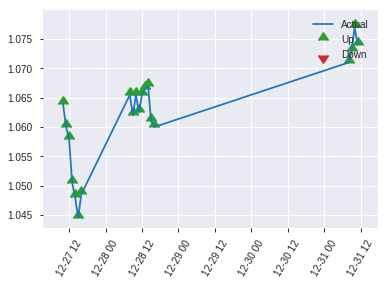


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2520046151297013
RMSE: 0.5020006126786115
LogLoss: 0.6972782907550755
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.7824388019844
Residual deviance: 310.9861176767637
AIC: 412.9861176767637
AUC: 0.5269900096680632
pr_auc: 0.5580283107509972
Gini: 0.053980019336126395
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3137926893873559: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    107  1        (107.0/107.0)
1      0    116  0        (0.0/116.0)
Total  0    223  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.313793     0.684366  222
max f2                       0.313793     0.84425   222
max f0point5                 0.480073     0.580357  194
max accuracy                 0.549251     0.538117  108
max precision                0.754631     1         0
max recall                   0.313793     1         222
max specificity              0.754631     1         0
max absolute_mcc             0.683318     0.16473   9
max min_per_class_accuracy   0.546401     0.534483  110
max mean_per_class_accuracy  0.549251     0.538632  108

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 55.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.727173           1.28161   1.28161            0.666667         0.737911  0.666667                    0.737911            0.0172414       0.0172414                  28.1609   28.1609
    2        0.0224215                   0.709136           1.92241   1.53793            1                0.720376  0.8                         0.730897            0.0172414       0.0344828                  92.2414   53.7931
    3        0.0313901                   0.692898           1.92241   1.64778            1                0.699919  0.857143                    0.722046            0.0172414       0.0517241                  92.2414   64.7783
    4        0.0403587                   0.683915           1.92241   1.70881            1                0.689125  0.888889                    0.714731            0.0172414       0.0689655                  92.2414   70.8812
    5        0.0538117                   0.676582           1.28161   1.60201            0.666667         0.680104  0.833333                    0.706074            0.0172414       0.0862069                  28.1609   60.2011
    6        0.103139                    0.644414           0.524295  1.08658            0.272727         0.660123  0.565217                    0.684097            0.0258621       0.112069                   -47.5705  8.65817
    7        0.152466                    0.621622           0.873824  1.01775            0.454545         0.633731  0.529412                    0.667802            0.0431034       0.155172                   -12.6176  1.77485
    8        0.201794                    0.60498            1.04859   1.02529            0.545455         0.612879  0.533333                    0.654377            0.0517241       0.206897                   4.85893   2.52874
    9        0.300448                    0.584287           1.04859   1.03294            0.545455         0.592838  0.537313                    0.63417             0.103448        0.310345                   4.85893   3.29388
    10       0.399103                    0.568737           1.13597   1.05841            0.590909         0.577634  0.550562                    0.620195            0.112069        0.422414                   13.5972   5.84076
    11       0.502242                    0.545394           1.08658   1.06419            0.565217         0.556725  0.553571                    0.607161            0.112069        0.534483                   8.65817   6.41933
    12       0.600897                    0.530245           0.961207  1.04729            0.5              0.536973  0.544776                    0.595637            0.0948276       0.62931                    -3.87931  4.72851
    13       0.699552                    0.51452            0.786442  1.0105             0.409091         0.52058   0.525641                    0.585052            0.0775862       0.706897                   -21.3558  1.04996
    14       0.798206                    0.496006           1.04859   1.01521            0.545455         0.50514   0.52809                     0.575176            0.103448        0.810345                   4.85893   1.52073
    15       0.896861                    0.461394           0.961207  1.00927            0.5              0.484169  0.525                       0.565165            0.0948276       0.905172                   -3.87931  0.926724
    16       1                           0.313793           0.919415  1                  0.478261         0.417997  0.520179                    0.549986        

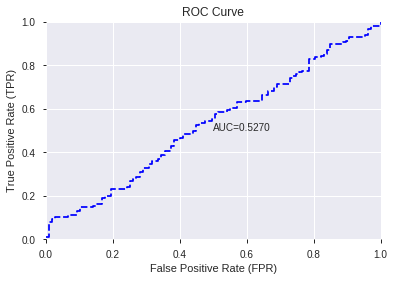

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


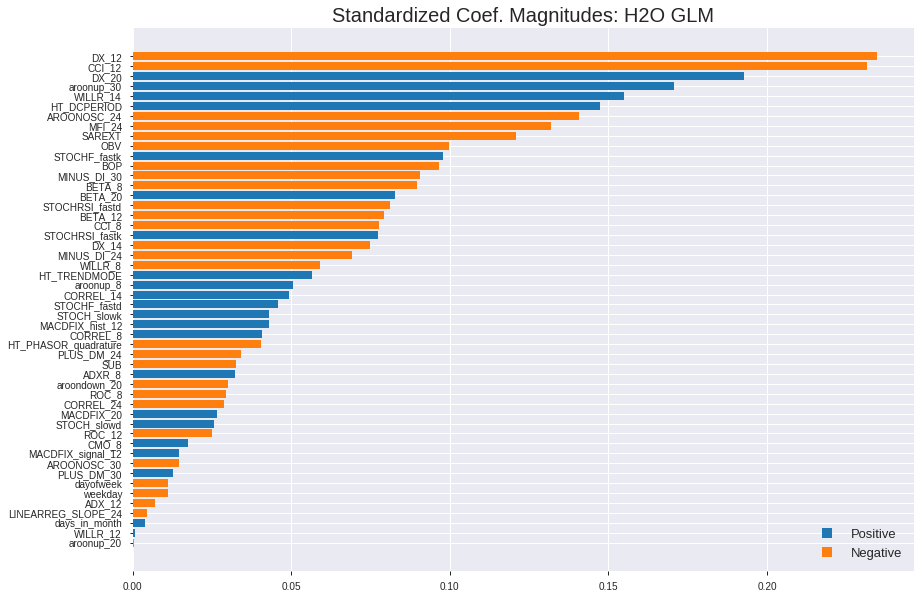

'log_likelihood'
--2019-08-27 14:20:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_142005_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_142005_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['DX_12',
 'CCI_12',
 'DX_20',
 'aroonup_30',
 'WILLR_14',
 'HT_DCPERIOD',
 'AROONOSC_24',
 'MFI_24',
 'SAREXT',
 'OBV',
 'STOCHF_fastk',
 'BOP',
 'MINUS_DI_30',
 'BETA_8',
 'BETA_20',
 'STOCHRSI_fastd',
 'BETA_12',
 'CCI_8',
 'STOCHRSI_fastk',
 'DX_14',
 'MINUS_DI_24',
 'WILLR_8',
 'HT_TRENDMODE',
 'aroonup_8',
 'CORREL_14',
 'STOCHF_fastd',
 'STOCH_slowk',
 'MACDFIX_hist_12',
 'CORREL_8',
 'HT_PHASOR_quadrature',
 'PLUS_DM_24',
 'SUB',
 'ADXR_8',
 'aroondown_20',
 'ROC_8',
 'CORREL_24',
 'MACDFIX_20',
 'STOCH_slowd',
 'ROC_12',
 'CMO_8',
 'MACDFIX_signal_12',
 'AROONOSC_30',
 'PLUS_DM_30',
 'dayofweek',
 'weekday',
 'ADX_12',
 'LINEARREG_SLOPE_24',
 'days_in_month',
 'WILLR_12',
 'aroonup_20']

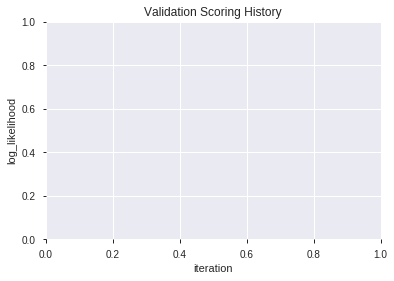

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_142017_model_3  0.569691  0.693557              0.500000  0.499988  0.249988
1  XGBoost_grid_1_AutoML_20190827_142017_model_4  0.567918  0.685274              0.480583  0.496109  0.246124
2               XGBoost_2_AutoML_20190827_142017  0.559781  0.694431              0.495327  0.500374  0.250374
3  XGBoost_grid_1_AutoML_20190827_142017_model_6  0.536255  0.704716              0.495327  0.505537  0.255567
4  XGBoost_grid_1_AutoML_20190827_142017_model_2  0.533677  0.696392              0.500000  0.501516  0.251518
5  XGBoost_grid_1_AutoML_20190827_142017_model_1  0.532388  0.719275              0.500000  0.512158  0.262306
6  XGBoost_grid_1_AutoML_20190827_142017_model_7  0.528843  0.703767              0.476636  0.504686  0.254708
7               XGBoost_1_AutoML_20190827_142017  0.526184  0.701631              0.490654  0.503860  0.253875
8               XGBoost_3_AutoML_20190827_142017  0.516516  0.714613              0.495327  0.509763  0.259858
9  XGBoost_grid_1_AutoML_20190827_142017_model_5  0.516033  0.741396              0.490292  0.520343  0.270757

variable  relative_importance  scaled_importance  percentage
0   HT_PHASOR_quadrature           224.278076           1.000000    0.047594
1                 BETA_8           202.385422           0.902386    0.042948
2            STOCH_slowd           180.958984           0.806851    0.038401
3             PLUS_DM_24           174.904114           0.779854    0.037117
4            HT_DCPERIOD           174.145523           0.776471    0.036956
5                  ROC_8           173.391037           0.773107    0.036795
6             PLUS_DM_30           161.633026           0.720681    0.034300
7         STOCHRSI_fastd           159.245926           0.710038    0.033794
8                  DX_20           154.846756           0.690423    0.032860
9                    BOP           147.825653           0.659118    0.031370
10                ADX_12           145.823746           0.650192    0.030945
11                CCI_12           125.911629           0.561409    0.026720
12                SAREXT           121.727135           0.542751    0.025832
13    LINEARREG_SLOPE_24           117.398384           0.523450    0.024913
14           STOCH_slowk           116.856926           0.521036    0.024798
15              WILLR_14           109.940056           0.490195    0.023330
16               WILLR_8           109.124084           0.486557    0.023157
17                MFI_24           107.221825           0.478075    0.022754
18                 DX_12           106.189880           0.473474    0.022535
19                   SUB           105.570450           0.470712    0.022403
20               BETA_20           103.474289           0.461366    0.021958
21                   OBV           101.352180           0.451904    0.021508
22             CORREL_24            99.257416           0.442564    0.021063
23       MACDFIX_hist_12            96.376480           0.429719    0.020452
24                ADXR_8            95.313469           0.424979    0.020227
25                ROC_12            92.366608           0.411840    0.019601
26     MACDFIX_signal_12            85.235359           0.380043    0.018088
27             CORREL_14            84.627281           0.377332    0.017959
28                 DX_14            78.918419           0.351878    0.016747
29                 CCI_8            72.869926           0.324909    0.015464
30               BETA_12            70.644150           0.314985    0.014991
31        STOCHRSI_fastk            70.054581           0.312356    0.014866
32          aroondown_20            67.619698           0.301499    0.014350
33           AROONOSC_24            65.455055           0.291848    0.013890
34           MINUS_DI_30            64.024178           0.285468    0.013587
35              WILLR_12            63.833992           0.284620    0.013546
36          STOCHF_fastd            62.443111           0.278418    0.013251
37             aroonup_8            60.559441           0.270019    0.012851
38           AROONOSC_30            54.527081           0.243123    0.011571
39            aroonup_30            51.034500           0.227550    0.010830
40          STOCHF_fastk            49.075718           0.218816    0.010414
41                 CMO_8            45.359039           0.202245    0.009626
42           MINUS_DI_24            39.374237           0.175560    0.008356
43              CORREL_8            37.649422           0.167869    0.007990
44            MACDFIX_20            24.781330           0.110494    0.005259
45             dayofweek            18.896151           0.084253    0.004010
46               weekday            16.521973           0.073667    0.003506
47            aroonup_20            16.299702           0.072676    0.003459
48         days_in_month             4.972266           0.022170    0.001055

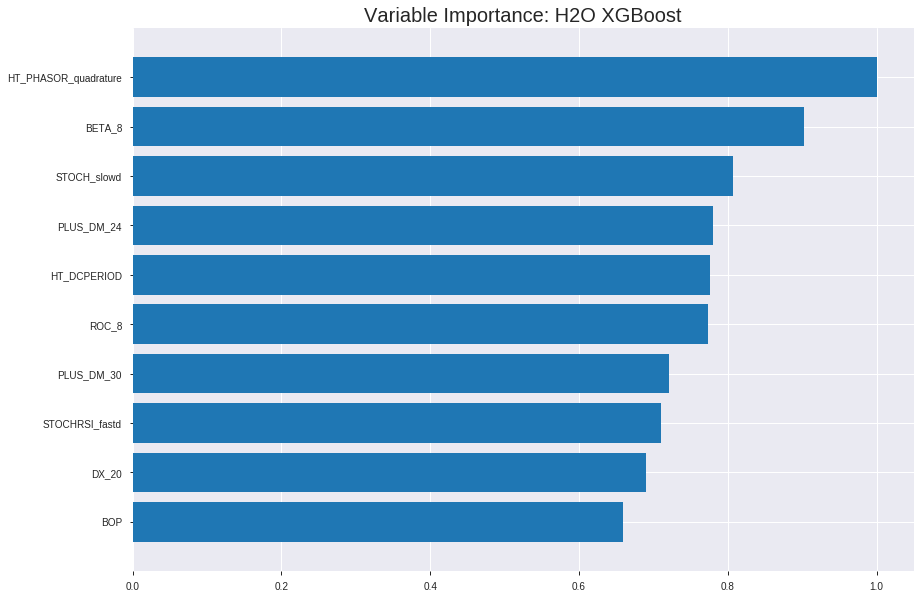

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_142017_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.19681503713118395
RMSE: 0.44363840808837096
LogLoss: 0.5843534173090666
Mean Per-Class Error: 0.16355801953203197
AUC: 0.9095208315755166
pr_auc: 0.9095823461498302
Gini: 0.8190416631510331
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.498076726992925: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      580  169  0.2256   (169.0/749.0)
1      95   712  0.1177   (95.0/807.0)
Total  675  881  0.1697   (264.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498077     0.843602  217
max f2                       0.457984     0.905034  266
max f0point5                 0.521924     0.854217  188
max accuracy                 0.513279     0.836118  199
max precision                0.789945     1         0
max recall                   0.396465     1         326
max specificity              0.789945     1         0
max absolute_mcc             0.513279     0.672436  199
max min_per_class_accuracy   0.51101      0.834446  201
max mean_per_class_accuracy  0.513279     0.836442  199

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 51.17 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.716734           1.92813    1.92813            1                0.73369   1                           0.73369             0.0198265       0.0198265                  92.8129   92.8129
    2        0.0205656                   0.692727           1.92813    1.92813            1                0.705261  1                           0.719475            0.0198265       0.039653                   92.8129   92.8129
    3        0.0302057                   0.680868           1.92813    1.92813            1                0.684935  1                           0.708452            0.0185874       0.0582404                  92.8129   92.8129
    4        0.0404884                   0.668976           1.92813    1.92813            1                0.674462  1                           0.69982             0.0198265       0.0780669                  92.8129   92.8129
    5        0.0501285                   0.65783            1.92813    1.92813            1                0.663094  1                           0.692757            0.0185874       0.0966543                  92.8129   92.8129
    6        0.100257                    0.625586           1.90341    1.91577            0.987179         0.63979   0.99359                     0.666273            0.0954151       0.192069                   90.3409   91.5769
    7        0.150386                    0.605724           1.73037    1.85397            0.897436         0.615711  0.961538                    0.649419            0.086741        0.27881                    73.0372   85.397
    8        0.200514                    0.585506           1.70565    1.81689            0.884615         0.594452  0.942308                    0.635677            0.0855019       0.364312                   70.5652   81.6891
    9        0.300129                    0.558547           1.69178    1.77536            0.877419         0.572425  0.920771                    0.614684            0.168525        0.532838                   69.1778   77.5365
    10       0.400386                    0.537643           1.60677    1.73315            0.833333         0.54799   0.898876                    0.597983            0.16109         0.693928                   60.6774   73.315
    11       0.5                         0.513588           1.28127    1.64312            0.664516         0.526103  0.852185                    0.583663            0.127633        0.821561                   28.1273   64.3123
    12       0.600257                    0.490456           0.815747   1.50493            0.423077         0.5015    0.780514                    0.56994             0.0817844       0.903346                   -18.4253  50.4931
    13       0.699871                    0.468345           0.510021   1.36332            0.264516         0.479581  0.707071                    0.557079            0.0508055       0.954151                   -48.9979  36.3323
    14       0.800129                    0.435289           0.383154   1.24051            0.198718         0.452466  0.643373                    0.543971            0.0384139       0.992565                   -61.6846  24.0507
    15       0.899743                    0.394442           0.0746372  1.11143            0.0387097        0.416823  0.576429                    0.529894            0.00743494      1                          -92.5363  11.1429
    16       1                           0.232209           0          1                  0                0.347942  0.518638                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2518737386475864
RMSE: 0.5018702408467615
LogLoss: 0.6970749528625398
Mean Per-Class Error: 0.4505416767725766
AUC: 0.5392614601018676
pr_auc: 0.5657239940547705
Gini: 0.07852292020373519
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28505897521972656: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    216  0.9954   (216.0/217.0)
1      0    228  0        (0.0/228.0)
Total  1    444  0.4854   (216.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.285059     0.678571  398
max f2                       0.285059     0.840708  398
max f0point5                 0.457472     0.570513  297
max accuracy                 0.552041     0.546067  151
max precision                0.815669     1         0
max recall                   0.285059     1         398
max specificity              0.815669     1         0
max absolute_mcc             0.684843     0.132308  20
max min_per_class_accuracy   0.51791      0.516129  204
max mean_per_class_accuracy  0.552041     0.549458  151

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 52.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.727584           1.5614    1.5614             0.8              0.751316  0.8                         0.751316            0.0175439       0.0175439                  56.1404    56.1404
    2        0.0202247                   0.700404           1.95175   1.73489            1                0.716315  0.888889                    0.73576             0.0175439       0.0350877                  95.1754    73.4893
    3        0.0314607                   0.695177           1.17105   1.53352            0.6              0.697041  0.785714                    0.721932            0.0131579       0.0482456                  17.1053    53.3521
    4        0.0404494                   0.687809           1.95175   1.62646            1                0.691382  0.833333                    0.715143            0.0175439       0.0657895                  95.1754    62.6462
    5        0.0516854                   0.680749           1.17105   1.52746            0.6              0.684355  0.782609                    0.70845             0.0131579       0.0789474                  17.1053    52.746
    6        0.101124                    0.646244           0.798445  1.17105            0.409091         0.660948  0.6                         0.685227            0.0394737       0.118421                   -20.1555   17.1053
    7        0.150562                    0.624127           0.887161  1.07783            0.454545         0.635202  0.552239                    0.668801            0.0438596       0.162281                   -11.2839   7.78345
    8        0.2                         0.606483           1.33074   1.14035            0.681818         0.615613  0.58427                     0.655653            0.0657895       0.22807                    33.0742    14.0351
    9        0.301124                    0.573515           1.08431   1.12153            0.555556         0.589967  0.574627                    0.633595            0.109649        0.337719                   8.4308     12.1531
    10       0.4                         0.543856           0.931519  1.07456            0.477273         0.556061  0.550562                    0.614429            0.0921053       0.429825                   -6.84809   7.45614
    11       0.501124                    0.51791            0.867446  1.03277            0.444444         0.53134   0.529148                    0.597662            0.0877193       0.517544                   -13.2554   3.27669
    12       0.6                         0.494566           0.931519  1.01608            0.477273         0.505693  0.520599                    0.582506            0.0921053       0.609649                   -6.84809   1.60819
    13       0.698876                    0.468206           1.06459   1.02295            0.545455         0.483938  0.524116                    0.568561            0.105263        0.714912                   6.45933    2.29452
    14       0.8                         0.444641           0.997563  1.01974            0.511111         0.456466  0.522472                    0.554392            0.100877        0.815789                   -0.243665  1.97368
    15       0.898876                    0.405954           0.842803  1.00027            0.431818         0.424465  0.5125                      0.5401              0.0833333       0.899123                   -15.7197   0.0274123
    16       1                           0.283317           0.997563  1                  0.511111         0.370063  0.51236                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:20:23  1.892 sec   0                  0.5              0.693147            0.5             0                  1                0.481362                         0.5                0.693147              0.5               0                    1                  0.48764
    2019-08-27 14:20:24  2.065 sec   5                  0.491508         0.676274            0.722656        0.728791           1.80762          0.3509                           0.499323           0.691804              0.536189          0.549148             1.30117            0.48764
    2019-08-27 14:20:24  2.131 sec   10                 0.482991         0.659562            0.795637        0.804144           1.92813          0.280206                         0.500009           0.693186              0.524254          0.537036             1.17105            0.48764
    2019-08-27 14:20:24  2.192 sec   15                 0.475067         0.644166            0.825692        0.833678           1.92813          0.262211                         0.499704           0.692567              0.532218          0.545785             1.95175            0.483146
    2019-08-27 14:20:24  2.266 sec   20                 0.467305         0.629238            0.854581        0.858788           1.92813          0.233933                         0.499311           0.691768              0.539494          0.560662             1.5614             0.485393
    2019-08-27 14:20:24  2.351 sec   25                 0.459946         0.615242            0.873792        0.877865           1.92813          0.208869                         0.499881           0.692916              0.537978          0.557764             1.5614             0.483146
    2019-08-27 14:20:24  2.418 sec   30                 0.453276         0.602632            0.88641         0.890561           1.92813          0.202442                         0.499698           0.692604              0.544527          0.557385             1.17105            0.483146
    2019-08-27 14:20:24  2.492 sec   35                 0.446995         0.590851            0.898522        0.902533           1.92813          0.197301                         0.500111           0.69343               0.543243          0.562255             1.17105            0.485393
    2019-08-27 14:20:24  2.564 sec   40                 0.440585         0.578868            0.90736         0.912998           1.92813          0.190231                         0.500793           0.694832              0.540606          0.562529             1.17105            0.485393
    2019-08-27 14:20:24  2.639 sec   45                 0.434234         0.567164            0.919068        0.921911           1.92813          0.163882                         0.502407           0.698125              0.530985          0.558739             1.5614             0.485393
    2019-08-27 14:20:24  2.722 sec   50                 0.443638         0.584353            0.909521        0.909582           1.92813          0.169666                         0.50187            0.697075              0.539261          0.565724             1.5614             0.485393

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
HT_PHASOR_quadrature  224.278076171875       1.0                   0.04759422822952039
BETA_8                202.3854217529297      0.9023861146277716    0.042948370690744316
STOCH_slowd           180.958984375          0.8068509747529781    0.03840144943960423
PLUS_DM_24            174.90411376953125     0.7798538169887541    0.03711654055142539
HT_DCPERIOD           174.14552307128906     0.776471450280468     0.036955559418355294
---                   ---                    ---                   ---
MACDFIX_20            24.781330108642578     0.11049376975059953   0.00525886569545011
dayofweek             18.896150588989258     0.08425322221200184   0.004009967087030513
weekday               16.52197265625         0.0736673550008001    0.00350614090697318
aroonup_20            16.299701690673828     0.072676304206313     0.0034589726092733144
days_in_month         4.97226619720459       0.022170094741646103  0.0010551685490039946


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57847533632287)

('F1', 0.6843657817109144)

('auc', 0.5696906219787302)

('logloss', 0.6935567065572324)

('mean_per_class_error', 0.41786174669674514)

('rmse', 0.499988127574134)

('mse', 0.24998812771508852)

xgboost prediction progress: |████████████████████████████████████████████| 100%


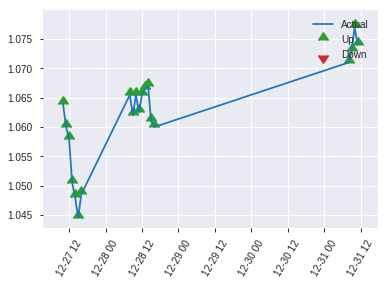


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24998812771508852
RMSE: 0.499988127574134
LogLoss: 0.6935567065572324
Mean Per-Class Error: 0.41786174669674514
AUC: 0.5696906219787302
pr_auc: 0.581524161216673
Gini: 0.13938124395746043
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2961055338382721: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    107  1        (107.0/107.0)
1      0    116  0        (0.0/116.0)
Total  0    223  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.296106     0.684366  222
max f2                       0.296106     0.84425   222
max f0point5                 0.483839     0.598592  183
max accuracy                 0.606083     0.578475  91
max precision                0.77694      1         0
max recall                   0.296106     1         222
max specificity              0.77694      1         0
max absolute_mcc             0.606083     0.166712  91
max min_per_class_accuracy   0.571447     0.542056  111
max mean_per_class_accuracy  0.606083     0.582138  91

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 57.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.73521            1.28161   1.28161            0.666667         0.758244  0.666667                    0.758244            0.0172414       0.0172414                  28.1609   28.1609
    2        0.0224215                   0.730048           1.92241   1.53793            1                0.731653  0.8                         0.747607            0.0172414       0.0344828                  92.2414   53.7931
    3        0.0313901                   0.721753           1.92241   1.64778            1                0.727026  0.857143                    0.741727            0.0172414       0.0517241                  92.2414   64.7783
    4        0.0403587                   0.711406           0.961207  1.49521            0.5              0.716733  0.777778                    0.736173            0.00862069      0.0603448                  -3.87931  49.5211
    5        0.0538117                   0.705501           1.28161   1.44181            0.666667         0.708033  0.75                        0.729138            0.0172414       0.0775862                  28.1609   44.181
    6        0.103139                    0.690831           0.69906   1.08658            0.363636         0.698053  0.565217                    0.714271            0.0344828       0.112069                   -30.094   8.65817
    7        0.152466                    0.675573           1.04859   1.07429            0.545455         0.683329  0.558824                    0.70426             0.0517241       0.163793                   4.85893   7.42901
    8        0.201794                    0.652779           1.57288   1.19617            0.818182         0.66285   0.622222                    0.694138            0.0775862       0.241379                   57.2884   19.6169
    9        0.300448                    0.632905           0.873824  1.09032            0.454545         0.640204  0.567164                    0.676428            0.0862069       0.327586                   -12.6176  9.03242
    10       0.399103                    0.606977           1.39812   1.16641            0.727273         0.619037  0.606742                    0.662242            0.137931        0.465517                   39.8119   16.6408
    11       0.502242                    0.571447           0.752249  1.08136            0.391304         0.589652  0.5625                      0.647335            0.0775862       0.543103                   -24.7751  8.13578
    12       0.600897                    0.550775           0.873824  1.04729            0.454545         0.559992  0.544776                    0.632995            0.0862069       0.62931                    -12.6176  4.72851
    13       0.699552                    0.52426            1.04859   1.04747            0.545455         0.539242  0.544872                    0.619773            0.103448        0.732759                   4.85893   4.74691
    14       0.798206                    0.498478           1.13597   1.05841            0.590909         0.511243  0.550562                    0.606359            0.112069        0.844828                   13.5972   5.84076
    15       0.896861                    0.456716           0.611677  1.00927            0.318182         0.476323  0.525                       0.592056            0.0603448       0.905172                   -38.8323  0.926724
    16       1                           0.296106           0.919415  1                  0.478261         0.413447  0.520179                    0.573634         

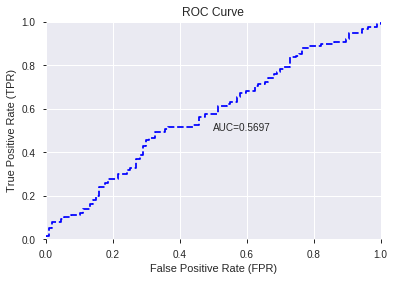

This function is available for GLM models only


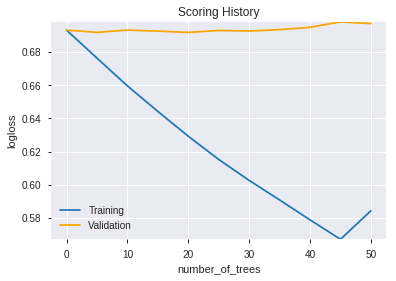

--2019-08-27 14:20:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.176.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.176.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_142017_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_142017_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_PHASOR_quadrature',
 'BETA_8',
 'STOCH_slowd',
 'PLUS_DM_24',
 'HT_DCPERIOD',
 'ROC_8',
 'PLUS_DM_30',
 'STOCHRSI_fastd',
 'DX_20',
 'BOP',
 'ADX_12',
 'CCI_12',
 'SAREXT',
 'LINEARREG_SLOPE_24',
 'STOCH_slowk',
 'WILLR_14',
 'WILLR_8',
 'MFI_24',
 'DX_12',
 'SUB',
 'BETA_20',
 'OBV',
 'CORREL_24',
 'MACDFIX_hist_12',
 'ADXR_8',
 'ROC_12',
 'MACDFIX_signal_12',
 'CORREL_14',
 'DX_14',
 'CCI_8',
 'BETA_12',
 'STOCHRSI_fastk',
 'aroondown_20',
 'AROONOSC_24',
 'MINUS_DI_30',
 'WILLR_12',
 'STOCHF_fastd',
 'aroonup_8',
 'AROONOSC_30',
 'aroonup_30',
 'STOCHF_fastk',
 'CMO_8',
 'MINUS_DI_24',
 'CORREL_8',
 'MACDFIX_20',
 'dayofweek',
 'weekday',
 'aroonup_20',
 'days_in_month']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_142042_model_1  0.506526  0.704931                   0.5  0.505349  0.255378

variable  relative_importance  scaled_importance    percentage
0                  HT_DCPERIOD         5.787469e-02           1.000000  1.475880e-02
1                         DX_8         5.706691e-02           0.986043  1.455281e-02
2                       SAREXT         5.112240e-02           0.883329  1.303688e-02
3            CDLGRAVESTONEDOJI         4.883838e-02           0.843864  1.245442e-02
4                   CDL3INSIDE         4.732664e-02           0.817743  1.206891e-02
...                        ...                  ...                ...           ...
1033  BBANDS_middleband_20_1_2         3.800155e-06           0.000066  9.690891e-07
1034                 MAVP_14_0         3.308654e-06           0.000057  8.437500e-07
1035               aroondown_8         3.008027e-06           0.000052  7.670861e-07
1036                    MA_8_2         1.447435e-07           0.000003  3.691148e-08
1037                   MA_20_1         1.078671e-07           0.000002  2.750751e-08

[1038 rows x 4 columns]

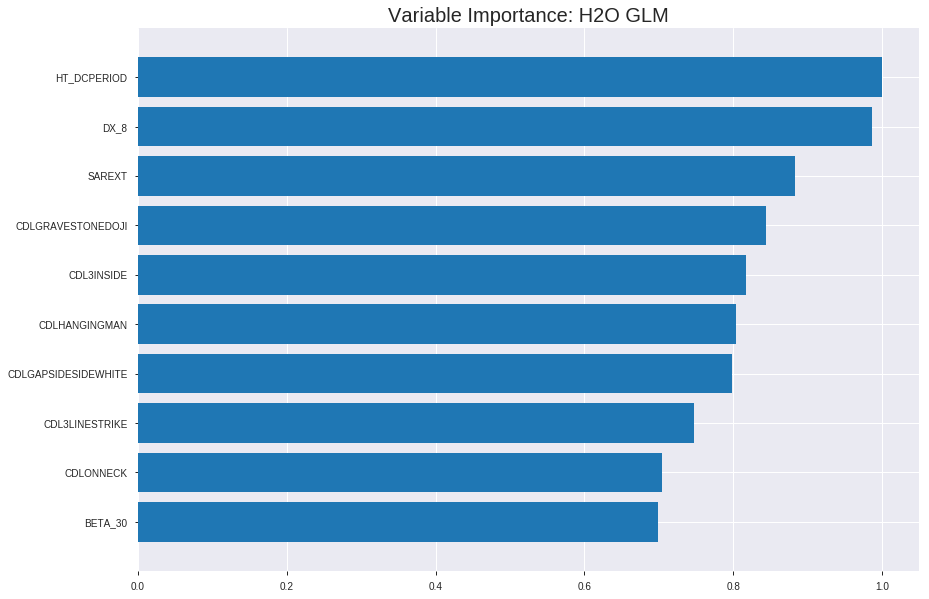

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_142042_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2363521883103135
RMSE: 0.48616066100653754
LogLoss: 0.6651297182664451
Null degrees of freedom: 1555
Residual degrees of freedom: 517
Null deviance: 2154.9115712492066
Residual deviance: 2069.883683245177
AIC: 4147.883683245177
AUC: 0.6428381170763827
pr_auc: 0.6499316639214839
Gini: 0.28567623415276544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4399269498618629: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      112  637   0.8505   (637.0/749.0)
1      35   772   0.0434   (35.0/807.0)
Total  147  1409  0.4319   (672.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439927     0.696751  316
max f2                       0.363099     0.848224  373
max f0point5                 0.5139       0.621038  201
max accuracy                 0.5139       0.606684  201
max precision                0.789717     1         0
max recall                   0.363099     1         373
max specificity              0.789717     1         0
max absolute_mcc             0.5139       0.210702  201
max min_per_class_accuracy   0.521631     0.59279   188
max mean_per_class_accuracy  0.5139       0.604793  201

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 51.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.676666           1.68711   1.68711            0.875            0.722345  0.875                       0.722345            0.0173482       0.0173482                  68.7113   68.7113
    2        0.0205656                   0.64861            1.4461    1.5666             0.75             0.660765  0.8125                      0.691555            0.0148699       0.0322181                  44.6097   56.6605
    3        0.0302057                   0.637473           1.67105   1.59994            0.866667         0.642352  0.829787                    0.675852            0.016109        0.0483271                  67.1045   59.9937
    4        0.0404884                   0.624974           1.68711   1.62208            0.875            0.63135   0.84127                     0.66455             0.0173482       0.0656753                  68.7113   62.2077
    5        0.0501285                   0.616848           1.5425    1.60677            0.8              0.621193  0.833333                    0.656212            0.0148699       0.0805452                  54.2503   60.6774
    6        0.100257                    0.592121           1.28542   1.4461             0.666667         0.603088  0.75                        0.62965             0.0644362       0.144981                   28.5419   44.6097
    7        0.150386                    0.580424           1.1371    1.3431             0.589744         0.585971  0.696581                    0.61509             0.0570012       0.201983                   13.7102   34.3098
    8        0.200514                    0.567306           1.31014   1.33486            0.679487         0.574156  0.692308                    0.604857            0.0656753       0.267658                   31.0139   33.4858
    9        0.300129                    0.551456           1.11956   1.2634             0.580645         0.559025  0.655246                    0.589645            0.111524        0.379182                   11.9559   26.3399
    10       0.400386                    0.537              1.1371    1.23177            0.589744         0.544225  0.638844                    0.578272            0.114002        0.493185                   13.7102   23.1774
    11       0.5                         0.521947           0.970284  1.17968            0.503226         0.529207  0.611825                    0.568497            0.0966543       0.589839                   -2.97158  17.9678
    12       0.600257                    0.506169           1.06294   1.16018            0.551282         0.514234  0.601713                    0.559434            0.106568        0.696406                   6.29428   16.018
    13       0.699871                    0.490354           0.932966  1.12784            0.483871         0.498616  0.58494                     0.550777            0.0929368       0.789343                   -6.70344  12.784
    14       0.800129                    0.470984           0.865186  1.09493            0.448718         0.480222  0.567871                    0.541937            0.086741        0.876084                   -13.4814  9.49294
    15       0.899743                    0.442077           0.758812  1.05772            0.393548         0.457945  0.548571                    0.532638            0.0755886       0.951673                   -24.1188  5.77164
    16       1                           0.184714           0.482032  1                  0.25             0.392996  0.518638                    0.518638           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24446163168195434
RMSE: 0.49443061361727425
LogLoss: 0.6821162930381018
Null degrees of freedom: 444
Residual degrees of freedom: -594
Null deviance: 616.6992856395483
Residual deviance: 607.0835008039106
AIC: 2685.0835008039107
AUC: 0.5858901285471744
pr_auc: 0.5904770400520578
Gini: 0.17178025709434874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31962113185782526: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    210  0.9677   (210.0/217.0)
1      1    227  0.0044   (1.0/228.0)
Total  8    437  0.4742   (211.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.319621     0.682707  391
max f2                       0.319621     0.841364  391
max f0point5                 0.472618     0.584016  272
max accuracy                 0.540114     0.564045  96
max precision                0.620653     0.75      11
max recall                   0.222465     1         398
max specificity              0.763665     0.995392  0
max absolute_mcc             0.550815     0.168929  76
max min_per_class_accuracy   0.5          0.552632  201
max mean_per_class_accuracy  0.540114     0.570671  96

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 49.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.635616           1.17105   1.17105            0.6              0.68036   0.6                         0.68036             0.0131579       0.0131579                  17.1053    17.1053
    2        0.0202247                   0.622115           1.46382   1.30117            0.75             0.626363  0.666667                    0.656361            0.0131579       0.0263158                  46.3816    30.117
    3        0.0314607                   0.618864           1.5614    1.39411            0.8              0.620666  0.714286                    0.643613            0.0175439       0.0438596                  56.1404    39.411
    4        0.0404494                   0.614462           0.975877  1.30117            0.5              0.616897  0.666667                    0.637676            0.00877193      0.0526316                  -2.41228   30.117
    5        0.0516854                   0.607049           1.5614    1.35774            0.8              0.610332  0.695652                    0.631732            0.0175439       0.0701754                  56.1404    35.7742
    6        0.101124                    0.574302           1.24203   1.30117            0.636364         0.58545   0.666667                    0.609105            0.0614035       0.131579                   24.2026    30.117
    7        0.150562                    0.5591             1.24203   1.28175            0.636364         0.567186  0.656716                    0.59534             0.0614035       0.192982                   24.2026    28.1749
    8        0.2                         0.546458           1.41946   1.31579            0.727273         0.55244   0.674157                    0.584736            0.0701754       0.263158                   41.9458    31.5789
    9        0.301124                    0.528653           0.867446  1.16523            0.444444         0.537004  0.597015                    0.568707            0.0877193       0.350877                   -13.2554   16.5226
    10       0.4                         0.513547           1.02024   1.12939            0.522727         0.521433  0.578652                    0.557021            0.100877        0.451754                   2.02352    12.9386
    11       0.501124                    0.5                0.997563  1.10278            0.511111         0.507516  0.565022                    0.547031            0.100877        0.552632                   -0.243665  10.2785
    12       0.6                         0.48662            0.931519  1.07456            0.477273         0.492956  0.550562                    0.53812             0.0921053       0.644737                   -6.84809   7.45614
    13       0.698876                    0.471496           1.06459   1.07315            0.545455         0.480538  0.549839                    0.529973            0.105263        0.75                       6.45933    7.31511
    14       0.8                         0.452906           0.780702  1.03618            0.4              0.463585  0.530899                    0.521581            0.0789474       0.828947                   -21.9298   3.61842
    15       0.898876                    0.422572           1.02024   1.03443            0.522727         0.439976  0.53                        0.512605            0.100877        0.929825                   2.02352    3.44298
    16       1                           0.208128           0.693957  1                  0.355556         0.371149  0.51236                     0.49


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 14:20:46  0.000 sec   2            3.1       1039          1.3719            1.3745
    2019-08-27 14:20:48  1.986 sec   4            2.2       1039          1.36896           1.37302
    2019-08-27 14:20:50  3.972 sec   6            1.6       1039          1.36543           1.37144
    2019-08-27 14:20:52  5.992 sec   8            1.2       1039          1.3612            1.36981
    2019-08-27 14:20:54  7.977 sec   10           0.87      1039          1.35626           1.36819
    2019-08-27 14:20:56  10.151 sec  12           0.63      1039          1.35061           1.36667
    2019-08-27 14:20:58  12.217 sec  14           0.46      1039          1.34431           1.36542
    2019-08-27 14:21:00  14.218 sec  16           0.33      1039          1.33748           1.36454
    2019-08-27 14:21:02  16.184 sec  18           0.24      1039          1.33026           1.36423
    2019-08-27 14:21:04  18.288 sec  20           0.18      1039          1.32281           1.36452
    2019-08-27 14:21:06  20.250 sec  22           0.13      1039          1.31531           1.36553
    2019-08-27 14:21:08  22.203 sec  24           0.094     1039          1.30788           1.36728
    2019-08-27 14:21:10  24.153 sec  26           0.068     1039          1.30062           1.36966
    2019-08-27 14:21:12  26.121 sec  28           0.05      1039          1.29361           1.37256

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5246636771300448)

('F1', 0.6843657817109144)

('auc', 0.5065259426361586)

('logloss', 0.7049313433367501)

('mean_per_class_error', 0.4687802126973897)

('rmse', 0.5053490071217668)

('mse', 0.2553776189989555)

glm prediction progress: |████████████████████████████████████████████████| 100%


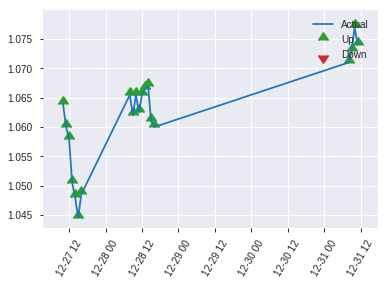


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2553776189989555
RMSE: 0.5053490071217668
LogLoss: 0.7049313433367501
Null degrees of freedom: 222
Residual degrees of freedom: -816
Null deviance: 308.7824388019844
Residual deviance: 314.39937912819056
AIC: 2392.3993791281905
AUC: 0.5065259426361586
pr_auc: 0.5317089926054351
Gini: 0.013051885272317154
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23643945155697504: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    107  1        (107.0/107.0)
1      0    116  0        (0.0/116.0)
Total  0    223  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.236439     0.684366  222
max f2                       0.236439     0.84425   222
max f0point5                 0.236439     0.575397  222
max accuracy                 0.539083     0.524664  83
max precision                0.598266     0.653846  25
max recall                   0.236439     1         222
max specificity              0.777905     0.990654  0
max absolute_mcc             0.43342      0.119836  204
max min_per_class_accuracy   0.516708     0.517241  109
max mean_per_class_accuracy  0.598266     0.53122   25

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 52.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.707138           0.640805  0.640805           0.333333         0.740996  0.333333                    0.740996            0.00862069      0.00862069                 -35.9195  -35.9195
    2        0.0224215                   0.66321            0.961207  0.768966           0.5              0.674175  0.4                         0.714268            0.00862069      0.0172414                  -3.87931  -23.1034
    3        0.0313901                   0.638474           0.961207  0.823892           0.5              0.647331  0.428571                    0.695143            0.00862069      0.0258621                  -3.87931  -17.6108
    4        0.0403587                   0.626436           1.92241   1.06801            1                0.63407   0.555556                    0.681571            0.0172414       0.0431034                  92.2414   6.80077
    5        0.0538117                   0.622603           1.28161   1.12141            0.666667         0.624124  0.583333                    0.667209            0.0172414       0.0603448                  28.1609   12.1408
    6        0.103139                    0.601059           1.22335   1.17016            0.636364         0.613043  0.608696                    0.641304            0.0603448       0.12069                    22.3354   17.0165
    7        0.152466                    0.58613            1.04859   1.13083            0.545455         0.592696  0.588235                    0.625578            0.0517241       0.172414                   4.85893   13.0832
    8        0.201794                    0.573444           0.873824  1.06801            0.454545         0.579804  0.555556                    0.614389            0.0431034       0.215517                   -12.6176  6.80077
    9        0.300448                    0.552598           0.961207  1.03294            0.5              0.560503  0.537313                    0.596695            0.0948276       0.310345                   -3.87931  3.29388
    10       0.399103                    0.533303           1.13597   1.05841            0.590909         0.545385  0.550562                    0.584012            0.112069        0.422414                   13.5972   5.84076
    11       0.502242                    0.515239           0.919415  1.02986            0.478261         0.524585  0.535714                    0.571808            0.0948276       0.517241                   -8.05847  2.98645
    12       0.600897                    0.500837           1.04859   1.03294            0.545455         0.50854   0.537313                    0.561421            0.103448        0.62069                    4.85893   3.29388
    13       0.699552                    0.488321           0.786442  0.998176           0.409091         0.494458  0.519231                    0.551977            0.0775862       0.698276                   -21.3558  -0.182361
    14       0.798206                    0.472144           0.873824  0.982807           0.454545         0.48068   0.511236                    0.543165            0.0862069       0.784483                   -12.6176  -1.71929
    15       0.896861                    0.44049            0.961207  0.980431           0.5              0.462033  0.51                        0.534241            0.0948276       0.87931                    -3.87931  -1.9569
    16       1                           0.236439           1.17016   1                  0.608696         0.396491  0.520179                    0.520033   

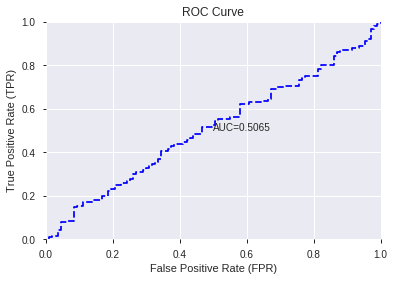

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


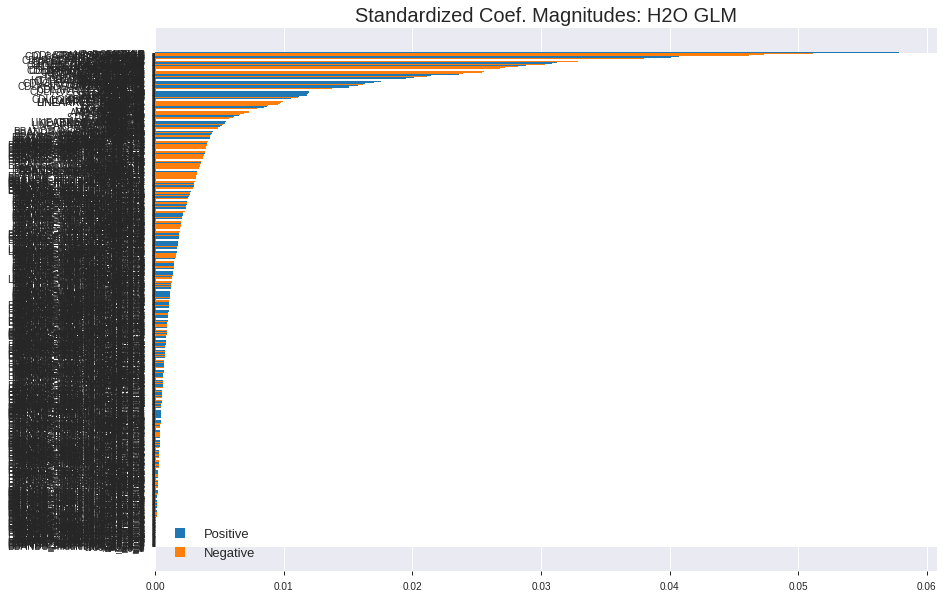

'log_likelihood'
--2019-08-27 14:21:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.97.216
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.97.216|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_142042_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_142042_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

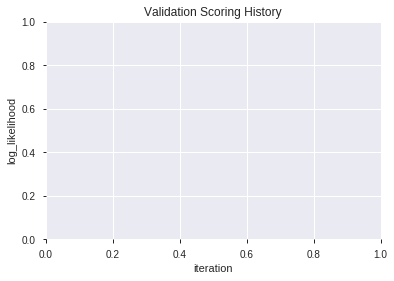

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_142144  0.550193  0.698520              0.500000  0.502590  0.252597
1  XGBoost_grid_1_AutoML_20190827_142144_model_7  0.532549  0.707772              0.500000  0.506512  0.256554
2  XGBoost_grid_1_AutoML_20190827_142144_model_4  0.531018  0.695137              0.500000  0.500945  0.250946
3  XGBoost_grid_1_AutoML_20190827_142144_model_3  0.515147  0.703909              0.480946  0.505047  0.255072
4               XGBoost_2_AutoML_20190827_142144  0.513858  0.710865              0.495327  0.508184  0.258251
5  XGBoost_grid_1_AutoML_20190827_142144_model_6  0.506526  0.706855              0.495327  0.506448  0.256489
6  XGBoost_grid_1_AutoML_20190827_142144_model_2  0.506204  0.703066              0.500000  0.504702  0.254724
7  XGBoost_grid_1_AutoML_20190827_142144_model_1  0.498993  0.714122              0.500000  0.510013  0.260113
8  XGBoost_grid_1_AutoML_20190827_142144_model_5  0.488801  0.742240              0.490292  0.521655  0.272124
9               XGBoost_1_AutoML_20190827_142144  0.485256  0.724168              0.495327  0.514414  0.264622

variable  relative_importance  scaled_importance  percentage
0                         BOP            97.326263           1.000000    0.018031
1                      CCI_12            95.042908           0.976539    0.017608
2                       DX_30            91.101036           0.936038    0.016878
3              STOCHRSI_fastd            89.428513           0.918853    0.016568
4        HT_PHASOR_quadrature            82.719559           0.849920    0.015325
..                        ...                  ...                ...         ...
311  BBANDS_middleband_30_5_2             0.402773           0.004138    0.000075
312         MACDFIX_signal_12             0.323591           0.003325    0.000060
313   BBANDS_upperband_12_4_5             0.163100           0.001676    0.000030
314   BBANDS_lowerband_20_1_2             0.100738           0.001035    0.000019
315   BBANDS_lowerband_20_5_3             0.036095           0.000371    0.000007

[316 rows x 4 columns]

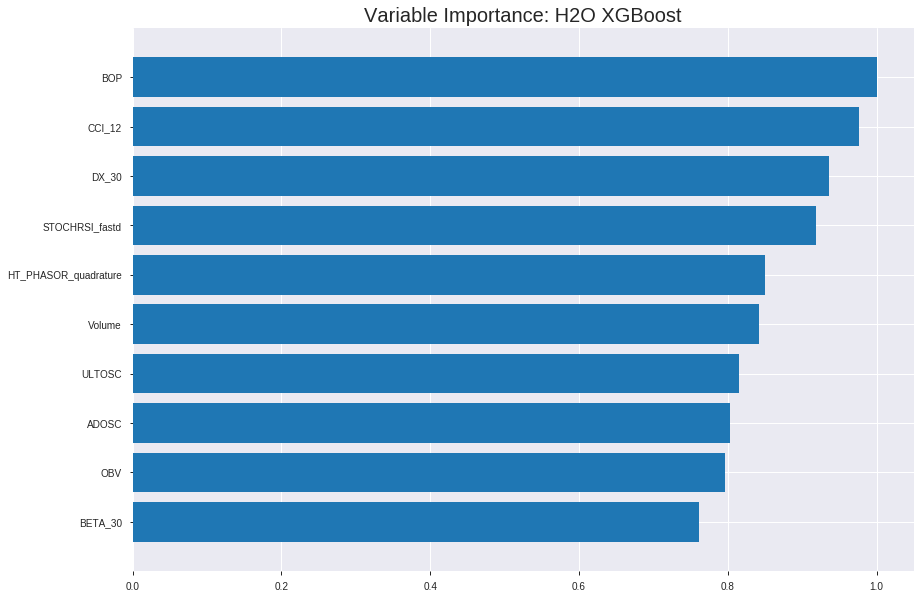

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_142144


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17152760080342802
RMSE: 0.4141589076712319
LogLoss: 0.5311811540066472
Mean Per-Class Error: 0.10454170202980262
AUC: 0.9586470519139109
pr_auc: 0.9611553844964705
Gini: 0.9172941038278217
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5267897397279739: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      669  80   0.1068   (80.0/749.0)
1      83   724  0.1029   (83.0/807.0)
Total  752  804  0.1048   (163.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52679      0.898821  189
max f2                       0.45797      0.924409  249
max f0point5                 0.539461     0.909454  175
max accuracy                 0.528633     0.895244  187
max precision                0.812768     1         0
max recall                   0.377648     1         319
max specificity              0.812768     1         0
max absolute_mcc             0.528633     0.790495  187
max min_per_class_accuracy   0.527807     0.894672  188
max mean_per_class_accuracy  0.528633     0.895458  187

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 51.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.74507            1.92813    1.92813            1                0.775082  1                           0.775082            0.0198265       0.0198265                  92.8129   92.8129
    2        0.0205656                   0.715932           1.92813    1.92813            1                0.727455  1                           0.751269            0.0198265       0.039653                   92.8129   92.8129
    3        0.0302057                   0.70242            1.92813    1.92813            1                0.709615  1                           0.737975            0.0185874       0.0582404                  92.8129   92.8129
    4        0.0404884                   0.696673           1.92813    1.92813            1                0.699607  1                           0.728231            0.0198265       0.0780669                  92.8129   92.8129
    5        0.0501285                   0.690531           1.92813    1.92813            1                0.693127  1                           0.72148             0.0185874       0.0966543                  92.8129   92.8129
    6        0.100257                    0.662676           1.92813    1.92813            1                0.674528  1                           0.698004            0.0966543       0.193309                   92.8129   92.8129
    7        0.150386                    0.643623           1.90341    1.91989            0.987179         0.653873  0.995726                    0.683294            0.0954151       0.288724                   90.3409   91.9889
    8        0.200514                    0.629533           1.92813    1.92195            1                0.636154  0.996795                    0.671509            0.0966543       0.385378                   92.8129   92.1949
    9        0.300129                    0.594971           1.82861    1.89097            0.948387         0.612794  0.980728                    0.652021            0.182156        0.567534                   82.8613   89.097
    10       0.400386                    0.563415           1.73037    1.85076            0.897436         0.580187  0.959872                    0.634034            0.173482        0.741016                   73.0372   85.0756
    11       0.5                         0.530797           1.36835    1.75465            0.709677         0.547181  0.910026                    0.61673             0.136307        0.877323                   36.835    75.4647
    12       0.600257                    0.49124            0.716868   1.58131            0.371795         0.513825  0.820128                    0.599543            0.0718711       0.949195                   -28.3132  58.1313
    13       0.699871                    0.447063           0.348307   1.40582            0.180645         0.467716  0.729109                    0.580779            0.0346964       0.983891                   -65.1693  40.5817
    14       0.800129                    0.400673           0.135958   1.2467             0.0705128        0.424915  0.646586                    0.561249            0.0136307       0.997522                   -86.4042  24.6702
    15       0.899743                    0.352948           0.0248791  1.11143            0.0129032        0.377912  0.576429                    0.540951            0.00247831      1                          -97.5121  11.1429
    16       1                           0.20417            0          1                  0                0.302482  0.518638                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.253032709129876
RMSE: 0.5030235671714358
LogLoss: 0.7000926546457904
Mean Per-Class Error: 0.4503496644837901
AUC: 0.540383216104778
pr_auc: 0.5383904341697234
Gini: 0.08076643220955604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2302316427230835: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    217  1        (217.0/217.0)
1      0    228  0        (0.0/228.0)
Total  0    445  0.4876   (217.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.230232     0.677563  399
max f2                       0.230232     0.840088  399
max f0point5                 0.43757      0.571682  320
max accuracy                 0.540914     0.548315  177
max precision                0.760312     1         0
max recall                   0.230232     1         399
max specificity              0.760312     1         0
max absolute_mcc             0.575059     0.100324  112
max min_per_class_accuracy   0.52757      0.525346  197
max mean_per_class_accuracy  0.540914     0.54965   177

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 51.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.704891           0.780702  0.780702           0.4              0.723501  0.4                         0.723501            0.00877193      0.00877193                 -21.9298   -21.9298
    2        0.0202247                   0.683555           1.46382   1.08431            0.75             0.696762  0.555556                    0.711617            0.0131579       0.0219298                  46.3816    8.4308
    3        0.0314607                   0.667279           0.780702  0.975877           0.4              0.676101  0.5                         0.698933            0.00877193      0.0307018                  -21.9298   -2.41228
    4        0.0404494                   0.662392           1.46382   1.08431            0.75             0.664905  0.555556                    0.691371            0.0131579       0.0438596                  46.3816    8.4308
    5        0.0516854                   0.65628            0.780702  1.01831            0.4              0.659514  0.521739                    0.684446            0.00877193      0.0526316                  -21.9298   1.83066
    6        0.101124                    0.633075           1.06459   1.04094            0.545455         0.644656  0.533333                    0.664993            0.0526316       0.105263                   6.45933    4.09357
    7        0.150562                    0.609729           1.06459   1.0487             0.545455         0.620434  0.537313                    0.650362            0.0526316       0.157895                   6.45933    4.87038
    8        0.2                         0.594782           1.50817   1.16228            0.772727         0.601329  0.595506                    0.638241            0.0745614       0.232456                   50.8174    16.2281
    9        0.301124                    0.569471           1.08431   1.1361             0.555556         0.580404  0.58209                     0.618818            0.109649        0.342105                   8.4308     13.6096
    10       0.4                         0.549968           0.931519  1.08553            0.477273         0.56079   0.55618                     0.604474            0.0921053       0.434211                   -6.84809   8.55263
    11       0.501124                    0.52757            0.910819  1.05027            0.466667         0.538845  0.538117                    0.591231            0.0921053       0.526316                   -8.91813   5.02714
    12       0.6                         0.504685           0.887161  1.02339            0.454545         0.514664  0.524345                    0.578613            0.0877193       0.614035                   -11.2839   2.33918
    13       0.698876                    0.480745           1.06459   1.02922            0.545455         0.493423  0.527331                    0.56656             0.105263        0.719298                   6.45933    2.9221
    14       0.8                         0.448752           0.997563  1.02522            0.511111         0.46736   0.525281                    0.554021            0.100877        0.820175                   -0.243665  2.52193
    15       0.898876                    0.389596           0.842803  1.00515            0.431818         0.421513  0.515                       0.539445            0.0833333       0.903509                   -15.7197   0.515351
    16       1                           0.230232           0.954191  1                  0.488889         0.338662  0.51236                     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:21:56  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.481362                         0.5                0.693147              0.5               0                    1                  0.48764
    2019-08-27 14:21:58  1.245 sec   5                  0.4879           0.669182            0.785857        0.786947           1.68711          0.308483                         0.499506           0.69216               0.532581          0.523982             0                  0.485393
    2019-08-27 14:21:58  1.489 sec   10                 0.477165         0.648272            0.84415         0.843225           1.80762          0.239717                         0.499751           0.692672              0.534229          0.533531             0                  0.476404
    2019-08-27 14:21:58  1.691 sec   15                 0.468038         0.630717            0.872241        0.87603            1.92813          0.212082                         0.498917           0.691018              0.548367          0.548382             0.780702           0.476404
    2019-08-27 14:21:58  1.909 sec   20                 0.456203         0.608257            0.896716        0.901048           1.92813          0.185733                         0.498521           0.690336              0.562232          0.56402              1.5614             0.48764
    2019-08-27 14:21:59  2.111 sec   25                 0.449115         0.594915            0.904546        0.907105           1.92813          0.172237                         0.498861           0.691056              0.559211          0.554507             1.17105            0.478652
    2019-08-27 14:21:59  2.336 sec   30                 0.440921         0.579733            0.92114         0.923496           1.92813          0.153599                         0.498634           0.690637              0.560029          0.552955             1.17105            0.476404
    2019-08-27 14:21:59  2.541 sec   35                 0.435135         0.568963            0.92654         0.930654           1.92813          0.158098                         0.499044           0.69156               0.557978          0.555609             0.780702           0.48764
    2019-08-27 14:21:59  2.737 sec   40                 0.429343         0.558355            0.935838        0.939445           1.92813          0.142031                         0.501133           0.695907              0.546063          0.547632             0.780702           0.476404
    2019-08-27 14:21:59  2.952 sec   45                 0.421343         0.543966            0.948775        0.951862           1.92813          0.125964                         0.502775           0.699407              0.538726          0.537954             0.780702           0.48764
    2019-08-27 14:22:00  3.159 sec   50                 0.414159         0.531181            0.958647        0.961155           1.92813          0.104756                         0.503024           0.700093              0.540383          0.53839              0.780702           0.48764

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ----------------------
BOP                       97.32626342773438      1.0                    0.018031389817300465
CCI_12                    95.04290771484375      0.976539161861628      0.01760835829938689
DX_30                     91.10103607177734      0.9360375387206834     0.01687805774429912
STOCHRSI_fastd            89.42851257324219      0.9188528298905019     0.016568193560485313
HT_PHASOR_quadrature      82.71955871582031      0.8499202147757406     0.015325242706225116
---                       ---                    ---                    ---
BBANDS_middleband_30_5_2  0.402773380279541      0.004138383269780041   7.462080195079844e-05
MACDFIX_signal_12         0.3235912322998047     0.0033248089560129275  5.995092635392089e-05
BBANDS_upperband_12_4_5   0.1631002426147461     0.0016758091482249238  3.021716801104186e-05
BBANDS_lowerband_20_1_2   0.1007375717163086     0.0010350502338056689  1.8663394246238006e-05
BBANDS_lowerband_20_5_3   0.03609466552734375    0.0003708625427107285  6.687167076252388e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5515695067264574)

('F1', 0.6843657817109144)

('auc', 0.5501933612632935)

('logloss', 0.6985196697328888)

('mean_per_class_error', 0.4346600064453754)

('rmse', 0.5025904389383964)

('mse', 0.25259714931229)

xgboost prediction progress: |████████████████████████████████████████████| 100%


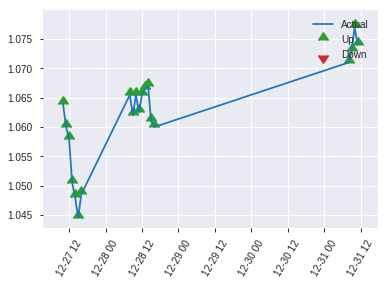


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25259714931229
RMSE: 0.5025904389383964
LogLoss: 0.6985196697328888
Mean Per-Class Error: 0.4346600064453754
AUC: 0.5501933612632935
pr_auc: 0.5768431249709259
Gini: 0.10038672252658709
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35251590609550476: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    107  1        (107.0/107.0)
1      0    116  0        (0.0/116.0)
Total  0    223  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352516     0.684366  222
max f2                       0.352516     0.84425   222
max f0point5                 0.524245     0.581551  157
max accuracy                 0.650076     0.55157   35
max precision                0.755645     1         0
max recall                   0.352516     1         222
max specificity              0.755645     1         0
max absolute_mcc             0.650076     0.177443  35
max min_per_class_accuracy   0.565307     0.523364  111
max mean_per_class_accuracy  0.650076     0.56534   35

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 56.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.726488           1.28161   1.28161            0.666667         0.740354  0.666667                    0.740354            0.0172414       0.0172414                  28.1609   28.1609
    2        0.0224215                   0.706542           0.961207  1.15345            0.5              0.710325  0.6                         0.728342            0.00862069      0.0258621                  -3.87931  15.3448
    3        0.0313901                   0.698232           1.92241   1.37315            1                0.700963  0.714286                    0.720519            0.0172414       0.0431034                  92.2414   37.3153
    4        0.0403587                   0.691783           1.92241   1.49521            1                0.695262  0.777778                    0.714907            0.0172414       0.0603448                  92.2414   49.5211
    5        0.0538117                   0.688691           0.640805  1.28161            0.333333         0.690309  0.666667                    0.708757            0.00862069      0.0689655                  -35.9195  28.1609
    6        0.103139                    0.663564           1.22335   1.25375            0.636364         0.676294  0.652174                    0.693231            0.0603448       0.12931                    22.3354   25.3748
    7        0.152466                    0.65091            1.57288   1.357              0.818182         0.655048  0.705882                    0.680878            0.0775862       0.206897                   57.2884   35.6998
    8        0.201794                    0.644398           0.873824  1.23889            0.454545         0.646995  0.644444                    0.672595            0.0431034       0.25                       -12.6176  23.8889
    9        0.300448                    0.611836           0.873824  1.11902            0.454545         0.628643  0.58209                     0.658163            0.0862069       0.336207                   -12.6176  11.9017
    10       0.399103                    0.592961           1.13597   1.12321            0.590909         0.60299   0.58427                     0.644525            0.112069        0.448276                   13.5972   12.3208
    11       0.502242                    0.565307           0.752249  1.04703            0.391304         0.581872  0.544643                    0.631659            0.0775862       0.525862                   -24.7751  4.70289
    12       0.600897                    0.541801           1.04859   1.04729            0.545455         0.556013  0.544776                    0.619239            0.103448        0.62931                    4.85893   4.72851
    13       0.699552                    0.524485           1.04859   1.04747            0.545455         0.532019  0.544872                    0.606939            0.103448        0.732759                   4.85893   4.74691
    14       0.798206                    0.500328           0.786442  1.01521            0.409091         0.514864  0.52809                     0.595559            0.0775862       0.810345                   -21.3558  1.52073
    15       0.896861                    0.463364           0.611677  0.970819           0.318182         0.484002  0.505                       0.583287            0.0603448       0.87069                    -38.8323  -2.9181
    16       1                           0.352516           1.25375   1                  0.652174         0.433405  0.520179                    0.567829         

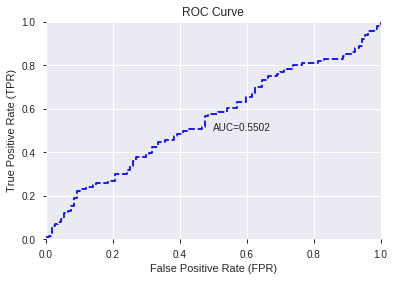

This function is available for GLM models only


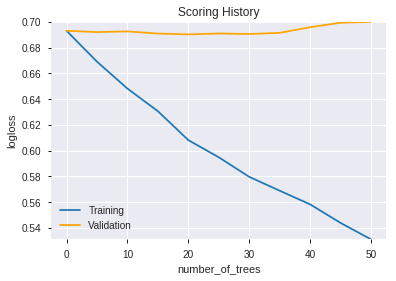

--2019-08-27 14:22:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_142144',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_142144',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_bac4',
   'type

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_142244_model_4  0.548824  0.970058              0.495327  0.560697  0.314381
1               DeepLearning_1_AutoML_20190827_142244  0.546810  0.775507              0.494965  0.526330  0.277024
2  DeepLearning_grid_1_AutoML_20190827_142244_model_9  0.541089  0.692654              0.495327  0.499753  0.249753
3  DeepLearning_grid_1_AutoML_20190827_142244_model_1  0.519336  1.077412              0.495327  0.582352  0.339134
4  DeepLearning_grid_1_AutoML_20190827_142244_model_5  0.518369  0.746387              0.500000  0.523639  0.274198
5  DeepLearning_grid_1_AutoML_20190827_142244_model_3  0.517886  0.938818              0.500000  0.566924  0.321403
6  DeepLearning_grid_1_AutoML_20190827_142244_model_6  0.517725  0.729374              0.490292  0.516953  0.267240
7  DeepLearning_grid_1_AutoML_20190827_142244_model_7  0.516516  0.728216              0.490292  0.514839  0.265059
8  DeepLearning_grid_1_AutoML_20190827_142244_model_2  0.500886  0.994124              0.500000  0.575809  0.331556
9  DeepLearning_grid_1_AutoML_20190827_142244_model_8  0.495327  0.692351              0.500000  0.499602  0.249602

variable  relative_importance  scaled_importance  percentage
0          days_in_month             1.000000           1.000000    0.024406
1                    SUB             0.993690           0.993690    0.024252
2                    BOP             0.980243           0.980243    0.023924
3                    OBV             0.974463           0.974463    0.023783
4              CORREL_24             0.950089           0.950089    0.023188
5                 SAREXT             0.948672           0.948672    0.023154
6            HT_DCPERIOD             0.926574           0.926574    0.022614
7                BETA_12             0.900513           0.900513    0.021978
8           HT_TRENDMODE             0.895634           0.895634    0.021859
9                 BETA_8             0.888542           0.888542    0.021686
10        STOCHRSI_fastd             0.881417           0.881417    0.021512
11              CORREL_8             0.870530           0.870530    0.021247
12                ADX_12             0.836981           0.836981    0.020428
13               BETA_20             0.834650           0.834650    0.020371
14          aroondown_20             0.818370           0.818370    0.019974
15            aroonup_20             0.815370           0.815370    0.019900
16  HT_PHASOR_quadrature             0.812725           0.812725    0.019836
17           MINUS_DI_24             0.809591           0.809591    0.019759
18                ADXR_8             0.808155           0.808155    0.019724
19          STOCHF_fastk             0.805949           0.805949    0.019670
20            PLUS_DM_30             0.805445           0.805445    0.019658
21                 DX_12             0.804924           0.804924    0.019645
22             aroonup_8             0.802016           0.802016    0.019574
23                ROC_12             0.801091           0.801091    0.019552
24                MFI_24             0.795852           0.795852    0.019424
25               WILLR_8             0.794519           0.794519    0.019391
26              WILLR_12             0.790938           0.790938    0.019304
27        STOCHRSI_fastk             0.788151           0.788151    0.019236
28                 DX_20             0.787552           0.787552    0.019221
29           AROONOSC_30             0.787038           0.787038    0.019209
30            aroonup_30             0.786499           0.786499    0.019196
31           STOCH_slowk             0.779105           0.779105    0.019015
32                 ROC_8             0.775723           0.775723    0.018933
33             dayofweek             0.775355           0.775355    0.018924
34       MACDFIX_hist_12             0.773675           0.773675    0.018883
35                 CCI_8             0.773368           0.773368    0.018875
36           STOCH_slowd             0.770337           0.770337    0.018801
37             CORREL_14             0.768590           0.768590    0.018759
38    LINEARREG_SLOPE_24             0.766051           0.766051    0.018697
39          STOCHF_fastd             0.765525           0.765525    0.018684
40                CCI_12             0.765212           0.765212    0.018676
41            MACDFIX_20             0.764750           0.764750    0.018665
42              WILLR_14             0.764738           0.764738    0.018665
43            PLUS_DM_24             0.764097           0.764097    0.018649
44           MINUS_DI_30             0.762072           0.762072    0.018600
45               weekday             0.760628           0.760628    0.018564
46                 DX_14             0.744654           0.744654    0.018174
47           AROONOSC_24             0.740005           0.740005    0.018061
48                 CMO_8             0.739517           0.739517    0.018049
49     MACDFIX_signal_12             0.723125           0.723125    0.017649

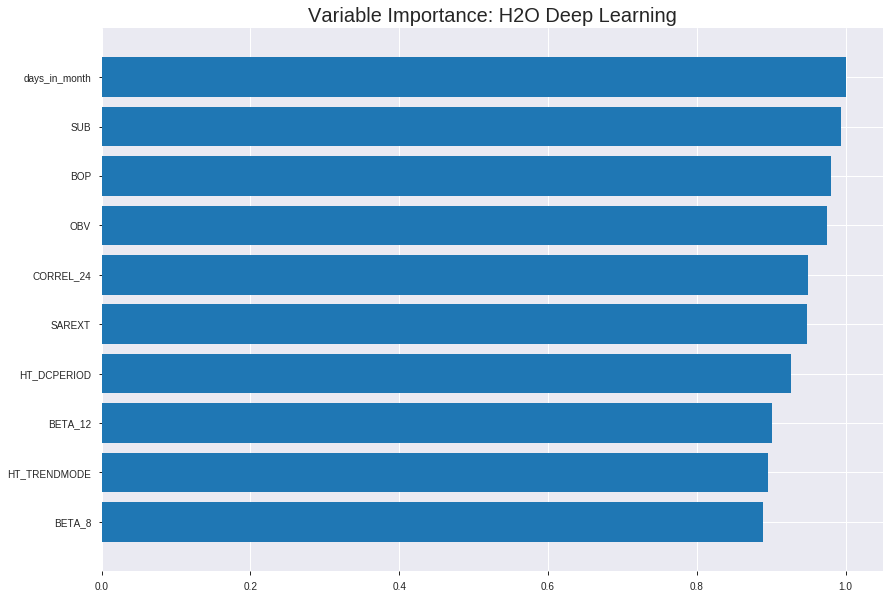

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_142244_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.16869317578609883
RMSE: 0.41072274807477954
LogLoss: 0.5075415309555583
Mean Per-Class Error: 0.2293499966084478
AUC: 0.8478797835362474
pr_auc: 0.8607414887745068
Gini: 0.6957595670724948
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24307584787184836: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      461  288  0.3845   (288.0/749.0)
1      105  702  0.1301   (105.0/807.0)
Total  566  990  0.2526   (393.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243076     0.781302  286
max f2                       0.109106     0.871018  344
max f0point5                 0.441754     0.796196  209
max accuracy                 0.354323     0.771208  244
max precision                0.998321     1         0
max recall                   0.00701608   1         397
max specificity              0.998321     1         0
max absolute_mcc             0.441754     0.541654  209
max min_per_class_accuracy   0.375214     0.765799  236
max mean_per_class_accuracy  0.354323     0.77065   244

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 42.77 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.988012           1.92813   1.92813            1                0.992921   1                           0.992921            0.0198265       0.0198265                  92.8129   92.8129
    2        0.0205656                   0.980756           1.92813   1.92813            1                0.984266   1                           0.988594            0.0198265       0.039653                   92.8129   92.8129
    3        0.0302057                   0.970138           1.92813   1.92813            1                0.975693   1                           0.984476            0.0185874       0.0582404                  92.8129   92.8129
    4        0.0404884                   0.955826           1.92813   1.92813            1                0.962508   1                           0.978897            0.0198265       0.0780669                  92.8129   92.8129
    5        0.0501285                   0.941246           1.92813   1.92813            1                0.948167   1                           0.972987            0.0185874       0.0966543                  92.8129   92.8129
    6        0.100257                    0.891389           1.82925   1.87869            0.948718         0.917416   0.974359                    0.945202            0.0916976       0.188352                   82.925    87.869
    7        0.150386                    0.828652           1.77981   1.84573            0.923077         0.861516   0.957265                    0.917306            0.0892193       0.277571                   77.9811   84.573
    8        0.200514                    0.760547           1.65621   1.79835            0.858974         0.790788   0.932692                    0.885677            0.0830235       0.360595                   65.6213   79.8351
    9        0.300129                    0.629464           1.53006   1.7093             0.793548         0.69357    0.88651                     0.821915            0.152416        0.513011                   53.0064   70.9305
    10       0.400386                    0.485526           1.35958   1.62173            0.705128         0.558824   0.841091                    0.756037            0.136307        0.649318                   35.9578   62.1733
    11       0.5                         0.380506           1.0698    1.51177            0.554839         0.428092   0.784062                    0.690701            0.106568        0.755886                   6.98005   51.1772
    12       0.600257                    0.275965           0.828107  1.39758            0.429487         0.325704   0.724839                    0.629738            0.0830235       0.83891                    -17.1893  39.7584
    13       0.699871                    0.187452           0.659296  1.2925             0.341935         0.2307     0.67034                     0.572942            0.0656753       0.904585                   -34.0704  29.2501
    14       0.800129                    0.113186           0.580911  1.20334            0.301282         0.150767   0.624096                    0.520043            0.0582404       0.962825                   -41.9089  20.3338
    15       0.899743                    0.0577027          0.248791  1.09766            0.129032         0.0848298  0.569286                    0.471858            0.0247831       0.987608                   -75.1209  9.76562
    16       1                           0.00193996         0.123598  1                  0.0641026        0.0318885  0.518638                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.32381590776681696
RMSE: 0.5690482473102056
LogLoss: 0.9695742016604759
Mean Per-Class Error: 0.4338366076481527
AUC: 0.5437990136631902
pr_auc: 0.5409447954881483
Gini: 0.08759802732638033
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.031296652192334976: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    209  0.9631   (209.0/217.0)
1      2    226  0.0088   (2.0/228.0)
Total  10   435  0.4742   (211.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0312967    0.68175   391
max f2                       0.0061276    0.841328  398
max f0point5                 0.346541     0.584615  243
max accuracy                 0.351291     0.568539  241
max precision                0.993245     0.75      3
max recall                   0.0061276    1         398
max specificity              0.997824     0.995392  0
max absolute_mcc             0.346541     0.134915  243
max min_per_class_accuracy   0.487902     0.539171  201
max mean_per_class_accuracy  0.351291     0.566163  241

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.990267           1.17105   1.17105            0.6              0.995034   0.6                         0.995034            0.0131579       0.0131579                  17.1053    17.1053
    2        0.0202247                   0.982457           1.46382   1.30117            0.75             0.986162   0.666667                    0.991091            0.0131579       0.0263158                  46.3816    30.117
    3        0.0314607                   0.964654           0.780702  1.11529            0.4              0.972161   0.571429                    0.98433             0.00877193      0.0350877                  -21.9298   11.5288
    4        0.0404494                   0.955935           0.975877  1.08431            0.5              0.958148   0.555556                    0.978512            0.00877193      0.0438596                  -2.41228   8.4308
    5        0.0516854                   0.947648           0.390351  0.933448           0.2              0.950871   0.478261                    0.972503            0.00438596      0.0482456                  -60.9649   -6.65523
    6        0.101124                    0.923717           1.24203   1.08431            0.636364         0.933895   0.555556                    0.953628            0.0614035       0.109649                   24.2026    8.4308
    7        0.150562                    0.891517           1.24203   1.1361             0.636364         0.909488   0.58209                     0.939134            0.0614035       0.171053                   24.2026    13.6096
    8        0.2                         0.859824           1.06459   1.11842            0.545455         0.877808   0.573034                    0.923975            0.0526316       0.223684                   6.45933    11.8421
    9        0.301124                    0.730324           0.997563  1.07783            0.511111         0.798833   0.552239                    0.881949            0.100877        0.324561                   -0.243665  7.78345
    10       0.4                         0.615333           0.931519  1.04167            0.477273         0.664387   0.533708                    0.82817             0.0921053       0.416667                   -6.84809   4.16667
    11       0.501124                    0.487902           1.21442   1.07653            0.622222         0.550877   0.55157                     0.772214            0.122807        0.539474                   21.4425    7.65282
    12       0.6                         0.347661           1.24203   1.1038             0.636364         0.413858   0.565543                    0.713159            0.122807        0.662281                   24.2026    10.3801
    13       0.698876                    0.244365           0.709729  1.04805            0.363636         0.297271   0.536977                    0.65432             0.0701754       0.732456                   -29.0271   4.80482
    14       0.8                         0.157167           0.824074  1.01974            0.422222         0.200333   0.522472                    0.596934            0.0833333       0.815789                   -17.5926   1.97368
    15       0.898876                    0.0893711          0.931519  1.01003            0.477273         0.124285   0.5175                      0.544942            0.0921053       0.907895                   -6.84809   1.00329
    16       1                           0.00324128         0.910819  1                  0.466667         0.0500559  0.51236     


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:24:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:24:36  4.870 sec         357 obs/sec       1         1             1556       0.676371         4.22318             -0.832457      0.528145        0.545398           1.20508          0.481362                         0.664959           4.07775               -0.769765        0.545598          0.550615             1.17105            0.478652
    2019-08-27 14:24:43  12.133 sec        419 obs/sec       3         3             4668       0.671163         3.29173             -0.804348      0.540483        0.558807           1.4461           0.481362                         0.656232           3.15151               -0.723617        0.534077          0.559093             1.5614             0.47191
    2019-08-27 14:24:49  18.009 sec        470 obs/sec       5         5             7780       0.638595         2.11225             -0.633485      0.56626         0.58429            1.4461           0.481362                         0.635167           2.08431               -0.614734        0.533723          0.554765             1.5614             0.480899
    2019-08-27 14:24:54  23.080 sec        514 obs/sec       7         7             10892      0.606393         1.4519              -0.472895      0.575781        0.601084           1.68711          0.467224                         0.616996           1.42832               -0.523667        0.538888          0.549584             0.390351           0.480899
    2019-08-27 14:25:00  29.483 sec        574 obs/sec       10        10            15560      0.56782          1.14764             -0.291471      0.630781        0.647183           1.80762          0.442159                         0.600034           1.31508               -0.441043        0.543556          0.56067              1.17105            0.469663
    2019-08-27 14:25:06  34.973 sec        629 obs/sec       13        13            20228      0.524777         0.881426            -0.103094      0.66934         0.687118           1.92813          0.405527                         0.602441           1.22832               -0.452627        0.540818          0.551046             1.5614             0.469663
    2019-08-27 14:25:12  41.332 sec        696 obs/sec       17        17            26452      0.499541         0.764922            0.00044663     0.724168        0.742377           1.92813          0.346401                         0.594243           1.12193               -0.413362        0.528681          0.547082             1.5614             0.467416
    2019-08-27 14:25:18  46.960 sec        756 obs/sec       21        21            32676      0.453162         0.613591            0.177432       0.776544        0.787004           1.92813          0.307198                         0.581475           1.04984               -0.35328         0.53813           0.541765             1.17105            0.476404
    2019-08-27 14:25:23 

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
days_in_month      1.0                    1.0                  0.0244064899083373
SUB                0.993690013885498      0.993690013885498    0.024252485295911962
BOP                0.9802425503730774     0.9802425503730774   0.023924279913403332
OBV                0.974463164806366      0.974463164806366    0.023783225397893
CORREL_24          0.9500892162322998     0.9500892162322998   0.023188342867993723
---                ---                    ---                  ---
weekday            0.7606281638145447     0.7606281638145447   0.018564263604136818
DX_14              0.7446542978286743     0.7446542978286743   0.01817439760515554
AROONOSC_24        0.7400045990943909     0.7400045990943909   0.01806091477992044
CMO_8              0.7395166158676147     0.7395166158676147   0.01804900482222069
MACDFIX_signal_12  0.7231248617172241     0.7231248617172241   0.017648939639969236


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5739910313901345)

('F1', 0.6863905325443787)

('auc', 0.5488237189816307)

('logloss', 0.970057871791277)

('mean_per_class_error', 0.41637125362552374)

('rmse', 0.5606966332224851)

('mse', 0.31438071450703)

deeplearning prediction progress: |███████████████████████████████████████| 100%


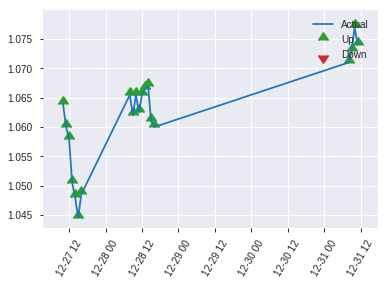


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.31438071450703
RMSE: 0.5606966332224851
LogLoss: 0.970057871791277
Mean Per-Class Error: 0.41637125362552374
AUC: 0.5488237189816307
pr_auc: 0.5646362427216702
Gini: 0.09764743796326147
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.006146452349624741: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    106  0.9907   (106.0/107.0)
1      0    116  0        (0.0/116.0)
Total  1    222  0.4753   (106.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00614645   0.686391  221
max f2                       0.00614645   0.845481  221
max f0point5                 0.426729     0.578125  130
max accuracy                 0.729151     0.573991  58
max precision                0.969191     0.75      7
max recall                   0.00614645   1         221
max specificity              0.993946     0.990654  0
max absolute_mcc             0.729151     0.189434  58
max min_per_class_accuracy   0.508884     0.517241  106
max mean_per_class_accuracy  0.729151     0.583629  58

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 48.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.983696           0.640805  0.640805           0.333333         0.988463   0.333333                    0.988463            0.00862069      0.00862069                 -35.9195  -35.9195
    2        0.0224215                   0.977586           1.92241   1.15345            1                0.980505   0.6                         0.98528             0.0172414       0.0258621                  92.2414   15.3448
    3        0.0313901                   0.96961            1.92241   1.37315            1                0.972379   0.714286                    0.981594            0.0172414       0.0431034                  92.2414   37.3153
    4        0.0403587                   0.957922           0.961207  1.28161            0.5              0.965591   0.666667                    0.978038            0.00862069      0.0517241                  -3.87931  28.1609
    5        0.0538117                   0.951993           0.640805  1.12141            0.333333         0.954591   0.583333                    0.972176            0.00862069      0.0603448                  -35.9195  12.1408
    6        0.103139                    0.911743           1.04859   1.08658            0.545455         0.934115   0.565217                    0.953973            0.0517241       0.112069                   4.85893   8.65817
    7        0.152466                    0.865128           1.57288   1.24391            0.818182         0.880485   0.647059                    0.930198            0.0775862       0.189655                   57.2884   24.3915
    8        0.201794                    0.810562           1.22335   1.23889            0.636364         0.84031    0.644444                    0.908225            0.0603448       0.25                       22.3354   23.8889
    9        0.300448                    0.691892           1.04859   1.1764             0.545455         0.747828   0.61194                     0.855558            0.103448        0.353448                   4.85893   17.6402
    10       0.399103                    0.582699           0.961207  1.12321            0.5              0.635643   0.58427                     0.801197            0.0948276       0.448276                   -3.87931  12.3208
    11       0.502242                    0.497592           0.668666  1.02986            0.347826         0.53529    0.535714                    0.746591            0.0689655       0.517241                   -33.1334  2.98645
    12       0.600897                    0.383568           1.22335   1.06163            0.636364         0.454601   0.552239                    0.698652            0.12069         0.637931                   22.3354   6.16315
    13       0.699552                    0.274812           0.69906   1.0105             0.363636         0.319373   0.525641                    0.645164            0.0689655       0.706897                   -30.094   1.04996
    14       0.798206                    0.1697             0.873824  0.993607           0.454545         0.213295   0.516854                    0.591787            0.0862069       0.793103                   -12.6176  -0.639287
    15       0.896861                    0.0659628          1.04859   0.999655           0.545455         0.115692   0.52                        0.539417            0.103448        0.896552                   4.85893   -0.0344828
    16       1                           0.00404399         1.003     1                  0.521739         0.0370191  0.520179             

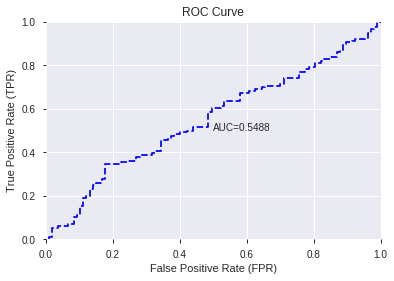

This function is available for GLM models only


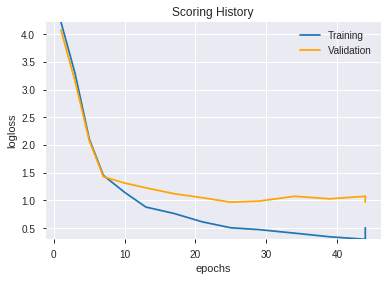

--2019-08-27 14:29:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.187
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.187|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_142244_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_142244_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['days_in_month',
 'SUB',
 'BOP',
 'OBV',
 'CORREL_24',
 'SAREXT',
 'HT_DCPERIOD',
 'BETA_12',
 'HT_TRENDMODE',
 'BETA_8',
 'STOCHRSI_fastd',
 'CORREL_8',
 'ADX_12',
 'BETA_20',
 'aroondown_20',
 'aroonup_20',
 'HT_PHASOR_quadrature',
 'MINUS_DI_24',
 'ADXR_8',
 'STOCHF_fastk',
 'PLUS_DM_30',
 'DX_12',
 'aroonup_8',
 'ROC_12',
 'MFI_24',
 'WILLR_8',
 'WILLR_12',
 'STOCHRSI_fastk',
 'DX_20',
 'AROONOSC_30',
 'aroonup_30',
 'STOCH_slowk',
 'ROC_8',
 'dayofweek',
 'MACDFIX_hist_12',
 'CCI_8',
 'STOCH_slowd',
 'CORREL_14',
 'LINEARREG_SLOPE_24',
 'STOCHF_fastd',
 'CCI_12',
 'MACDFIX_20',
 'WILLR_14',
 'PLUS_DM_24',
 'MINUS_DI_30',
 'weekday',
 'DX_14',
 'AROONOSC_24',
 'CMO_8',
 'MACDFIX_signal_12']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_142954_model_1  0.52699  0.697278                   0.5  0.502001  0.252005

variable  relative_importance  scaled_importance  percentage
0                  DX_12             0.234497           1.000000    0.070350
1                 CCI_12             0.231435           0.986942    0.069431
2                  DX_20             0.192561           0.821167    0.057769
3             aroonup_30             0.170617           0.727586    0.051186
4               WILLR_14             0.154951           0.660781    0.046486
5            HT_DCPERIOD             0.147379           0.628488    0.044214
6            AROONOSC_24             0.140751           0.600225    0.042226
7                 MFI_24             0.131925           0.562588    0.039578
8                 SAREXT             0.120906           0.515597    0.036272
9                    OBV             0.099680           0.425082    0.029904
10          STOCHF_fastk             0.097954           0.417718    0.029386
11                   BOP             0.096565           0.411798    0.028970
12           MINUS_DI_30             0.090575           0.386254    0.027173
13                BETA_8             0.089629           0.382217    0.026889
14               BETA_20             0.082569           0.352110    0.024771
15        STOCHRSI_fastd             0.081265           0.346549    0.024380
16               BETA_12             0.079265           0.338020    0.023780
17                 CCI_8             0.077583           0.330848    0.023275
18        STOCHRSI_fastk             0.077503           0.330505    0.023251
19                 DX_14             0.074822           0.319074    0.022447
20           MINUS_DI_24             0.069176           0.294996    0.020753
21               WILLR_8             0.058930           0.251305    0.017679
22          HT_TRENDMODE             0.056610           0.241411    0.016983
23             aroonup_8             0.050671           0.216085    0.015202
24             CORREL_14             0.049367           0.210521    0.014810
25          STOCHF_fastd             0.045864           0.195586    0.013759
26           STOCH_slowk             0.043090           0.183755    0.012927
27       MACDFIX_hist_12             0.042934           0.183091    0.012880
28              CORREL_8             0.040877           0.174317    0.012263
29  HT_PHASOR_quadrature             0.040508           0.172746    0.012153
30            PLUS_DM_24             0.034142           0.145598    0.010243
31                   SUB             0.032681           0.139368    0.009805
32                ADXR_8             0.032130           0.137015    0.009639
33          aroondown_20             0.029957           0.127751    0.008987
34                 ROC_8             0.029311           0.124994    0.008793
35             CORREL_24             0.028685           0.122327    0.008606
36            MACDFIX_20             0.026577           0.113335    0.007973
37           STOCH_slowd             0.025806           0.110048    0.007742
38                ROC_12             0.024916           0.106253    0.007475
39                 CMO_8             0.017404           0.074217    0.005221
40     MACDFIX_signal_12             0.014771           0.062990    0.004431
41           AROONOSC_30             0.014765           0.062964    0.004430
42            PLUS_DM_30             0.012692           0.054124    0.003808
43             dayofweek             0.011150           0.047547    0.003345
44               weekday             0.011122           0.047428    0.003337
45                ADX_12             0.007169           0.030570    0.002151
46    LINEARREG_SLOPE_24             0.004501           0.019195    0.001350
47         days_in_month             0.003975           0.016949    0.001192
48              WILLR_12             0.000766           0.003267    0.000230
49            aroonup_20             0.000323           0.001377    0.000097

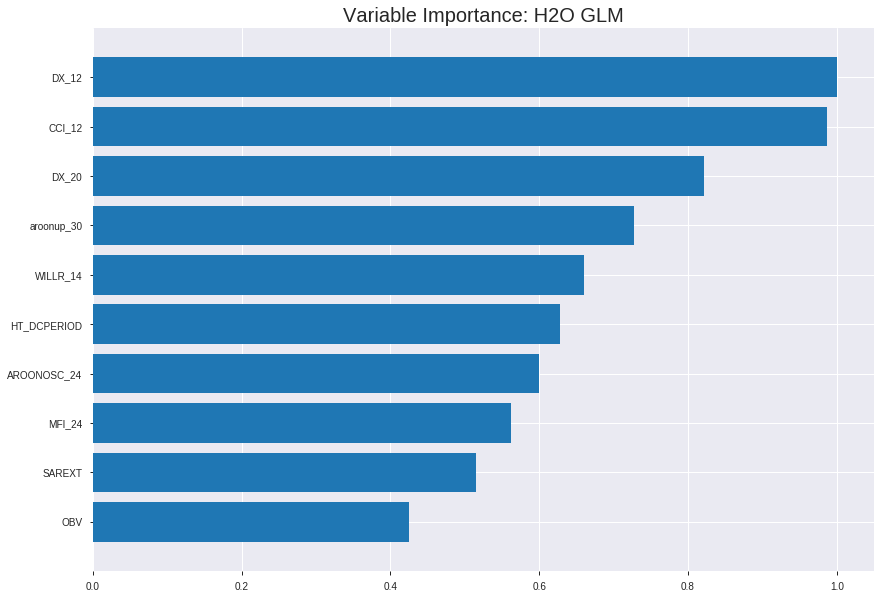

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_142954_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24161145966210035
RMSE: 0.49153988613550004
LogLoss: 0.6761133966665747
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2154.9115712492066
Residual deviance: 2104.0648904263803
AIC: 2206.0648904263803
AUC: 0.6028790142329384
pr_auc: 0.6062344471983971
Gini: 0.20575802846587687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.41481179126063783: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      91   658   0.8785   (658.0/749.0)
1      33   774   0.0409   (33.0/807.0)
Total  124  1432  0.4441   (691.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.414812     0.69138   338
max f2                       0.331932     0.843626  393
max f0point5                 0.502402     0.596998  220
max accuracy                 0.514464     0.579692  201
max precision                0.725521     1         0
max recall                   0.283488     1         398
max specificity              0.725521     1         0
max absolute_mcc             0.514464     0.157822  201
max min_per_class_accuracy   0.517519     0.574969  195
max mean_per_class_accuracy  0.514464     0.578867  201

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 51.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.681243           1.5666    1.5666             0.8125           0.703278  0.8125                      0.703278            0.016109        0.016109                   56.6605   56.6605
    2        0.0205656                   0.65531            1.08457   1.32559            0.5625           0.668483  0.6875                      0.68588             0.0111524       0.0272615                  8.45725   32.5589
    3        0.0302057                   0.64877            1.15688   1.27174            0.6              0.652015  0.659574                    0.675072            0.0111524       0.0384139                  15.6877   27.1745
    4        0.0404884                   0.640405           1.08457   1.22421            0.5625           0.643828  0.634921                    0.667137            0.0111524       0.0495663                  8.45725   22.4209
    5        0.0501285                   0.632872           1.15688   1.21126            0.6              0.636849  0.628205                    0.661313            0.0111524       0.0607187                  15.6877   21.126
    6        0.100257                    0.610385           1.55733   1.3843             0.807692         0.620557  0.717949                    0.640935            0.0780669       0.138786                   55.7335   38.4298
    7        0.150386                    0.594508           1.16182   1.31014            0.602564         0.601913  0.679487                    0.627928            0.0582404       0.197026                   16.1821   31.0139
    8        0.200514                    0.582121           1.06294   1.24834            0.551282         0.58882   0.647436                    0.618151            0.0532838       0.25031                    6.29428   24.834
    9        0.300129                    0.558851           1.14444   1.21385            0.593548         0.56946   0.62955                     0.60199             0.114002        0.364312                   14.4438   21.3854
    10       0.400386                    0.5367             1.00114   1.16059            0.519231         0.547267  0.601926                    0.588287            0.100372        0.464684                   0.114384  16.0591
    11       0.5                         0.517454           1.08224   1.14498            0.56129          0.52707   0.59383                     0.576091            0.107807        0.572491                   8.22401   14.4981
    12       0.600257                    0.501688           0.988784  1.11889            0.512821         0.509786  0.5803                      0.565017            0.0991326       0.671623                   -1.1216   11.8893
    13       0.699871                    0.482447           0.870768  1.08358            0.451613         0.492114  0.561983                    0.55464             0.086741        0.758364                   -12.9232  8.35766
    14       0.800129                    0.460608           0.840466  1.05311            0.435897         0.47141   0.546185                    0.544211            0.0842627       0.842627                   -15.9534  5.31146
    15       0.899743                    0.424077           0.957845  1.04257            0.496774         0.444246  0.540714                    0.533144            0.0954151       0.938042                   -4.21553  4.25668
    16       1                           0.278692           0.61799   1                  0.320513         0.388454  0.518638                    0.518638           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24601675960152491
RMSE: 0.4960007657267526
LogLoss: 0.6853015122109968
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 616.6992856395483
Residual deviance: 609.9183458677871
AIC: 711.9183458677871
AUC: 0.5826562373676126
pr_auc: 0.5831734680712265
Gini: 0.16531247473522526
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36899373738597335: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    212  0.977    (212.0/217.0)
1      1    227  0.0044   (1.0/228.0)
Total  6    439  0.4787   (213.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.368994     0.68066   393
max f2                       0.353447     0.84195   396
max f0point5                 0.540273     0.582437  196
max accuracy                 0.542025     0.573034  193
max precision                0.7956       1         0
max recall                   0.353447     1         396
max specificity              0.7956       1         0
max absolute_mcc             0.594674     0.161909  89
max min_per_class_accuracy   0.540273     0.570175  196
max mean_per_class_accuracy  0.558512     0.57347   159

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 53.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.757805           1.17105   1.17105            0.6              0.773746  0.6                         0.773746            0.0131579       0.0131579                  17.1053    17.1053
    2        0.0202247                   0.715598           1.46382   1.30117            0.75             0.745742  0.666667                    0.7613              0.0131579       0.0263158                  46.3816    30.117
    3        0.0314607                   0.697595           0.780702  1.11529            0.4              0.708098  0.571429                    0.742299            0.00877193      0.0350877                  -21.9298   11.5288
    4        0.0404494                   0.678298           1.46382   1.19274            0.75             0.684978  0.611111                    0.729561            0.0131579       0.0482456                  46.3816    19.2739
    5        0.0516854                   0.671487           1.17105   1.18802            0.6              0.674997  0.608696                    0.717699            0.0131579       0.0614035                  17.1053    18.8024
    6        0.101124                    0.638302           1.33074   1.2578             0.681818         0.651145  0.644444                    0.685162            0.0657895       0.127193                   33.0742    25.7797
    7        0.150562                    0.607897           1.41946   1.31088            0.727273         0.623359  0.671642                    0.664868            0.0701754       0.197368                   41.9458    31.088
    8        0.2                         0.597497           1.24203   1.29386            0.636364         0.603433  0.662921                    0.649682            0.0614035       0.258772                   24.2026    29.386
    9        0.301124                    0.57588            0.997563  1.19436            0.511111         0.58656   0.61194                     0.628484            0.100877        0.359649                   -0.243665  19.4357
    10       0.4                         0.558095           1.10895   1.17325            0.568182         0.565407  0.601124                    0.612892            0.109649        0.469298                   10.8951    17.3246
    11       0.501124                    0.540004           0.997563  1.13779            0.511111         0.548623  0.58296                     0.599923            0.100877        0.570175                   -0.243665  13.7794
    12       0.6                         0.522915           0.798445  1.08187            0.409091         0.531515  0.554307                    0.58865             0.0789474       0.649123                   -20.1555   8.18713
    13       0.698876                    0.499844           0.887161  1.05432            0.454545         0.512497  0.540193                    0.577876            0.0877193       0.736842                   -11.2839   5.43239
    14       0.8                         0.473349           0.867446  1.0307             0.444444         0.486712  0.52809                     0.566352            0.0877193       0.824561                   -13.2554   3.07018
    15       0.898876                    0.439207           0.931519  1.01979            0.477273         0.457587  0.5225                      0.554388            0.0921053       0.916667                   -6.84809   1.97917
    16       1                           0.332817           0.824074  1                  0.422222         0.405027  0.51236                     0.5


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 14:29:55  0.000 sec   2            2.8       51            1.38166           1.38293
    2019-08-27 14:29:55  0.022 sec   4            1.7       51            1.38026           1.38194
    2019-08-27 14:29:55  0.039 sec   6            1.1       51            1.37847           1.38081
    2019-08-27 14:29:55  0.053 sec   8            0.67      51            1.37627           1.37959
    2019-08-27 14:29:55  0.069 sec   10           0.42      51            1.37368           1.37828
    2019-08-27 14:29:55  0.088 sec   12           0.26      51            1.37071           1.37688
    2019-08-27 14:29:55  0.105 sec   14           0.16      51            1.36741           1.37538
    2019-08-27 14:29:55  0.118 sec   16           0.1       51            1.36398           1.37391
    2019-08-27 14:29:55  0.134 sec   18           0.062     51            1.36057           1.37257
    2019-08-27 14:29:55  0.147 sec   20           0.038     51            1.35738           1.37151
    2019-08-27 14:29:55  0.161 sec   22           0.024     51            1.35457           1.37083
    2019-08-27 14:29:55  0.173 sec   24           0.015     51            1.35223           1.3706
    2019-08-27 14:29:55  0.184 sec   26           0.0092    51            1.35038           1.37075
    2019-08-27 14:29:55  0.199 sec   28           0.0057    51            1.34902           1.37124
    2019-08-27 14:29:55  0.212 sec   30           0.0036    51            1.34806           1.37207
    2019-08-27 14:29:55  0.224 sec   32           0.0022    51            1.34741           1.37329
    2019-08-27 14:29:55  0.231 sec   33           0.0014    51            1.34693           1.37492

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5381165919282511)

('F1', 0.6843657817109144)

('auc', 0.5269900096680632)

('logloss', 0.6972782907550755)

('mean_per_class_error', 0.4613680309378021)

('rmse', 0.5020006126786115)

('mse', 0.2520046151297013)

glm prediction progress: |████████████████████████████████████████████████| 100%


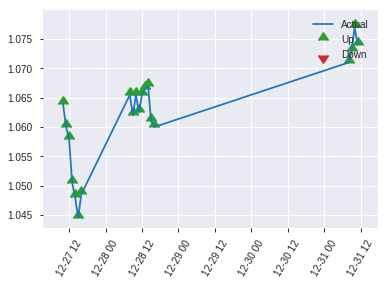


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2520046151297013
RMSE: 0.5020006126786115
LogLoss: 0.6972782907550755
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 308.7824388019844
Residual deviance: 310.9861176767637
AIC: 412.9861176767637
AUC: 0.5269900096680632
pr_auc: 0.5580283107509972
Gini: 0.053980019336126395
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3137926893873559: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    107  1        (107.0/107.0)
1      0    116  0        (0.0/116.0)
Total  0    223  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.313793     0.684366  222
max f2                       0.313793     0.84425   222
max f0point5                 0.480073     0.580357  194
max accuracy                 0.549251     0.538117  108
max precision                0.754631     1         0
max recall                   0.313793     1         222
max specificity              0.754631     1         0
max absolute_mcc             0.683318     0.16473   9
max min_per_class_accuracy   0.546401     0.534483  110
max mean_per_class_accuracy  0.549251     0.538632  108

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 55.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.727173           1.28161   1.28161            0.666667         0.737911  0.666667                    0.737911            0.0172414       0.0172414                  28.1609   28.1609
    2        0.0224215                   0.709136           1.92241   1.53793            1                0.720376  0.8                         0.730897            0.0172414       0.0344828                  92.2414   53.7931
    3        0.0313901                   0.692898           1.92241   1.64778            1                0.699919  0.857143                    0.722046            0.0172414       0.0517241                  92.2414   64.7783
    4        0.0403587                   0.683915           1.92241   1.70881            1                0.689125  0.888889                    0.714731            0.0172414       0.0689655                  92.2414   70.8812
    5        0.0538117                   0.676582           1.28161   1.60201            0.666667         0.680104  0.833333                    0.706074            0.0172414       0.0862069                  28.1609   60.2011
    6        0.103139                    0.644414           0.524295  1.08658            0.272727         0.660123  0.565217                    0.684097            0.0258621       0.112069                   -47.5705  8.65817
    7        0.152466                    0.621622           0.873824  1.01775            0.454545         0.633731  0.529412                    0.667802            0.0431034       0.155172                   -12.6176  1.77485
    8        0.201794                    0.60498            1.04859   1.02529            0.545455         0.612879  0.533333                    0.654377            0.0517241       0.206897                   4.85893   2.52874
    9        0.300448                    0.584287           1.04859   1.03294            0.545455         0.592838  0.537313                    0.63417             0.103448        0.310345                   4.85893   3.29388
    10       0.399103                    0.568737           1.13597   1.05841            0.590909         0.577634  0.550562                    0.620195            0.112069        0.422414                   13.5972   5.84076
    11       0.502242                    0.545394           1.08658   1.06419            0.565217         0.556725  0.553571                    0.607161            0.112069        0.534483                   8.65817   6.41933
    12       0.600897                    0.530245           0.961207  1.04729            0.5              0.536973  0.544776                    0.595637            0.0948276       0.62931                    -3.87931  4.72851
    13       0.699552                    0.51452            0.786442  1.0105             0.409091         0.52058   0.525641                    0.585052            0.0775862       0.706897                   -21.3558  1.04996
    14       0.798206                    0.496006           1.04859   1.01521            0.545455         0.50514   0.52809                     0.575176            0.103448        0.810345                   4.85893   1.52073
    15       0.896861                    0.461394           0.961207  1.00927            0.5              0.484169  0.525                       0.565165            0.0948276       0.905172                   -3.87931  0.926724
    16       1                           0.313793           0.919415  1                  0.478261         0.417997  0.520179                    0.549986        

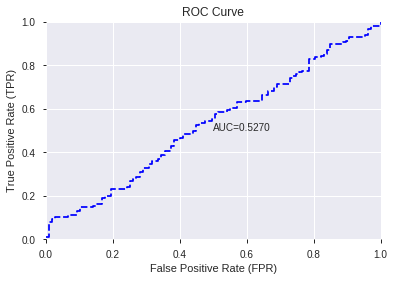

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


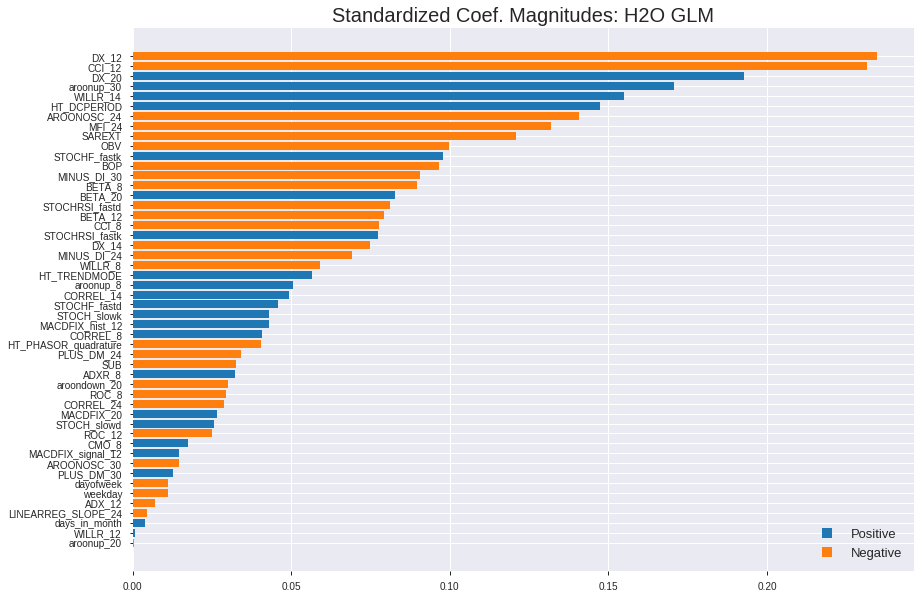

'log_likelihood'
--2019-08-27 14:30:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_142954_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_142954_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['DX_12',
 'CCI_12',
 'DX_20',
 'aroonup_30',
 'WILLR_14',
 'HT_DCPERIOD',
 'AROONOSC_24',
 'MFI_24',
 'SAREXT',
 'OBV',
 'STOCHF_fastk',
 'BOP',
 'MINUS_DI_30',
 'BETA_8',
 'BETA_20',
 'STOCHRSI_fastd',
 'BETA_12',
 'CCI_8',
 'STOCHRSI_fastk',
 'DX_14',
 'MINUS_DI_24',
 'WILLR_8',
 'HT_TRENDMODE',
 'aroonup_8',
 'CORREL_14',
 'STOCHF_fastd',
 'STOCH_slowk',
 'MACDFIX_hist_12',
 'CORREL_8',
 'HT_PHASOR_quadrature',
 'PLUS_DM_24',
 'SUB',
 'ADXR_8',
 'aroondown_20',
 'ROC_8',
 'CORREL_24',
 'MACDFIX_20',
 'STOCH_slowd',
 'ROC_12',
 'CMO_8',
 'MACDFIX_signal_12',
 'AROONOSC_30',
 'PLUS_DM_30',
 'dayofweek',
 'weekday',
 'ADX_12',
 'LINEARREG_SLOPE_24',
 'days_in_month',
 'WILLR_12',
 'aroonup_20']

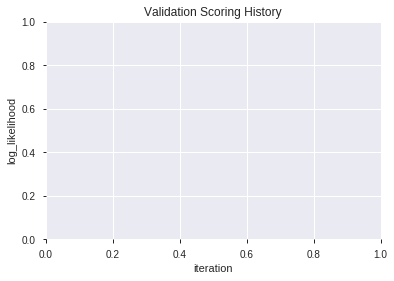

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_143005_model_3  0.569691  0.693557              0.500000  0.499988  0.249988
1  XGBoost_grid_1_AutoML_20190827_143005_model_4  0.567918  0.685274              0.480583  0.496109  0.246124
2               XGBoost_2_AutoML_20190827_143005  0.559781  0.694431              0.495327  0.500374  0.250374
3  XGBoost_grid_1_AutoML_20190827_143005_model_6  0.536255  0.704716              0.495327  0.505537  0.255567
4  XGBoost_grid_1_AutoML_20190827_143005_model_2  0.533677  0.696392              0.500000  0.501516  0.251518
5  XGBoost_grid_1_AutoML_20190827_143005_model_1  0.532388  0.719275              0.500000  0.512158  0.262306
6  XGBoost_grid_1_AutoML_20190827_143005_model_7  0.528843  0.703767              0.476636  0.504686  0.254708
7               XGBoost_1_AutoML_20190827_143005  0.526184  0.701631              0.490654  0.503860  0.253875
8               XGBoost_3_AutoML_20190827_143005  0.516516  0.714613              0.495327  0.509763  0.259858
9  XGBoost_grid_1_AutoML_20190827_143005_model_5  0.516033  0.741396              0.490292  0.520343  0.270757

variable  relative_importance  scaled_importance  percentage
0   HT_PHASOR_quadrature           224.278076           1.000000    0.047594
1                 BETA_8           202.385422           0.902386    0.042948
2            STOCH_slowd           180.958984           0.806851    0.038401
3             PLUS_DM_24           174.904114           0.779854    0.037117
4            HT_DCPERIOD           174.145523           0.776471    0.036956
5                  ROC_8           173.391037           0.773107    0.036795
6             PLUS_DM_30           161.633026           0.720681    0.034300
7         STOCHRSI_fastd           159.245926           0.710038    0.033794
8                  DX_20           154.846756           0.690423    0.032860
9                    BOP           147.825653           0.659118    0.031370
10                ADX_12           145.823746           0.650192    0.030945
11                CCI_12           125.911629           0.561409    0.026720
12                SAREXT           121.727135           0.542751    0.025832
13    LINEARREG_SLOPE_24           117.398384           0.523450    0.024913
14           STOCH_slowk           116.856926           0.521036    0.024798
15              WILLR_14           109.940056           0.490195    0.023330
16               WILLR_8           109.124084           0.486557    0.023157
17                MFI_24           107.221825           0.478075    0.022754
18                 DX_12           106.189880           0.473474    0.022535
19                   SUB           105.570450           0.470712    0.022403
20               BETA_20           103.474289           0.461366    0.021958
21                   OBV           101.352180           0.451904    0.021508
22             CORREL_24            99.257416           0.442564    0.021063
23       MACDFIX_hist_12            96.376480           0.429719    0.020452
24                ADXR_8            95.313469           0.424979    0.020227
25                ROC_12            92.366608           0.411840    0.019601
26     MACDFIX_signal_12            85.235359           0.380043    0.018088
27             CORREL_14            84.627281           0.377332    0.017959
28                 DX_14            78.918419           0.351878    0.016747
29                 CCI_8            72.869926           0.324909    0.015464
30               BETA_12            70.644150           0.314985    0.014991
31        STOCHRSI_fastk            70.054581           0.312356    0.014866
32          aroondown_20            67.619698           0.301499    0.014350
33           AROONOSC_24            65.455055           0.291848    0.013890
34           MINUS_DI_30            64.024178           0.285468    0.013587
35              WILLR_12            63.833992           0.284620    0.013546
36          STOCHF_fastd            62.443111           0.278418    0.013251
37             aroonup_8            60.559441           0.270019    0.012851
38           AROONOSC_30            54.527081           0.243123    0.011571
39            aroonup_30            51.034500           0.227550    0.010830
40          STOCHF_fastk            49.075718           0.218816    0.010414
41                 CMO_8            45.359039           0.202245    0.009626
42           MINUS_DI_24            39.374237           0.175560    0.008356
43              CORREL_8            37.649422           0.167869    0.007990
44            MACDFIX_20            24.781330           0.110494    0.005259
45             dayofweek            18.896151           0.084253    0.004010
46               weekday            16.521973           0.073667    0.003506
47            aroonup_20            16.299702           0.072676    0.003459
48         days_in_month             4.972266           0.022170    0.001055

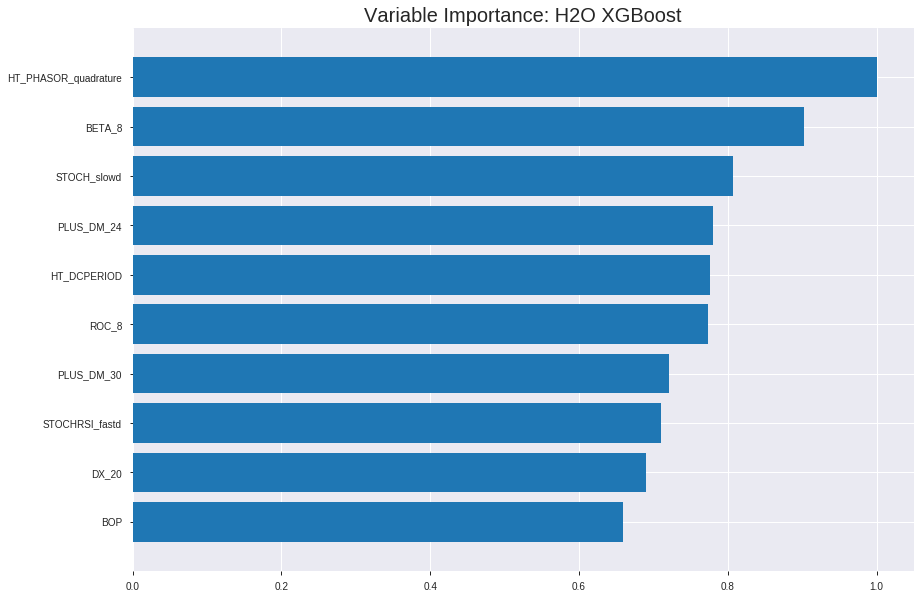

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_143005_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18335033138335152
RMSE: 0.42819426827475343
LogLoss: 0.5560937035097346
Mean Per-Class Error: 0.14606588214273308
AUC: 0.9291463380335283
pr_auc: 0.930210427739168
Gini: 0.8582926760670566
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5037506222724915: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      608  141  0.1883   (141.0/749.0)
1      89   718  0.1103   (89.0/807.0)
Total  697  859  0.1478   (230.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503751     0.861945  207
max f2                       0.45879      0.919647  253
max f0point5                 0.541097     0.866301  170
max accuracy                 0.513548     0.854113  196
max precision                0.805235     1         0
max recall                   0.409283     1         301
max specificity              0.805235     1         0
max absolute_mcc             0.513548     0.707835  196
max min_per_class_accuracy   0.514258     0.851301  195
max mean_per_class_accuracy  0.513548     0.853934  196

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 51.47 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.729907           1.92813    1.92813            1                0.749167  1                           0.749167            0.0198265       0.0198265                  92.8129   92.8129
    2        0.0205656                   0.713309           1.92813    1.92813            1                0.720198  1                           0.734683            0.0198265       0.039653                   92.8129   92.8129
    3        0.0302057                   0.699663           1.92813    1.92813            1                0.706022  1                           0.725535            0.0185874       0.0582404                  92.8129   92.8129
    4        0.0404884                   0.686782           1.92813    1.92813            1                0.693106  1                           0.717299            0.0198265       0.0780669                  92.8129   92.8129
    5        0.0501285                   0.681459           1.92813    1.92813            1                0.683933  1                           0.710883            0.0185874       0.0966543                  92.8129   92.8129
    6        0.100257                    0.653342           1.92813    1.92813            1                0.667295  1                           0.689089            0.0966543       0.193309                   92.8129   92.8129
    7        0.150386                    0.634001           1.90341    1.91989            0.987179         0.64336   0.995726                    0.673846            0.0954151       0.288724                   90.3409   91.9889
    8        0.200514                    0.616463           1.75509    1.87869            0.910256         0.624608  0.974359                    0.661537            0.0879802       0.376704                   75.5092   87.869
    9        0.300129                    0.579676           1.6669     1.80839            0.864516         0.597394  0.937901                    0.640247            0.166047        0.542751                   66.6899   80.8395
    10       0.400386                    0.548625           1.59441    1.75481            0.826923         0.563926  0.910112                    0.621136            0.159851        0.702602                   59.4414   75.4814
    11       0.5                         0.517582           1.35591    1.67534            0.703226         0.533153  0.868895                    0.603608            0.135068        0.83767                    35.591    67.5341
    12       0.600257                    0.489537           0.852826   1.53796            0.442308         0.504081  0.797645                    0.586984            0.0855019       0.923172                   -14.7174  53.7961
    13       0.699871                    0.45439            0.584658   1.40228            0.303226         0.472058  0.727273                    0.570626            0.0582404       0.981413                   -41.5342  40.2276
    14       0.800129                    0.414389           0.160677   1.2467             0.0833333        0.434134  0.646586                    0.553524            0.016109        0.997522                   -83.9323  24.6702
    15       0.899743                    0.366666           0.0248791  1.11143            0.0129032        0.392532  0.576429                    0.5357              0.00247831      1                          -97.5121  11.1429
    16       1                           0.232209           0          1                  0                0.326317  0.518638                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2518345213223156
RMSE: 0.5018311681455384
LogLoss: 0.696995786000154
Mean Per-Class Error: 0.4461557118602959
AUC: 0.5401305683563747
pr_auc: 0.5665712985250061
Gini: 0.08026113671274948
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28505897521972656: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    216  0.9954   (216.0/217.0)
1      0    228  0        (0.0/228.0)
Total  1    444  0.4854   (216.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.285059     0.678571  398
max f2                       0.285059     0.840708  398
max f0point5                 0.285059     0.568862  398
max accuracy                 0.552041     0.550562  152
max precision                0.815669     1         0
max recall                   0.285059     1         398
max specificity              0.815669     1         0
max absolute_mcc             0.684843     0.132308  20
max min_per_class_accuracy   0.51791      0.516129  204
max mean_per_class_accuracy  0.552041     0.553844  152

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 52.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.727584           1.5614    1.5614             0.8              0.751316  0.8                         0.751316            0.0175439       0.0175439                  56.1404    56.1404
    2        0.0202247                   0.700404           1.95175   1.73489            1                0.716315  0.888889                    0.73576             0.0175439       0.0350877                  95.1754    73.4893
    3        0.0314607                   0.695177           1.17105   1.53352            0.6              0.697041  0.785714                    0.721932            0.0131579       0.0482456                  17.1053    53.3521
    4        0.0404494                   0.687809           1.95175   1.62646            1                0.691382  0.833333                    0.715143            0.0175439       0.0657895                  95.1754    62.6462
    5        0.0516854                   0.680749           1.17105   1.52746            0.6              0.684355  0.782609                    0.70845             0.0131579       0.0789474                  17.1053    52.746
    6        0.101124                    0.646244           0.798445  1.17105            0.409091         0.660948  0.6                         0.685227            0.0394737       0.118421                   -20.1555   17.1053
    7        0.150562                    0.624127           0.887161  1.07783            0.454545         0.635202  0.552239                    0.668801            0.0438596       0.162281                   -11.2839   7.78345
    8        0.2                         0.606483           1.33074   1.14035            0.681818         0.615613  0.58427                     0.655653            0.0657895       0.22807                    33.0742    14.0351
    9        0.301124                    0.573515           1.08431   1.12153            0.555556         0.589996  0.574627                    0.633604            0.109649        0.337719                   8.4308     12.1531
    10       0.4                         0.544873           1.02024   1.09649            0.522727         0.556875  0.561798                    0.614637            0.100877        0.438596                   2.02352    9.64912
    11       0.501124                    0.51791            0.780702  1.03277            0.4              0.532485  0.529148                    0.59806             0.0789474       0.517544                   -21.9298   3.27669
    12       0.6                         0.494566           0.931519  1.01608            0.477273         0.505693  0.520599                    0.582838            0.0921053       0.609649                   -6.84809   1.60819
    13       0.698876                    0.467554           1.06459   1.02295            0.545455         0.4834    0.524116                    0.56877             0.105263        0.714912                   6.45933    2.29452
    14       0.8                         0.443582           0.997563  1.01974            0.511111         0.455933  0.522472                    0.554507            0.100877        0.815789                   -0.243665  1.97368
    15       0.898876                    0.405954           0.842803  1.00027            0.431818         0.424193  0.5125                      0.540172            0.0833333       0.899123                   -15.7197   0.0274123
    16       1                           0.283317           0.997563  1                  0.511111         0.370063  0.51236                    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:30:11  1.579 sec   0                  0.5              0.693147            0.5             0                  1                0.481362                         0.5                0.693147              0.5               0                    1                  0.48764
    2019-08-27 14:30:11  1.689 sec   5                  0.491508         0.676274            0.722656        0.728791           1.80762          0.3509                           0.499323           0.691804              0.536189          0.549148             1.30117            0.48764
    2019-08-27 14:30:12  1.754 sec   10                 0.482991         0.659562            0.795637        0.804144           1.92813          0.280206                         0.500009           0.693186              0.524254          0.537036             1.17105            0.48764
    2019-08-27 14:30:12  1.820 sec   15                 0.475067         0.644166            0.825692        0.833678           1.92813          0.262211                         0.499704           0.692567              0.532218          0.545785             1.95175            0.483146
    2019-08-27 14:30:12  1.882 sec   20                 0.467305         0.629238            0.854581        0.858788           1.92813          0.233933                         0.499311           0.691768              0.539494          0.560662             1.5614             0.485393
    2019-08-27 14:30:12  1.945 sec   25                 0.459946         0.615242            0.873792        0.877865           1.92813          0.208869                         0.499881           0.692916              0.537978          0.557764             1.5614             0.483146
    2019-08-27 14:30:12  2.015 sec   30                 0.453276         0.602632            0.88641         0.890561           1.92813          0.202442                         0.499698           0.692604              0.544527          0.557385             1.17105            0.483146
    2019-08-27 14:30:12  2.083 sec   35                 0.446995         0.590851            0.898522        0.902533           1.92813          0.197301                         0.500111           0.69343               0.543243          0.562255             1.17105            0.485393
    2019-08-27 14:30:12  2.158 sec   40                 0.440585         0.578868            0.90736         0.912998           1.92813          0.190231                         0.500793           0.694832              0.540606          0.562529             1.17105            0.485393
    2019-08-27 14:30:12  2.231 sec   45                 0.434234         0.567164            0.919068        0.921911           1.92813          0.163882                         0.502407           0.698125              0.530985          0.558739             1.5614             0.485393
    2019-08-27 14:30:12  2.312 sec   50                 0.428194         0.556094            0.929146        0.93021            1.92813          0.147815                         0.501831           0.696996              0.540131          0.566571             1.5614             0.485393

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
HT_PHASOR_quadrature  224.278076171875       1.0                   0.04759422822952039
BETA_8                202.3854217529297      0.9023861146277716    0.042948370690744316
STOCH_slowd           180.958984375          0.8068509747529781    0.03840144943960423
PLUS_DM_24            174.90411376953125     0.7798538169887541    0.03711654055142539
HT_DCPERIOD           174.14552307128906     0.776471450280468     0.036955559418355294
---                   ---                    ---                   ---
MACDFIX_20            24.781330108642578     0.11049376975059953   0.00525886569545011
dayofweek             18.896150588989258     0.08425322221200184   0.004009967087030513
weekday               16.52197265625         0.0736673550008001    0.00350614090697318
aroonup_20            16.299701690673828     0.072676304206313     0.0034589726092733144
days_in_month         4.97226619720459       0.022170094741646103  0.0010551685490039946


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57847533632287)

('F1', 0.6843657817109144)

('auc', 0.5696906219787302)

('logloss', 0.6935567065572324)

('mean_per_class_error', 0.41786174669674514)

('rmse', 0.499988127574134)

('mse', 0.24998812771508852)

xgboost prediction progress: |████████████████████████████████████████████| 100%


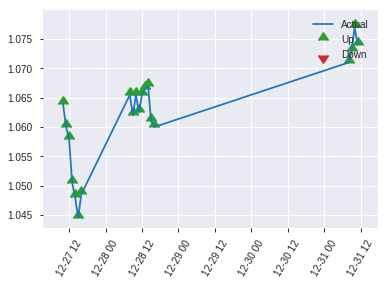


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24998812771508852
RMSE: 0.499988127574134
LogLoss: 0.6935567065572324
Mean Per-Class Error: 0.41786174669674514
AUC: 0.5696906219787302
pr_auc: 0.581524161216673
Gini: 0.13938124395746043
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2961055338382721: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    107  1        (107.0/107.0)
1      0    116  0        (0.0/116.0)
Total  0    223  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.296106     0.684366  222
max f2                       0.296106     0.84425   222
max f0point5                 0.483839     0.598592  183
max accuracy                 0.606083     0.578475  91
max precision                0.77694      1         0
max recall                   0.296106     1         222
max specificity              0.77694      1         0
max absolute_mcc             0.606083     0.166712  91
max min_per_class_accuracy   0.571447     0.542056  111
max mean_per_class_accuracy  0.606083     0.582138  91

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 57.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.73521            1.28161   1.28161            0.666667         0.758244  0.666667                    0.758244            0.0172414       0.0172414                  28.1609   28.1609
    2        0.0224215                   0.730048           1.92241   1.53793            1                0.731653  0.8                         0.747607            0.0172414       0.0344828                  92.2414   53.7931
    3        0.0313901                   0.721753           1.92241   1.64778            1                0.727026  0.857143                    0.741727            0.0172414       0.0517241                  92.2414   64.7783
    4        0.0403587                   0.711406           0.961207  1.49521            0.5              0.716733  0.777778                    0.736173            0.00862069      0.0603448                  -3.87931  49.5211
    5        0.0538117                   0.705501           1.28161   1.44181            0.666667         0.708033  0.75                        0.729138            0.0172414       0.0775862                  28.1609   44.181
    6        0.103139                    0.690831           0.69906   1.08658            0.363636         0.698053  0.565217                    0.714271            0.0344828       0.112069                   -30.094   8.65817
    7        0.152466                    0.675573           1.04859   1.07429            0.545455         0.683329  0.558824                    0.70426             0.0517241       0.163793                   4.85893   7.42901
    8        0.201794                    0.652779           1.57288   1.19617            0.818182         0.66285   0.622222                    0.694138            0.0775862       0.241379                   57.2884   19.6169
    9        0.300448                    0.632905           0.873824  1.09032            0.454545         0.640204  0.567164                    0.676428            0.0862069       0.327586                   -12.6176  9.03242
    10       0.399103                    0.606977           1.39812   1.16641            0.727273         0.619037  0.606742                    0.662242            0.137931        0.465517                   39.8119   16.6408
    11       0.502242                    0.571447           0.752249  1.08136            0.391304         0.589652  0.5625                      0.647335            0.0775862       0.543103                   -24.7751  8.13578
    12       0.600897                    0.550775           0.873824  1.04729            0.454545         0.559992  0.544776                    0.632995            0.0862069       0.62931                    -12.6176  4.72851
    13       0.699552                    0.52426            1.04859   1.04747            0.545455         0.539242  0.544872                    0.619773            0.103448        0.732759                   4.85893   4.74691
    14       0.798206                    0.498478           1.13597   1.05841            0.590909         0.511243  0.550562                    0.606359            0.112069        0.844828                   13.5972   5.84076
    15       0.896861                    0.456716           0.611677  1.00927            0.318182         0.476323  0.525                       0.592056            0.0603448       0.905172                   -38.8323  0.926724
    16       1                           0.296106           0.919415  1                  0.478261         0.413447  0.520179                    0.573634         

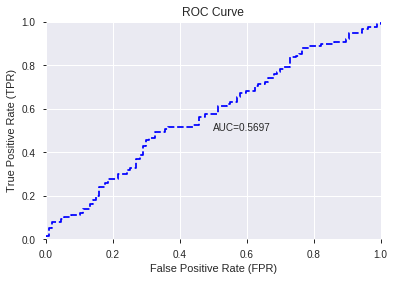

This function is available for GLM models only


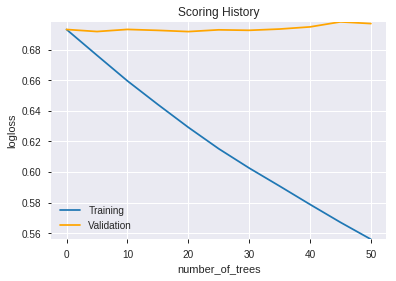

--2019-08-27 14:30:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_143005_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_143005_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['HT_PHASOR_quadrature',
 'BETA_8',
 'STOCH_slowd',
 'PLUS_DM_24',
 'HT_DCPERIOD',
 'ROC_8',
 'PLUS_DM_30',
 'STOCHRSI_fastd',
 'DX_20',
 'BOP',
 'ADX_12',
 'CCI_12',
 'SAREXT',
 'LINEARREG_SLOPE_24',
 'STOCH_slowk',
 'WILLR_14',
 'WILLR_8',
 'MFI_24',
 'DX_12',
 'SUB',
 'BETA_20',
 'OBV',
 'CORREL_24',
 'MACDFIX_hist_12',
 'ADXR_8',
 'ROC_12',
 'MACDFIX_signal_12',
 'CORREL_14',
 'DX_14',
 'CCI_8',
 'BETA_12',
 'STOCHRSI_fastk',
 'aroondown_20',
 'AROONOSC_24',
 'MINUS_DI_30',
 'WILLR_12',
 'STOCHF_fastd',
 'aroonup_8',
 'AROONOSC_30',
 'aroonup_30',
 'STOCHF_fastk',
 'CMO_8',
 'MINUS_DI_24',
 'CORREL_8',
 'MACDFIX_20',
 'dayofweek',
 'weekday',
 'aroonup_20',
 'days_in_month']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 918] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_143032_model_1  0.566911  3.475262              0.495327  0.650439  0.423071
1  DeepLearning_grid_1_AutoML_20190827_143032_model_3  0.545601  0.720216              0.500000  0.509681  0.259774
2  DeepLearning_grid_1_AutoML_20190827_143032_model_6  0.529165  0.694874              0.490654  0.500834  0.250835
3  DeepLearning_grid_1_AutoML_20190827_143032_model_5  0.525943  0.697476              0.494965  0.501953  0.251957
4  DeepLearning_grid_1_AutoML_20190827_143032_model_2  0.511441  0.718414              0.500000  0.511431  0.261562
5  DeepLearning_grid_1_AutoML_20190827_143032_model_8  0.507009  0.692581              0.500000  0.499717  0.249717
6  DeepLearning_grid_1_AutoML_20190827_143032_model_7  0.506123  0.781756              0.481308  0.532029  0.283055
7               DeepLearning_1_AutoML_20190827_143032  0.504512  1.106428              0.490292  0.568386  0.323063
8  DeepLearning_grid_1_AutoML_20190827_143032_model_9  0.500000  0.692333              0.500000  0.499593  0.249593
9  DeepLearning_grid_1_AutoML_20190827_143032_model_4  0.484692  1.096992              0.485981  0.597147  0.356585

variable  relative_importance  scaled_importance  percentage
0               CDLEVENINGSTAR             1.000000           1.000000    0.001483
1            CDLGRAVESTONEDOJI             0.944739           0.944739    0.001401
2              CDLHOMINGPIGEON             0.939025           0.939025    0.001392
3               CDLMORNINGSTAR             0.925550           0.925550    0.001372
4              CDLSHOOTINGSTAR             0.925067           0.925067    0.001372
...                        ...                  ...                ...         ...
1033  BBANDS_middleband_30_7_2             0.588426           0.588426    0.000873
1034   BBANDS_upperband_14_3_2             0.585225           0.585225    0.000868
1035   BBANDS_middleband_8_2_5             0.584772           0.584772    0.000867
1036   BBANDS_middleband_8_8_5             0.583656           0.583656    0.000865
1037                      SINH             0.571080           0.571080    0.000847

[1038 rows x 4 columns]

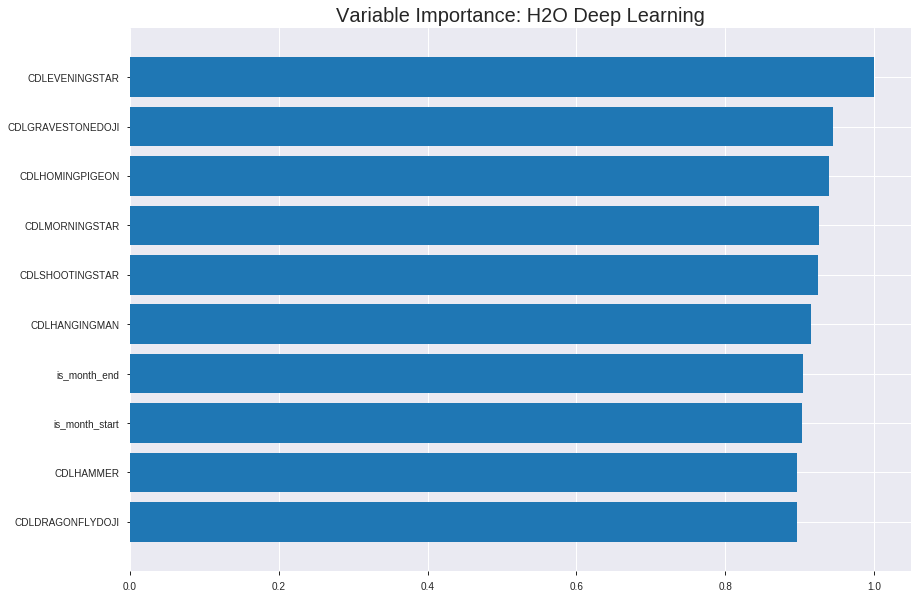

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_143032_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2663450541498585
RMSE: 0.5160862855665305
LogLoss: 1.1092337573303266
Mean Per-Class Error: 0.33083351118302307
AUC: 0.7165506094040298
pr_auc: 0.6128994021738328
Gini: 0.43310121880805963
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16631409756701276: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      400  349  0.466    (349.0/749.0)
1      162  645  0.2007   (162.0/807.0)
Total  562  994  0.3284   (511.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.166314     0.716269  302
max f2                       5.01042e-05  0.843436  399
max f0point5                 0.479531     0.684196  195
max accuracy                 0.173306     0.671594  299
max precision                0.999925     0.837838  0
max recall                   5.01042e-05  1         399
max specificity              0.999925     0.975968  0
max absolute_mcc             0.166314     0.3467    302
max min_per_class_accuracy   0.387506     0.663551  221
max mean_per_class_accuracy  0.433914     0.669166  206

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 47.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   1                  1.80762   1.80762            0.9375           1           0.9375                      1                   0.0185874       0.0185874                  80.7621   80.7621
    2        0.0205656                   0.999995           1.92813   1.86787            1                0.999998    0.96875                     0.999999            0.0198265       0.0384139                  92.8129   86.7875
    3        0.0302057                   0.999983           1.5425    1.76403            0.8              0.99999     0.914894                    0.999996            0.0148699       0.0532838                  54.2503   76.4033
    4        0.0404884                   0.999945           1.68711   1.7445             0.875            0.999965    0.904762                    0.999988            0.0173482       0.070632                   68.7113   74.4498
    5        0.0501285                   0.999884           1.67105   1.73037            0.866667         0.999925    0.897436                    0.999976            0.016109        0.086741                   67.1045   73.0372
    6        0.100257                    0.998693           1.35958   1.54498            0.705128         0.999462    0.801282                    0.999719            0.0681537       0.154895                   35.9578   54.4975
    7        0.150386                    0.992587           1.33486   1.47494            0.692308         0.996185    0.764957                    0.998541            0.0669145       0.221809                   33.4858   47.4936
    8        0.200514                    0.973468           1.40902   1.45846            0.730769         0.984527    0.75641                     0.995038            0.070632        0.292441                   40.9017   45.8456
    9        0.300129                    0.875296           1.30615   1.40791            0.677419         0.929498    0.730193                    0.973285            0.130112        0.422553                   30.6152   40.7906
    10       0.400386                    0.668053           1.1989    1.35557            0.621795         0.77725     0.70305                     0.924197            0.120198        0.542751                   19.8901   35.5571
    11       0.5                         0.40928            1.15688   1.31599            0.6              0.534839    0.682519                    0.846626            0.115242        0.657993                   15.6877   31.5985
    12       0.600257                    0.217975           0.964064  1.25721            0.5              0.304945    0.652034                    0.756153            0.0966543       0.754647                   -3.59356  25.7206
    13       0.699871                    0.098451           0.796131  1.19158            0.412903         0.152567    0.617998                    0.670243            0.0793061       0.833953                   -20.3869  19.158
    14       0.800129                    0.0301854          0.692149  1.129              0.358974         0.0604542   0.585542                    0.593836            0.0693928       0.903346                   -30.7851  12.9001
    15       0.899743                    0.00453517         0.572219  1.06736            0.296774         0.0158543   0.553571                    0.529845            0.0570012       0.960347                   -42.7781  6.73571
    16       1                           7.00492e-17        0.395514  1                  0.205128         0.00110697  0.518638  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3814761846685657
RMSE: 0.6176375835945912
LogLoss: 1.9457605443187658
Mean Per-Class Error: 0.4353019645888916
AUC: 0.5630810898213275
pr_auc: 0.5544388200587044
Gini: 0.12616217964265508
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00018900681402587782: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    214  0.9862   (214.0/217.0)
1      0    228  0        (0.0/228.0)
Total  3    442  0.4809   (214.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000189007  0.680597  396
max f2                       0.000189007  0.84195   396
max f0point5                 0.000189007  0.571142  396
max accuracy                 0.909367     0.561798  126
max precision                1            0.769231  0
max recall                   0.000189007  1         396
max specificity              1            0.986175  0
max absolute_mcc             0.998084     0.143973  40
max min_per_class_accuracy   0.686321     0.552632  178
max mean_per_class_accuracy  0.909367     0.564698  126

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 58.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    1                  1.5614    1.5614             0.8              1           0.8                         1                   0.0175439       0.0175439                  56.1404    56.1404
    2        0.0202247                   0.999999           0.975877  1.30117            0.5              1           0.666667                    1                   0.00877193      0.0263158                  -2.41228   30.117
    3        0.0314607                   0.999998           1.5614    1.39411            0.8              0.999999    0.714286                    0.999999            0.0175439       0.0438596                  56.1404    39.411
    4        0.0404494                   0.999996           1.46382   1.4096             0.75             0.999997    0.722222                    0.999999            0.0131579       0.0570175                  46.3816    40.96
    5        0.0516854                   0.999993           1.17105   1.35774            0.6              0.999994    0.695652                    0.999998            0.0131579       0.0701754                  17.1053    35.7742
    6        0.101124                    0.999873           1.33074   1.34454            0.681818         0.999953    0.688889                    0.999976            0.0657895       0.135965                   33.0742    34.4542
    7        0.150562                    0.999252           1.06459   1.25262            0.545455         0.999626    0.641791                    0.999861            0.0526316       0.188596                   6.45933    25.2618
    8        0.2                         0.997439           1.33074   1.27193            0.681818         0.998539    0.651685                    0.999534            0.0657895       0.254386                   33.0742    27.193
    9        0.301124                    0.978496           0.867446  1.1361             0.444444         0.991471    0.58209                     0.996826            0.0877193       0.342105                   -13.2554   13.6096
    10       0.4                         0.888637           1.19767   1.15132            0.613636         0.944623    0.589888                    0.983922            0.118421        0.460526                   19.7667    15.1316
    11       0.501124                    0.686321           0.910819  1.10278            0.466667         0.796382    0.565022                    0.946078            0.0921053       0.552632                   -8.91813   10.2785
    12       0.6                         0.465885           0.887161  1.06725            0.454545         0.599724    0.546816                    0.889001            0.0877193       0.640351                   -11.2839   6.72515
    13       0.698876                    0.206057           0.887161  1.04177            0.454545         0.320102    0.533762                    0.808514            0.0877193       0.72807                    -11.2839   4.17724
    14       0.8                         0.0588193          0.824074  1.01425            0.422222         0.120637    0.519663                    0.721563            0.0833333       0.811404                   -17.5926   1.42544
    15       0.898876                    0.0080147          0.887161  1.00027            0.454545         0.0278841   0.5125                      0.645258            0.0877193       0.899123                   -11.2839   0.0274123
    16       1                           1.56344e-05        0.997563  1                  0.511111         0.00249


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:30:35  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 14:30:39  4.602 sec         236 obs/sec       0.491003  1             764        0.681657         5.32558             -0.861211      0.489975        0.447715           0.964064         0.481362                         0.664089           3.0914                -0.765133        0.480203          0.458244             0.780702           0.48764
    2019-08-27 14:30:51  17.162 sec        254 obs/sec       2.45437   5             3819       0.660247         6.16469             -0.746129      0.567367        0.375424           1.25068          0.481362                         0.646997           3.29726               -0.675444        0.534694          0.538222             0.780702           0.48764
    2019-08-27 14:31:01  26.695 sec        259 obs/sec       3.94794   8             6143       0.671957         5.72815             -0.80862       0.562037        0.49764            1.68711          0.481362                         0.640606           5.75333               -0.642509        0.552248          0.565115             1.17105            0.48764
    2019-08-27 14:31:10  36.103 sec        262 obs/sec       5.44794   11            8477       0.655127         4.02498             -0.719155      0.617759        0.636036           1.68711          0.481362                         0.64406            4.7766                -0.660265        0.532662          0.551724             1.5614             0.48764
    2019-08-27 14:31:20  45.665 sec        264 obs/sec       6.98972   14            10876      0.567683         1.86295             -0.290851      0.648638        0.507423           1.68711          0.411311                         0.622056           1.95226               -0.548759        0.543183          0.549661             1.17105            0.48764
    2019-08-27 14:31:29  54.872 sec        265 obs/sec       8.45308   17            13153      0.637845         3.2588              -0.629648      0.650201        0.669582           1.92813          0.481362                         0.656493           3.29614               -0.724987        0.536078          0.548537             1.17105            0.48764
    2019-08-27 14:31:38  1 min  4.288 sec  267 obs/sec       9.96337   20            15503      0.591553         2.42447             -0.40169       0.629707        0.645888           1.92813          0.481362                         0.644267           2.3722                -0.661337        0.542374          0.564478             1.17105            0.48764
    2019-08-27 14:31:47  1 min 13.282 sec  268 obs/sec       11.4152   23            17762      0.565704         1.65215             -0.281864      0.70057         0.668673           1.68711          0.3991                           0.62061            2.36454               -0.54157         0.562828          0.57795              1.5614             0.47191
    2019-08-27 14:31:57  1 min 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLEVENINGSTAR            1.0                    1.0                  0.0014828256728063004
CDLGRAVESTONEDOJI         0.9447385668754578     0.9447385668754578   0.0014008826010531608
CDLHOMINGPIGEON           0.9390245079994202     0.9390245079994202   0.0013924096478558454
CDLMORNINGSTAR            0.9255496859550476     0.9255496859550476   0.0013724288357919536
CDLSHOOTINGSTAR           0.9250665307044983     0.9250665307044983   0.001371712400782488
---                       ---                    ---                  ---
BBANDS_middleband_30_7_2  0.5884261727333069     0.5884261727333069   0.0008725334354801022
BBANDS_upperband_14_3_2   0.5852246880531311     0.5852246880531311   0.0008677861918052415
BBANDS_middleband_8_2_5   0.5847717523574829     0.5847717523574829   0.0008671145671276039
BBANDS_middleband_8_8_5   0.5836557149887085     0.5836557149887085   0.000865459678265374
SINH                      0.5710800290107727     0.5710800290107727   0.0008468121282441406


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.57847533632287)

('F1', 0.6863905325443787)

('auc', 0.566911053818885)

('logloss', 3.475262421932444)

('mean_per_class_error', 0.4142362230099903)

('rmse', 0.6504388542945312)

('mse', 0.42307070317598233)

deeplearning prediction progress: |███████████████████████████████████████| 100%


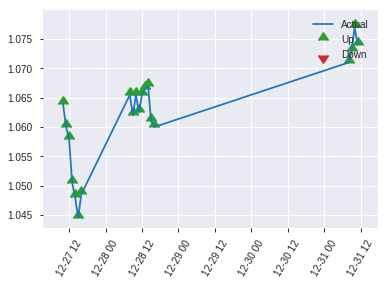


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.42307070317598233
RMSE: 0.6504388542945312
LogLoss: 3.475262421932444
Mean Per-Class Error: 0.4142362230099903
AUC: 0.566911053818885
pr_auc: 0.5175633977398425
Gini: 0.13382210763776992
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0003764673779339213: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    106  0.9907   (106.0/107.0)
1      0    116  0        (0.0/116.0)
Total  1    222  0.4753   (106.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000376467  0.686391  196
max f2                       0.000376467  0.845481  196
max f0point5                 0.885531     0.594059  147
max accuracy                 0.999887     0.578475  46
max precision                0.999954     0.65625   38
max recall                   0.000376467  1         196
max specificity              1            0.934579  0
max absolute_mcc             0.999887     0.183274  46
max min_per_class_accuracy   0.998531     0.523364  86
max mean_per_class_accuracy  0.999887     0.585764  46

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 86.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   1                  1.28161   1.28161            0.666667         1         0.666667                    1                   0.0172414       0.0172414                  28.1609   28.1609
    2        0.0224215                   1                  0.961207  1.15345            0.5              1         0.6                         1                   0.00862069      0.0258621                  -3.87931  15.3448
    3        0.0313901                   1                  0.961207  1.09852            0.5              1         0.571429                    1                   0.00862069      0.0344828                  -3.87931  9.85222
    4        0.0403587                   1                  0.961207  1.06801            0.5              1         0.555556                    1                   0.00862069      0.0431034                  -3.87931  6.80077
    5        0.0538117                   1                  1.92241   1.28161            1                1         0.666667                    1                   0.0258621       0.0689655                  92.2414   28.1609
    6        0.103139                    1                  0.69906   1.003              0.363636         1         0.521739                    1                   0.0344828       0.103448                   -30.094   0.29985
    7        0.152466                    0.999999           1.04859   1.01775            0.545455         1         0.529412                    1                   0.0517241       0.155172                   4.85893   1.77485
    8        0.201794                    0.999987           1.22335   1.06801            0.636364         0.999994  0.555556                    0.999998            0.0603448       0.215517                   22.3354   6.80077
    9        0.300448                    0.999943           1.57288   1.23379            0.818182         0.999972  0.641791                    0.99999             0.155172        0.37069                    57.2884   23.3788
    10       0.399103                    0.999654           0.873824  1.14481            0.454545         0.999801  0.595506                    0.999943            0.0862069       0.456897                   -12.6176  14.4808
    11       0.502242                    0.998531           0.668666  1.04703            0.347826         0.999194  0.544643                    0.999789            0.0689655       0.525862                   -33.1334  4.70289
    12       0.600897                    0.993434           1.31074   1.09032            0.681818         0.996389  0.567164                    0.999231            0.12931         0.655172                   31.0737   9.03242
    13       0.699552                    0.973546           0.786442  1.04747            0.409091         0.986686  0.544872                    0.997462            0.0775862       0.732759                   -21.3558  4.74691
    14       0.798206                    0.812411           1.04859   1.04761            0.545455         0.916215  0.544944                    0.98742             0.103448        0.836207                   4.85893   4.76075
    15       0.896861                    0.478494           0.786442  1.01888            0.409091         0.64339   0.53                        0.949577            0.0775862       0.913793                   -21.3558  1.88793
    16       1                           9.50509e-06        0.835832  1                  0.434783         0.167256  0.520179                    0.868889         

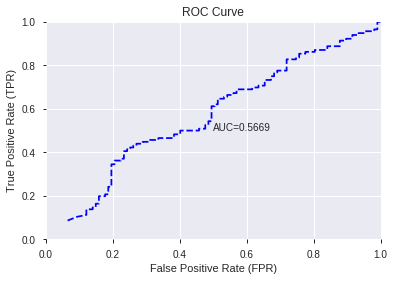

This function is available for GLM models only


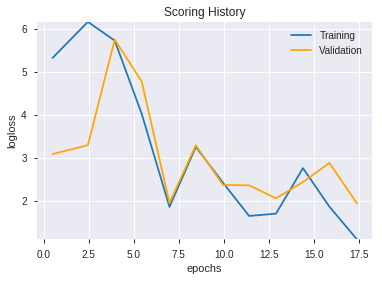

--2019-08-27 14:53:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.101.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.101.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_143032_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_143032_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLEVENINGSTAR',
 'CDLGRAVESTONEDOJI',
 'CDLHOMINGPIGEON',
 'CDLMORNINGSTAR',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'is_month_end',
 'is_month_start',
 'CDLHAMMER',
 'CDLDRAGONFLYDOJI',
 'CDLADVANCEBLOCK',
 'FLOOR',
 'CEIL',
 'CDLTAKURI',
 'CDLGAPSIDESIDEWHITE',
 'CDLMATCHINGLOW',
 'CDLINVERTEDHAMMER',
 'CDL3WHITESOLDIERS',
 'CDLTHRUSTING',
 'CDLDARKCLOUDCOVER',
 'CDLIDENTICAL3CROWS',
 'CDLTASUKIGAP',
 'CDLUNIQUE3RIVER',
 'CDLXSIDEGAP3METHODS',
 'CDLEVENINGDOJISTAR',
 'CDLONNECK',
 'CDLRISEFALL3METHODS',
 'CDLSTALLEDPATTERN',
 'CDLRICKSHAWMAN',
 'CDLMORNINGDOJISTAR',
 'AD',
 'CORREL_24',
 'CDLLONGLEGGEDDOJI',
 'CDLLADDERBOTTOM',
 'OBV',
 'CDLHIKKAKEMOD',
 'CORREL_14',
 'CORREL_20',
 'CDLCOUNTERATTACK',
 'CDLSEPARATINGLINES',
 'CDLDOJI',
 'days_in_month',
 'HT_TRENDMODE',
 'BETA_20',
 'VAR_14',
 'VAR_24',
 'VAR_8',
 'CDLHIGHWAVE',
 'BETA_12',
 'aroonup_12',
 'BBANDS_middleband_12_6_3',
 'aroonup_8',
 'TRANGE',
 'CORREL_30',
 'AROONOSC_30',
 'HT_DCPERIOD',
 'quarter',
 'MFI_8',
 'VAR_

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_145311_model_1  0.506526  0.704931                   0.5  0.505349  0.255378

variable  relative_importance  scaled_importance    percentage
0                  HT_DCPERIOD         5.787469e-02           1.000000  1.475880e-02
1                         DX_8         5.706691e-02           0.986043  1.455281e-02
2                       SAREXT         5.112240e-02           0.883329  1.303688e-02
3            CDLGRAVESTONEDOJI         4.883838e-02           0.843864  1.245442e-02
4                   CDL3INSIDE         4.732664e-02           0.817743  1.206891e-02
...                        ...                  ...                ...           ...
1033  BBANDS_middleband_20_1_2         3.800155e-06           0.000066  9.690891e-07
1034                 MAVP_14_0         3.308654e-06           0.000057  8.437500e-07
1035               aroondown_8         3.008027e-06           0.000052  7.670861e-07
1036                    MA_8_2         1.447435e-07           0.000003  3.691148e-08
1037                   MA_20_1         1.078671e-07           0.000002  2.750751e-08

[1038 rows x 4 columns]

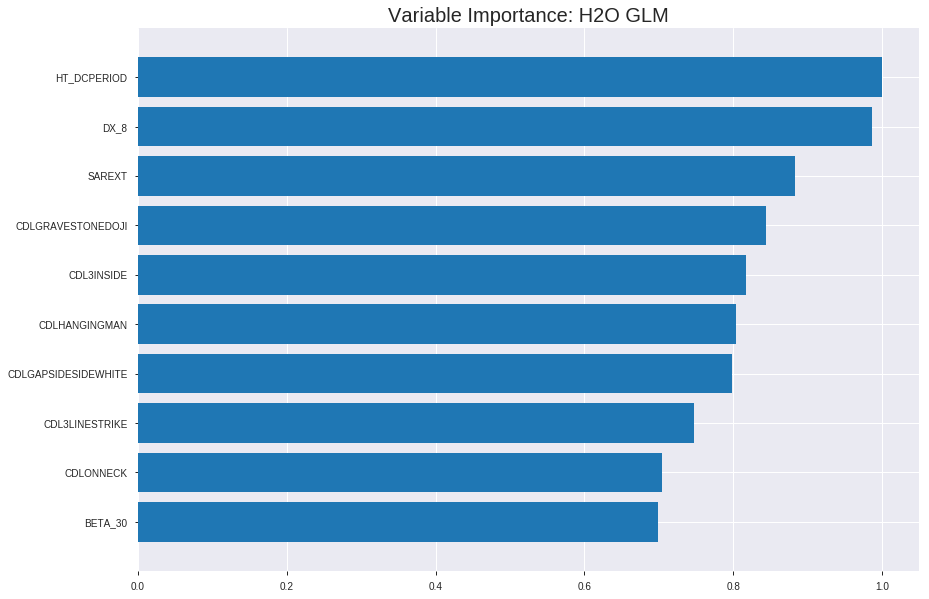

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_145311_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2363521883103135
RMSE: 0.48616066100653754
LogLoss: 0.6651297182664451
Null degrees of freedom: 1555
Residual degrees of freedom: 517
Null deviance: 2154.9115712492066
Residual deviance: 2069.883683245177
AIC: 4147.883683245177
AUC: 0.6428381170763827
pr_auc: 0.6499316639214839
Gini: 0.28567623415276544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4399269498618629: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      112  637   0.8505   (637.0/749.0)
1      35   772   0.0434   (35.0/807.0)
Total  147  1409  0.4319   (672.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.439927     0.696751  316
max f2                       0.363099     0.848224  373
max f0point5                 0.5139       0.621038  201
max accuracy                 0.5139       0.606684  201
max precision                0.789717     1         0
max recall                   0.363099     1         373
max specificity              0.789717     1         0
max absolute_mcc             0.5139       0.210702  201
max min_per_class_accuracy   0.521631     0.59279   188
max mean_per_class_accuracy  0.5139       0.604793  201

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 51.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.676666           1.68711   1.68711            0.875            0.722345  0.875                       0.722345            0.0173482       0.0173482                  68.7113   68.7113
    2        0.0205656                   0.64861            1.4461    1.5666             0.75             0.660765  0.8125                      0.691555            0.0148699       0.0322181                  44.6097   56.6605
    3        0.0302057                   0.637473           1.67105   1.59994            0.866667         0.642352  0.829787                    0.675852            0.016109        0.0483271                  67.1045   59.9937
    4        0.0404884                   0.624974           1.68711   1.62208            0.875            0.63135   0.84127                     0.66455             0.0173482       0.0656753                  68.7113   62.2077
    5        0.0501285                   0.616848           1.5425    1.60677            0.8              0.621193  0.833333                    0.656212            0.0148699       0.0805452                  54.2503   60.6774
    6        0.100257                    0.592121           1.28542   1.4461             0.666667         0.603088  0.75                        0.62965             0.0644362       0.144981                   28.5419   44.6097
    7        0.150386                    0.580424           1.1371    1.3431             0.589744         0.585971  0.696581                    0.61509             0.0570012       0.201983                   13.7102   34.3098
    8        0.200514                    0.567306           1.31014   1.33486            0.679487         0.574156  0.692308                    0.604857            0.0656753       0.267658                   31.0139   33.4858
    9        0.300129                    0.551456           1.11956   1.2634             0.580645         0.559025  0.655246                    0.589645            0.111524        0.379182                   11.9559   26.3399
    10       0.400386                    0.537              1.1371    1.23177            0.589744         0.544225  0.638844                    0.578272            0.114002        0.493185                   13.7102   23.1774
    11       0.5                         0.521947           0.970284  1.17968            0.503226         0.529207  0.611825                    0.568497            0.0966543       0.589839                   -2.97158  17.9678
    12       0.600257                    0.506169           1.06294   1.16018            0.551282         0.514234  0.601713                    0.559434            0.106568        0.696406                   6.29428   16.018
    13       0.699871                    0.490354           0.932966  1.12784            0.483871         0.498616  0.58494                     0.550777            0.0929368       0.789343                   -6.70344  12.784
    14       0.800129                    0.470984           0.865186  1.09493            0.448718         0.480222  0.567871                    0.541937            0.086741        0.876084                   -13.4814  9.49294
    15       0.899743                    0.442077           0.758812  1.05772            0.393548         0.457945  0.548571                    0.532638            0.0755886       0.951673                   -24.1188  5.77164
    16       1                           0.184714           0.482032  1                  0.25             0.392996  0.518638                    0.518638           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24446163168195434
RMSE: 0.49443061361727425
LogLoss: 0.6821162930381018
Null degrees of freedom: 444
Residual degrees of freedom: -594
Null deviance: 616.6992856395483
Residual deviance: 607.0835008039106
AIC: 2685.0835008039107
AUC: 0.5858901285471744
pr_auc: 0.5904770400520578
Gini: 0.17178025709434874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31962113185782526: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    210  0.9677   (210.0/217.0)
1      1    227  0.0044   (1.0/228.0)
Total  8    437  0.4742   (211.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.319621     0.682707  391
max f2                       0.319621     0.841364  391
max f0point5                 0.472618     0.584016  272
max accuracy                 0.540114     0.564045  96
max precision                0.620653     0.75      11
max recall                   0.222465     1         398
max specificity              0.763665     0.995392  0
max absolute_mcc             0.550815     0.168929  76
max min_per_class_accuracy   0.5          0.552632  201
max mean_per_class_accuracy  0.540114     0.570671  96

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 49.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.635616           1.17105   1.17105            0.6              0.68036   0.6                         0.68036             0.0131579       0.0131579                  17.1053    17.1053
    2        0.0202247                   0.622115           1.46382   1.30117            0.75             0.626363  0.666667                    0.656361            0.0131579       0.0263158                  46.3816    30.117
    3        0.0314607                   0.618864           1.5614    1.39411            0.8              0.620666  0.714286                    0.643613            0.0175439       0.0438596                  56.1404    39.411
    4        0.0404494                   0.614462           0.975877  1.30117            0.5              0.616897  0.666667                    0.637676            0.00877193      0.0526316                  -2.41228   30.117
    5        0.0516854                   0.607049           1.5614    1.35774            0.8              0.610332  0.695652                    0.631732            0.0175439       0.0701754                  56.1404    35.7742
    6        0.101124                    0.574302           1.24203   1.30117            0.636364         0.58545   0.666667                    0.609105            0.0614035       0.131579                   24.2026    30.117
    7        0.150562                    0.5591             1.24203   1.28175            0.636364         0.567186  0.656716                    0.59534             0.0614035       0.192982                   24.2026    28.1749
    8        0.2                         0.546458           1.41946   1.31579            0.727273         0.55244   0.674157                    0.584736            0.0701754       0.263158                   41.9458    31.5789
    9        0.301124                    0.528653           0.867446  1.16523            0.444444         0.537004  0.597015                    0.568707            0.0877193       0.350877                   -13.2554   16.5226
    10       0.4                         0.513547           1.02024   1.12939            0.522727         0.521433  0.578652                    0.557021            0.100877        0.451754                   2.02352    12.9386
    11       0.501124                    0.5                0.997563  1.10278            0.511111         0.507516  0.565022                    0.547031            0.100877        0.552632                   -0.243665  10.2785
    12       0.6                         0.48662            0.931519  1.07456            0.477273         0.492956  0.550562                    0.53812             0.0921053       0.644737                   -6.84809   7.45614
    13       0.698876                    0.471496           1.06459   1.07315            0.545455         0.480538  0.549839                    0.529973            0.105263        0.75                       6.45933    7.31511
    14       0.8                         0.452906           0.780702  1.03618            0.4              0.463585  0.530899                    0.521581            0.0789474       0.828947                   -21.9298   3.61842
    15       0.898876                    0.422572           1.02024   1.03443            0.522727         0.439976  0.53                        0.512605            0.100877        0.929825                   2.02352    3.44298
    16       1                           0.208128           0.693957  1                  0.355556         0.371149  0.51236                     0.49


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 14:53:14  0.000 sec   2            3.1       1039          1.3719            1.3745
    2019-08-27 14:53:16  1.957 sec   4            2.2       1039          1.36896           1.37302
    2019-08-27 14:53:18  3.888 sec   6            1.6       1039          1.36543           1.37144
    2019-08-27 14:53:20  5.846 sec   8            1.2       1039          1.3612            1.36981
    2019-08-27 14:53:22  7.784 sec   10           0.87      1039          1.35626           1.36819
    2019-08-27 14:53:24  9.721 sec   12           0.63      1039          1.35061           1.36667
    2019-08-27 14:53:26  11.669 sec  14           0.46      1039          1.34431           1.36542
    2019-08-27 14:53:28  13.590 sec  16           0.33      1039          1.33748           1.36454
    2019-08-27 14:53:30  15.627 sec  18           0.24      1039          1.33026           1.36423
    2019-08-27 14:53:32  17.579 sec  20           0.18      1039          1.32281           1.36452
    2019-08-27 14:53:34  19.514 sec  22           0.13      1039          1.31531           1.36553
    2019-08-27 14:53:36  21.444 sec  24           0.094     1039          1.30788           1.36728
    2019-08-27 14:53:38  23.409 sec  26           0.068     1039          1.30062           1.36966
    2019-08-27 14:53:40  25.370 sec  28           0.05      1039          1.29361           1.37256

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5246636771300448)

('F1', 0.6843657817109144)

('auc', 0.5065259426361586)

('logloss', 0.7049313433367501)

('mean_per_class_error', 0.4687802126973897)

('rmse', 0.5053490071217668)

('mse', 0.2553776189989555)

glm prediction progress: |████████████████████████████████████████████████| 100%


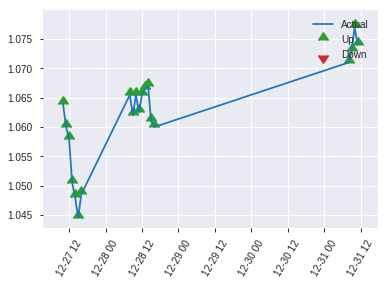


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2553776189989555
RMSE: 0.5053490071217668
LogLoss: 0.7049313433367501
Null degrees of freedom: 222
Residual degrees of freedom: -816
Null deviance: 308.7824388019844
Residual deviance: 314.39937912819056
AIC: 2392.3993791281905
AUC: 0.5065259426361586
pr_auc: 0.5317089926054351
Gini: 0.013051885272317154
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23643945155697504: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    107  1        (107.0/107.0)
1      0    116  0        (0.0/116.0)
Total  0    223  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.236439     0.684366  222
max f2                       0.236439     0.84425   222
max f0point5                 0.236439     0.575397  222
max accuracy                 0.539083     0.524664  83
max precision                0.598266     0.653846  25
max recall                   0.236439     1         222
max specificity              0.777905     0.990654  0
max absolute_mcc             0.43342      0.119836  204
max min_per_class_accuracy   0.516708     0.517241  109
max mean_per_class_accuracy  0.598266     0.53122   25

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 52.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.707138           0.640805  0.640805           0.333333         0.740996  0.333333                    0.740996            0.00862069      0.00862069                 -35.9195  -35.9195
    2        0.0224215                   0.66321            0.961207  0.768966           0.5              0.674175  0.4                         0.714268            0.00862069      0.0172414                  -3.87931  -23.1034
    3        0.0313901                   0.638474           0.961207  0.823892           0.5              0.647331  0.428571                    0.695143            0.00862069      0.0258621                  -3.87931  -17.6108
    4        0.0403587                   0.626436           1.92241   1.06801            1                0.63407   0.555556                    0.681571            0.0172414       0.0431034                  92.2414   6.80077
    5        0.0538117                   0.622603           1.28161   1.12141            0.666667         0.624124  0.583333                    0.667209            0.0172414       0.0603448                  28.1609   12.1408
    6        0.103139                    0.601059           1.22335   1.17016            0.636364         0.613043  0.608696                    0.641304            0.0603448       0.12069                    22.3354   17.0165
    7        0.152466                    0.58613            1.04859   1.13083            0.545455         0.592696  0.588235                    0.625578            0.0517241       0.172414                   4.85893   13.0832
    8        0.201794                    0.573444           0.873824  1.06801            0.454545         0.579804  0.555556                    0.614389            0.0431034       0.215517                   -12.6176  6.80077
    9        0.300448                    0.552598           0.961207  1.03294            0.5              0.560503  0.537313                    0.596695            0.0948276       0.310345                   -3.87931  3.29388
    10       0.399103                    0.533303           1.13597   1.05841            0.590909         0.545385  0.550562                    0.584012            0.112069        0.422414                   13.5972   5.84076
    11       0.502242                    0.515239           0.919415  1.02986            0.478261         0.524585  0.535714                    0.571808            0.0948276       0.517241                   -8.05847  2.98645
    12       0.600897                    0.500837           1.04859   1.03294            0.545455         0.50854   0.537313                    0.561421            0.103448        0.62069                    4.85893   3.29388
    13       0.699552                    0.488321           0.786442  0.998176           0.409091         0.494458  0.519231                    0.551977            0.0775862       0.698276                   -21.3558  -0.182361
    14       0.798206                    0.472144           0.873824  0.982807           0.454545         0.48068   0.511236                    0.543165            0.0862069       0.784483                   -12.6176  -1.71929
    15       0.896861                    0.44049            0.961207  0.980431           0.5              0.462033  0.51                        0.534241            0.0948276       0.87931                    -3.87931  -1.9569
    16       1                           0.236439           1.17016   1                  0.608696         0.396491  0.520179                    0.520033   

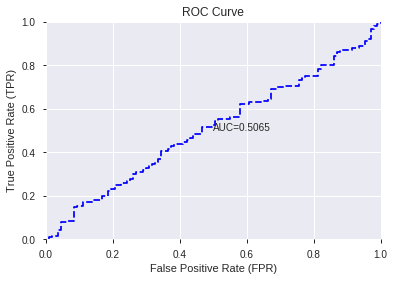

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


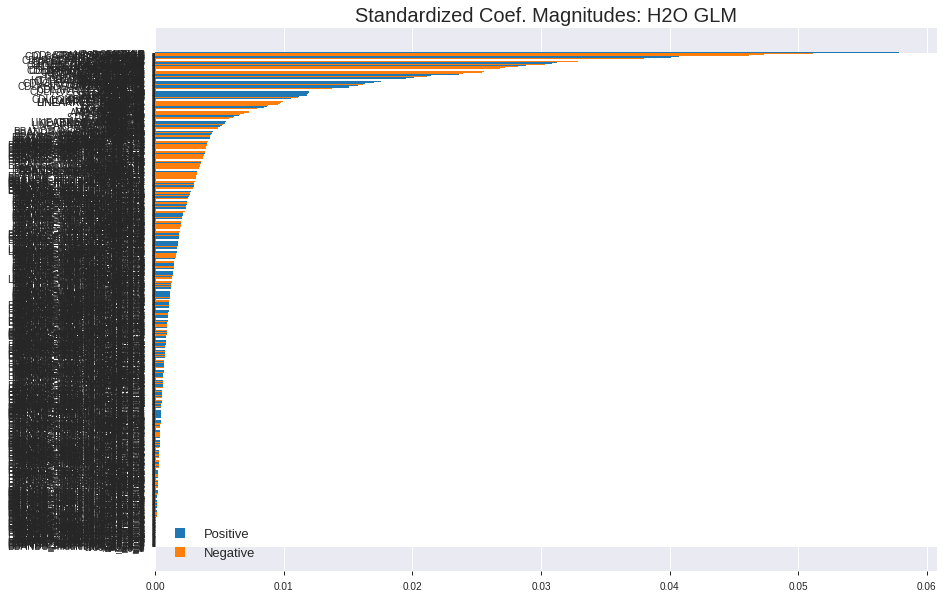

'log_likelihood'
--2019-08-27 14:54:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.160
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.160|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_145311_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_145311_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['HT_DCPERIOD',
 'DX_8',
 'SAREXT',
 'CDLGRAVESTONEDOJI',
 'CDL3INSIDE',
 'CDLHANGINGMAN',
 'CDLGAPSIDESIDEWHITE',
 'CDL3LINESTRIKE',
 'CDLONNECK',
 'BETA_30',
 'CDLSHOOTINGSTAR',
 'CDLENGULFING',
 'Volume',
 'hour',
 'DX_12',
 'CDLRISEFALL3METHODS',
 'CCI_12',
 'CDLSEPARATINGLINES',
 'CORREL_20',
 'BETA_8',
 'CDLEVENINGDOJISTAR',
 'day',
 'quarter',
 'aroonup_30',
 'BETA_12',
 'CDLMORNINGDOJISTAR',
 'CDLLONGLINE',
 'CDLHARAMICROSS',
 'CDLCOUNTERATTACK',
 'CDLHIKKAKE',
 'CDLMORNINGSTAR',
 'CDLDOJISTAR',
 'HT_TRENDMODE',
 'MFI_24',
 'CDLHARAMI',
 'CDLDARKCLOUDCOVER',
 'CDLIDENTICAL3CROWS',
 'CDLUNIQUE3RIVER',
 'CORREL_30',
 'CCI_8',
 'CDLLADDERBOTTOM',
 'CDLTASUKIGAP',
 'is_month_end',
 'HT_PHASOR_inphase',
 'BOP',
 'DX_14',
 'CDLHOMINGPIGEON',
 'BETA_24',
 'CCI_30',
 'days_in_month',
 'OBV',
 'aroondown_24',
 'STOCHF_fastk',
 'MFI_8',
 'CDLMATCHINGLOW',
 'CDLEVENINGSTAR',
 'CDL3OUTSIDE',
 'HT_PHASOR_quadrature',
 'CDLSTALLEDPATTERN',
 'aroondown_30',
 'is_month_start',
 'VAR_8',
 'DX_3

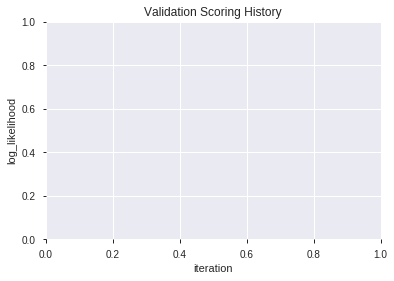

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190827_145410  0.550193  0.698520              0.500000  0.502590  0.252597
1  XGBoost_grid_1_AutoML_20190827_145410_model_7  0.532549  0.707772              0.500000  0.506512  0.256554
2  XGBoost_grid_1_AutoML_20190827_145410_model_4  0.531018  0.695137              0.500000  0.500945  0.250946
3  XGBoost_grid_1_AutoML_20190827_145410_model_3  0.515147  0.703909              0.480946  0.505047  0.255072
4               XGBoost_2_AutoML_20190827_145410  0.513858  0.710865              0.495327  0.508184  0.258251
5  XGBoost_grid_1_AutoML_20190827_145410_model_6  0.506526  0.706855              0.495327  0.506448  0.256489
6  XGBoost_grid_1_AutoML_20190827_145410_model_2  0.506204  0.703066              0.500000  0.504702  0.254724
7  XGBoost_grid_1_AutoML_20190827_145410_model_1  0.498993  0.714122              0.500000  0.510013  0.260113
8  XGBoost_grid_1_AutoML_20190827_145410_model_5  0.488801  0.742240              0.490292  0.521655  0.272124
9               XGBoost_1_AutoML_20190827_145410  0.485256  0.724168              0.495327  0.514414  0.264622

variable  relative_importance  scaled_importance  percentage
0                         BOP            97.326263           1.000000    0.018031
1                      CCI_12            95.042908           0.976539    0.017608
2                       DX_30            91.101036           0.936038    0.016878
3              STOCHRSI_fastd            89.428513           0.918853    0.016568
4        HT_PHASOR_quadrature            82.719559           0.849920    0.015325
..                        ...                  ...                ...         ...
311  BBANDS_middleband_30_5_2             0.402773           0.004138    0.000075
312         MACDFIX_signal_12             0.323591           0.003325    0.000060
313   BBANDS_upperband_12_4_5             0.163100           0.001676    0.000030
314   BBANDS_lowerband_20_1_2             0.100738           0.001035    0.000019
315   BBANDS_lowerband_20_5_3             0.036095           0.000371    0.000007

[316 rows x 4 columns]

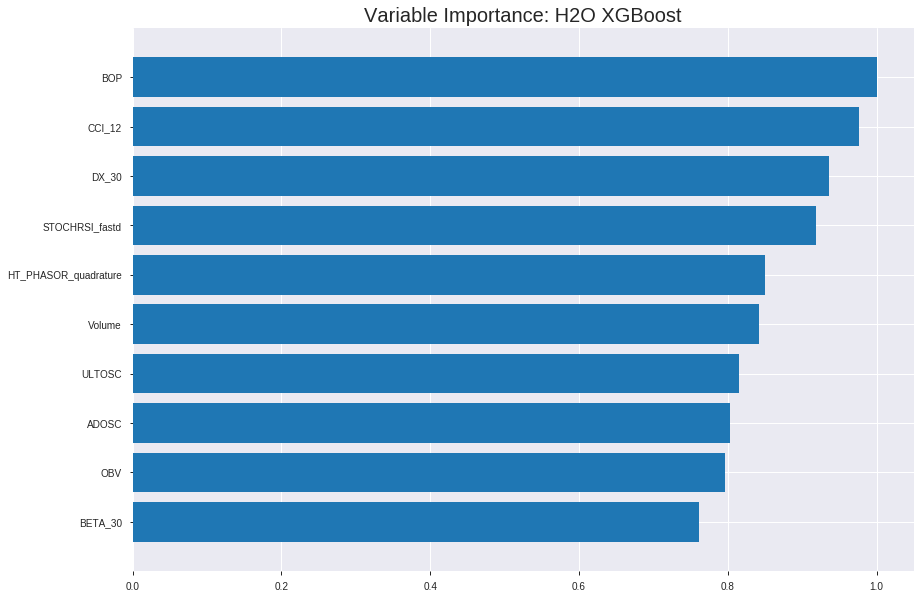

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190827_145410


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17152760080342802
RMSE: 0.4141589076712319
LogLoss: 0.5311811540066472
Mean Per-Class Error: 0.10454170202980262
AUC: 0.9586470519139109
pr_auc: 0.9611553844964705
Gini: 0.9172941038278217
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5267897397279739: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      669  80   0.1068   (80.0/749.0)
1      83   724  0.1029   (83.0/807.0)
Total  752  804  0.1048   (163.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.52679      0.898821  189
max f2                       0.45797      0.924409  249
max f0point5                 0.539461     0.909454  175
max accuracy                 0.528633     0.895244  187
max precision                0.812768     1         0
max recall                   0.377648     1         319
max specificity              0.812768     1         0
max absolute_mcc             0.528633     0.790495  187
max min_per_class_accuracy   0.527807     0.894672  188
max mean_per_class_accuracy  0.528633     0.895458  187

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 51.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.74507            1.92813    1.92813            1                0.775082  1                           0.775082            0.0198265       0.0198265                  92.8129   92.8129
    2        0.0205656                   0.715932           1.92813    1.92813            1                0.727455  1                           0.751269            0.0198265       0.039653                   92.8129   92.8129
    3        0.0302057                   0.70242            1.92813    1.92813            1                0.709615  1                           0.737975            0.0185874       0.0582404                  92.8129   92.8129
    4        0.0404884                   0.696673           1.92813    1.92813            1                0.699607  1                           0.728231            0.0198265       0.0780669                  92.8129   92.8129
    5        0.0501285                   0.690531           1.92813    1.92813            1                0.693127  1                           0.72148             0.0185874       0.0966543                  92.8129   92.8129
    6        0.100257                    0.662676           1.92813    1.92813            1                0.674528  1                           0.698004            0.0966543       0.193309                   92.8129   92.8129
    7        0.150386                    0.643623           1.90341    1.91989            0.987179         0.653873  0.995726                    0.683294            0.0954151       0.288724                   90.3409   91.9889
    8        0.200514                    0.629533           1.92813    1.92195            1                0.636154  0.996795                    0.671509            0.0966543       0.385378                   92.8129   92.1949
    9        0.300129                    0.594971           1.82861    1.89097            0.948387         0.612794  0.980728                    0.652021            0.182156        0.567534                   82.8613   89.097
    10       0.400386                    0.563415           1.73037    1.85076            0.897436         0.580187  0.959872                    0.634034            0.173482        0.741016                   73.0372   85.0756
    11       0.5                         0.530797           1.36835    1.75465            0.709677         0.547181  0.910026                    0.61673             0.136307        0.877323                   36.835    75.4647
    12       0.600257                    0.49124            0.716868   1.58131            0.371795         0.513825  0.820128                    0.599543            0.0718711       0.949195                   -28.3132  58.1313
    13       0.699871                    0.447063           0.348307   1.40582            0.180645         0.467716  0.729109                    0.580779            0.0346964       0.983891                   -65.1693  40.5817
    14       0.800129                    0.400673           0.135958   1.2467             0.0705128        0.424915  0.646586                    0.561249            0.0136307       0.997522                   -86.4042  24.6702
    15       0.899743                    0.352948           0.0248791  1.11143            0.0129032        0.377912  0.576429                    0.540951            0.00247831      1                          -97.5121  11.1429
    16       1                           0.20417            0          1                  0                0.302482  0.518638                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.253032709129876
RMSE: 0.5030235671714358
LogLoss: 0.7000926546457904
Mean Per-Class Error: 0.4503496644837901
AUC: 0.540383216104778
pr_auc: 0.5383904341697234
Gini: 0.08076643220955604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2302316427230835: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    217  1        (217.0/217.0)
1      0    228  0        (0.0/228.0)
Total  0    445  0.4876   (217.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.230232     0.677563  399
max f2                       0.230232     0.840088  399
max f0point5                 0.43757      0.571682  320
max accuracy                 0.540914     0.548315  177
max precision                0.760312     1         0
max recall                   0.230232     1         399
max specificity              0.760312     1         0
max absolute_mcc             0.575059     0.100324  112
max min_per_class_accuracy   0.52757      0.525346  197
max mean_per_class_accuracy  0.540914     0.54965   177

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 51.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.704891           0.780702  0.780702           0.4              0.723501  0.4                         0.723501            0.00877193      0.00877193                 -21.9298   -21.9298
    2        0.0202247                   0.683555           1.46382   1.08431            0.75             0.696762  0.555556                    0.711617            0.0131579       0.0219298                  46.3816    8.4308
    3        0.0314607                   0.667279           0.780702  0.975877           0.4              0.676101  0.5                         0.698933            0.00877193      0.0307018                  -21.9298   -2.41228
    4        0.0404494                   0.662392           1.46382   1.08431            0.75             0.664905  0.555556                    0.691371            0.0131579       0.0438596                  46.3816    8.4308
    5        0.0516854                   0.65628            0.780702  1.01831            0.4              0.659514  0.521739                    0.684446            0.00877193      0.0526316                  -21.9298   1.83066
    6        0.101124                    0.633075           1.06459   1.04094            0.545455         0.644656  0.533333                    0.664993            0.0526316       0.105263                   6.45933    4.09357
    7        0.150562                    0.609729           1.06459   1.0487             0.545455         0.620434  0.537313                    0.650362            0.0526316       0.157895                   6.45933    4.87038
    8        0.2                         0.594782           1.50817   1.16228            0.772727         0.601329  0.595506                    0.638241            0.0745614       0.232456                   50.8174    16.2281
    9        0.301124                    0.569471           1.08431   1.1361             0.555556         0.580404  0.58209                     0.618818            0.109649        0.342105                   8.4308     13.6096
    10       0.4                         0.549968           0.931519  1.08553            0.477273         0.56079   0.55618                     0.604474            0.0921053       0.434211                   -6.84809   8.55263
    11       0.501124                    0.52757            0.910819  1.05027            0.466667         0.538845  0.538117                    0.591231            0.0921053       0.526316                   -8.91813   5.02714
    12       0.6                         0.504685           0.887161  1.02339            0.454545         0.514664  0.524345                    0.578613            0.0877193       0.614035                   -11.2839   2.33918
    13       0.698876                    0.480745           1.06459   1.02922            0.545455         0.493423  0.527331                    0.56656             0.105263        0.719298                   6.45933    2.9221
    14       0.8                         0.448752           0.997563  1.02522            0.511111         0.46736   0.525281                    0.554021            0.100877        0.820175                   -0.243665  2.52193
    15       0.898876                    0.389596           0.842803  1.00515            0.431818         0.421513  0.515                       0.539445            0.0833333       0.903509                   -15.7197   0.515351
    16       1                           0.230232           0.954191  1                  0.488889         0.338662  0.51236                     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 14:54:22  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.481362                         0.5                0.693147              0.5               0                    1                  0.48764
    2019-08-27 14:54:24  1.167 sec   5                  0.4879           0.669182            0.785857        0.786947           1.68711          0.308483                         0.499506           0.69216               0.532581          0.523982             0                  0.485393
    2019-08-27 14:54:24  1.377 sec   10                 0.477165         0.648272            0.84415         0.843225           1.80762          0.239717                         0.499751           0.692672              0.534229          0.533531             0                  0.476404
    2019-08-27 14:54:24  1.580 sec   15                 0.468038         0.630717            0.872241        0.87603            1.92813          0.212082                         0.498917           0.691018              0.548367          0.548382             0.780702           0.476404
    2019-08-27 14:54:24  1.814 sec   20                 0.456203         0.608257            0.896716        0.901048           1.92813          0.185733                         0.498521           0.690336              0.562232          0.56402              1.5614             0.48764
    2019-08-27 14:54:24  2.021 sec   25                 0.449115         0.594915            0.904546        0.907105           1.92813          0.172237                         0.498861           0.691056              0.559211          0.554507             1.17105            0.478652
    2019-08-27 14:54:25  2.235 sec   30                 0.440921         0.579733            0.92114         0.923496           1.92813          0.153599                         0.498634           0.690637              0.560029          0.552955             1.17105            0.476404
    2019-08-27 14:54:25  2.440 sec   35                 0.435135         0.568963            0.92654         0.930654           1.92813          0.158098                         0.499044           0.69156               0.557978          0.555609             0.780702           0.48764
    2019-08-27 14:54:25  2.641 sec   40                 0.429343         0.558355            0.935838        0.939445           1.92813          0.142031                         0.501133           0.695907              0.546063          0.547632             0.780702           0.476404
    2019-08-27 14:54:25  2.860 sec   45                 0.421343         0.543966            0.948775        0.951862           1.92813          0.125964                         0.502775           0.699407              0.538726          0.537954             0.780702           0.48764
    2019-08-27 14:54:25  3.073 sec   50                 0.414159         0.531181            0.958647        0.961155           1.92813          0.104756                         0.503024           0.700093              0.540383          0.53839              0.780702           0.48764

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ----------------------
BOP                       97.32626342773438      1.0                    0.018031389817300465
CCI_12                    95.04290771484375      0.976539161861628      0.01760835829938689
DX_30                     91.10103607177734      0.9360375387206834     0.01687805774429912
STOCHRSI_fastd            89.42851257324219      0.9188528298905019     0.016568193560485313
HT_PHASOR_quadrature      82.71955871582031      0.8499202147757406     0.015325242706225116
---                       ---                    ---                    ---
BBANDS_middleband_30_5_2  0.402773380279541      0.004138383269780041   7.462080195079844e-05
MACDFIX_signal_12         0.3235912322998047     0.0033248089560129275  5.995092635392089e-05
BBANDS_upperband_12_4_5   0.1631002426147461     0.0016758091482249238  3.021716801104186e-05
BBANDS_lowerband_20_1_2   0.1007375717163086     0.0010350502338056689  1.8663394246238006e-05
BBANDS_lowerband_20_5_3   0.03609466552734375    0.0003708625427107285  6.687167076252388e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5515695067264574)

('F1', 0.6843657817109144)

('auc', 0.5501933612632935)

('logloss', 0.6985196697328888)

('mean_per_class_error', 0.4346600064453754)

('rmse', 0.5025904389383964)

('mse', 0.25259714931229)

xgboost prediction progress: |████████████████████████████████████████████| 100%


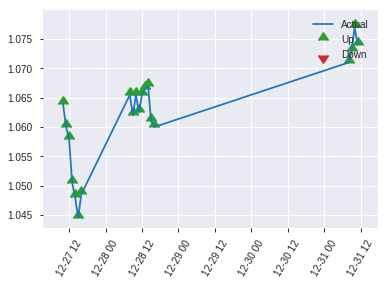


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25259714931229
RMSE: 0.5025904389383964
LogLoss: 0.6985196697328888
Mean Per-Class Error: 0.4346600064453754
AUC: 0.5501933612632935
pr_auc: 0.5768431249709259
Gini: 0.10038672252658709
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35251590609550476: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    107  1        (107.0/107.0)
1      0    116  0        (0.0/116.0)
Total  0    223  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352516     0.684366  222
max f2                       0.352516     0.84425   222
max f0point5                 0.524245     0.581551  157
max accuracy                 0.650076     0.55157   35
max precision                0.755645     1         0
max recall                   0.352516     1         222
max specificity              0.755645     1         0
max absolute_mcc             0.650076     0.177443  35
max min_per_class_accuracy   0.565307     0.523364  111
max mean_per_class_accuracy  0.650076     0.56534   35

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 56.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.726488           1.28161   1.28161            0.666667         0.740354  0.666667                    0.740354            0.0172414       0.0172414                  28.1609   28.1609
    2        0.0224215                   0.706542           0.961207  1.15345            0.5              0.710325  0.6                         0.728342            0.00862069      0.0258621                  -3.87931  15.3448
    3        0.0313901                   0.698232           1.92241   1.37315            1                0.700963  0.714286                    0.720519            0.0172414       0.0431034                  92.2414   37.3153
    4        0.0403587                   0.691783           1.92241   1.49521            1                0.695262  0.777778                    0.714907            0.0172414       0.0603448                  92.2414   49.5211
    5        0.0538117                   0.688691           0.640805  1.28161            0.333333         0.690309  0.666667                    0.708757            0.00862069      0.0689655                  -35.9195  28.1609
    6        0.103139                    0.663564           1.22335   1.25375            0.636364         0.676294  0.652174                    0.693231            0.0603448       0.12931                    22.3354   25.3748
    7        0.152466                    0.65091            1.57288   1.357              0.818182         0.655048  0.705882                    0.680878            0.0775862       0.206897                   57.2884   35.6998
    8        0.201794                    0.644398           0.873824  1.23889            0.454545         0.646995  0.644444                    0.672595            0.0431034       0.25                       -12.6176  23.8889
    9        0.300448                    0.611836           0.873824  1.11902            0.454545         0.628643  0.58209                     0.658163            0.0862069       0.336207                   -12.6176  11.9017
    10       0.399103                    0.592961           1.13597   1.12321            0.590909         0.60299   0.58427                     0.644525            0.112069        0.448276                   13.5972   12.3208
    11       0.502242                    0.565307           0.752249  1.04703            0.391304         0.581872  0.544643                    0.631659            0.0775862       0.525862                   -24.7751  4.70289
    12       0.600897                    0.541801           1.04859   1.04729            0.545455         0.556013  0.544776                    0.619239            0.103448        0.62931                    4.85893   4.72851
    13       0.699552                    0.524485           1.04859   1.04747            0.545455         0.532019  0.544872                    0.606939            0.103448        0.732759                   4.85893   4.74691
    14       0.798206                    0.500328           0.786442  1.01521            0.409091         0.514864  0.52809                     0.595559            0.0775862       0.810345                   -21.3558  1.52073
    15       0.896861                    0.463364           0.611677  0.970819           0.318182         0.484002  0.505                       0.583287            0.0603448       0.87069                    -38.8323  -2.9181
    16       1                           0.352516           1.25375   1                  0.652174         0.433405  0.520179                    0.567829         

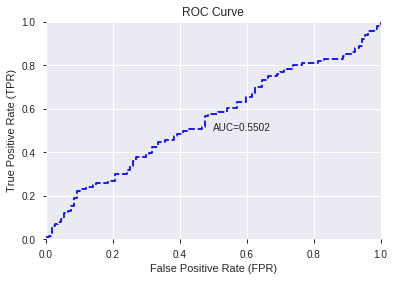

This function is available for GLM models only


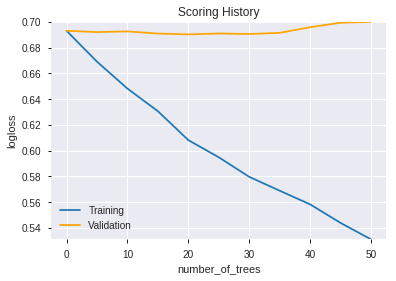

--2019-08-27 14:55:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190827_145410',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190827_145410',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_bac4',
   'type

['BOP',
 'CCI_12',
 'DX_30',
 'STOCHRSI_fastd',
 'HT_PHASOR_quadrature',
 'Volume',
 'ULTOSC',
 'ADOSC',
 'OBV',
 'BETA_30',
 'BETA_8',
 'DX_8',
 'STOCH_slowd',
 'AD',
 'PLUS_DM_8',
 'CCI_8',
 'HT_DCPERIOD',
 'STDDEV_12',
 'PLUS_DM_24',
 'PLUS_DM_30',
 'ROC_8',
 'MFI_8',
 'APO',
 'PLUS_DI_8',
 'DIV',
 'STOCHF_fastd',
 'BBANDS_lowerband_12_2_3',
 'ADX_20',
 'CCI_30',
 'LINEARREG_ANGLE_8',
 'BBANDS_lowerband_30_0_4',
 'TRANGE',
 'STDDEV_8',
 'ADX_14',
 'HT_PHASOR_inphase',
 'AROONOSC_20',
 'MFI_24',
 'MFI_14',
 'BBANDS_lowerband_30_6_4',
 'LINEARREG_ANGLE_14',
 'MOM_24',
 'hour',
 'CORREL_20',
 'SAREXT',
 'LINEARREG_ANGLE_20',
 'STOCHRSI_fastk',
 'CDLDOJI',
 'CMO_24',
 'WILLR_8',
 'LINEARREG_ANGLE_30',
 'DX_20',
 'BBANDS_lowerband_30_7_5',
 'BETA_14',
 'MINUS_DI_20',
 'WILLR_24',
 'STDDEV_24',
 'day',
 'MFI_20',
 'ADXR_8',
 'NATR_8',
 'MACDEXT_signal',
 'MACDEXT_hist',
 'PLUS_DM_20',
 'STDDEV_30',
 'MFI_12',
 'STDDEV_20',
 'DX_12',
 'VAR_30',
 'CORREL_12',
 'BBANDS_lowerband_30_6_3',
 'M

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

395

['BBANDS_upperband_14_0_2',
 'BBANDS_middleband_14_0_2',
 'BBANDS_lowerband_14_0_2',
 'BBANDS_upperband_14_0_3',
 'BBANDS_middleband_14_0_3',
 'BBANDS_lowerband_14_0_3',
 'BBANDS_upperband_14_0_4',
 'BBANDS_middleband_14_0_4',
 'BBANDS_lowerband_14_0_4',
 'BBANDS_upperband_14_0_5',
 'BBANDS_middleband_14_0_5',
 'BBANDS_lowerband_14_0_5',
 'MA_14_1',
 'MAVP_14_1',
 'BBANDS_upperband_14_1_2',
 'BBANDS_middleband_14_1_2',
 'BBANDS_lowerband_14_1_2',
 'BBANDS_upperband_14_1_3',
 'BBANDS_middleband_14_1_3',
 'BBANDS_lowerband_14_1_3',
 'BBANDS_upperband_14_1_4',
 'BBANDS_middleband_14_1_4',
 'BBANDS_lowerband_14_1_4',
 'BBANDS_upperband_14_1_5',
 'BBANDS_middleband_14_1_5',
 'BBANDS_lowerband_14_1_5',
 'MA_14_2',
 'MAVP_14_2',
 'BBANDS_upperband_14_2_2',
 'BBANDS_middleband_14_2_2',
 'BBANDS_lowerband_14_2_2',
 'BBANDS_upperband_14_2_3',
 'BBANDS_middleband_14_2_3',
 'BBANDS_lowerband_14_2_3',
 'BBANDS_upperband_14_2_4',
 'BBANDS_middleband_14_2_4',
 'BBANDS_lowerband_14_2_4',
 'BBANDS_uppe

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_145612_model_6  0.559579  0.690311              0.500000  0.498587  0.248589
1  DeepLearning_grid_1_AutoML_20190827_145612_model_1  0.546568  1.889539              0.485619  0.627861  0.394209
2               DeepLearning_1_AutoML_20190827_145612  0.534644  0.775984              0.456856  0.526538  0.277243
3  DeepLearning_grid_1_AutoML_20190827_145612_model_2  0.534160  0.735736              0.485619  0.515088  0.265315
4  DeepLearning_grid_1_AutoML_20190827_145612_model_3  0.525701  0.747516              0.500000  0.521852  0.272330
5  DeepLearning_grid_1_AutoML_20190827_145612_model_9  0.517322  0.693241              0.500000  0.500047  0.250047
6  DeepLearning_grid_1_AutoML_20190827_145612_model_7  0.514583  0.736507              0.495327  0.518527  0.268870
7  DeepLearning_grid_1_AutoML_20190827_145612_model_8  0.505761  0.692295              0.500000  0.499574  0.249574
8  DeepLearning_grid_1_AutoML_20190827_145612_model_5  0.504109  0.706935              0.500000  0.506799  0.256845
9  DeepLearning_grid_1_AutoML_20190827_145612_model_4  0.491379  1.011951              0.495327  0.585744  0.343096

variable  relative_importance  scaled_importance  percentage
0       HT_DCPERIOD             1.000000           1.000000    0.003093
1                AD             0.985367           0.985367    0.003048
2               OBV             0.981645           0.981645    0.003036
3          CORREL_8             0.979880           0.979880    0.003031
4    STOCHRSI_fastk             0.973344           0.973344    0.003011
..              ...                  ...                ...         ...
390     CDLMARUBOZU             0.704955           0.704955    0.002180
391      CDL3INSIDE             0.697457           0.697457    0.002157
392  CDL3LINESTRIKE             0.687637           0.687637    0.002127
393     CDL3OUTSIDE             0.686536           0.686536    0.002123
394  CDLHARAMICROSS             0.684988           0.684988    0.002119

[395 rows x 4 columns]

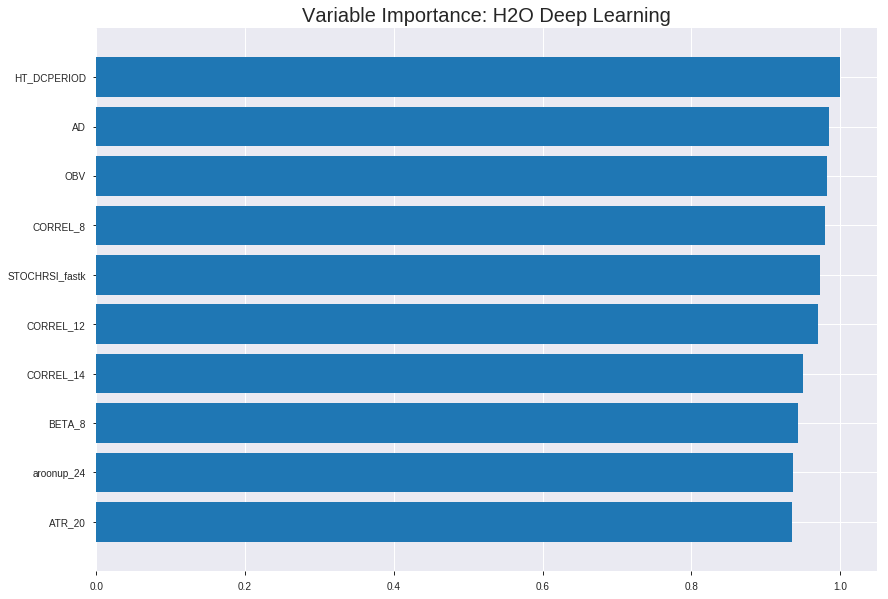

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_145612_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24544103123075864
RMSE: 0.49542005533764844
LogLoss: 0.6835722010542723
Mean Per-Class Error: 0.44596430101763107
AUC: 0.5644758893725298
pr_auc: 0.5946304034436584
Gini: 0.1289517787450596
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4386495214347143: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      22   727   0.9706   (727.0/749.0)
1      3    804   0.0037   (3.0/807.0)
Total  25   1531  0.4692   (730.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43865      0.687767  375
max f2                       0.399428     0.845735  386
max f0point5                 0.455907     0.581182  340
max accuracy                 0.496965     0.553985  194
max precision                0.796422     1         0
max recall                   0.399428     1         386
max specificity              0.796422     1         0
max absolute_mcc             0.532162     0.146354  82
max min_per_class_accuracy   0.49671      0.552737  195
max mean_per_class_accuracy  0.496965     0.554036  194

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 49.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.656864           1.68711   1.68711            0.875            0.705154  0.875                       0.705154            0.0173482       0.0173482                  68.7113   68.7113
    2        0.0205656                   0.598642           1.68711   1.68711            0.875            0.620627  0.875                       0.66289             0.0173482       0.0346964                  68.7113   68.7113
    3        0.0302057                   0.575166           1.28542   1.55891            0.666667         0.585977  0.808511                    0.638343            0.0123916       0.047088                   28.5419   55.8913
    4        0.0404884                   0.550342           1.4461    1.53026            0.75             0.562066  0.793651                    0.618971            0.0148699       0.0619579                  44.6097   53.0261
    5        0.0501285                   0.541438           1.41396   1.5079             0.733333         0.545174  0.782051                    0.60478             0.0136307       0.0755886                  41.3961   50.7896
    6        0.100257                    0.519086           1.16182   1.33486            0.602564         0.528813  0.692308                    0.566797            0.0582404       0.133829                   16.1821   33.4858
    7        0.150386                    0.510436           1.03822   1.23598            0.538462         0.514403  0.641026                    0.549332            0.0520446       0.185874                   3.82232   23.598
    8        0.200514                    0.507319           1.0135    1.18036            0.525641         0.508557  0.612179                    0.539138            0.0508055       0.236679                   1.35036   18.0361
    9        0.300129                    0.503725           0.908087  1.08999            0.470968         0.50524   0.56531                     0.527887            0.0904585       0.327138                   -9.19135  8.99915
    10       0.409383                    0.501781           1.10017   1.09271            0.570588         0.502207  0.566719                    0.521034            0.120198        0.447336                   10.0168   9.27073
    11       0.5                         0.496944           1.16235   1.10533            0.602837         0.499271  0.573265                    0.51709             0.105328        0.552664                   16.2347   10.5328
    12       0.600257                    0.490682           0.914625  1.07348            0.474359         0.4938    0.556745                    0.5132              0.0916976       0.644362                   -8.53748  7.34765
    13       0.699871                    0.48432            0.920526  1.05171            0.477419         0.487565  0.545455                    0.509551            0.0916976       0.736059                   -7.9474   5.17067
    14       0.800129                    0.472698           0.865186  1.02834            0.448718         0.47898   0.533333                    0.505721            0.086741        0.8228                     -13.4814  2.83354
    15       0.899743                    0.459181           0.932966  1.01778            0.483871         0.466345  0.527857                    0.501361            0.0929368       0.915737                   -6.70344  1.77766
    16       1                           0.0947594          0.840466  1                  0.435897         0.43523   0.518638                    0.494731          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24985253775364746
RMSE: 0.49985251600211783
LogLoss: 0.692879156622522
Mean Per-Class Error: 0.4725927722532137
AUC: 0.5007175196054653
pr_auc: 0.5245104760653267
Gini: 0.0014350392109305776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3163274998931832: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    216  0.9954   (216.0/217.0)
1      0    228  0        (0.0/228.0)
Total  1    444  0.4854   (216.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.316327     0.678571  398
max f2                       0.316327     0.840708  398
max f0point5                 0.472596     0.572456  349
max accuracy                 0.493546     0.532584  275
max precision                0.648081     1         0
max recall                   0.316327     1         398
max specificity              0.648081     1         0
max absolute_mcc             0.60138      0.114053  5
max min_per_class_accuracy   0.501781     0.483871  193
max mean_per_class_accuracy  0.493546     0.527407  275

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 49.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.011236                    0.601654           1.95175   1.95175            1                0.627682  1                           0.627682            0.0219298       0.0219298                  95.1754    95.1754
    2        0.0202247                   0.576354           0.975877  1.51803            0.5              0.591488  0.777778                    0.611596            0.00877193      0.0307018                  -2.41228   51.8031
    3        0.0314607                   0.562084           0.780702  1.2547             0.4              0.568123  0.642857                    0.59607             0.00877193      0.0394737                  -21.9298   25.4699
    4        0.0404494                   0.536044           0.975877  1.19274            0.5              0.544404  0.611111                    0.584589            0.00877193      0.0482456                  -2.41228   19.2739
    5        0.0516854                   0.528466           1.5614    1.27288            0.8              0.533179  0.652174                    0.573413            0.0175439       0.0657895                  56.1404    27.2883
    6        0.101124                    0.515355           0.798445  1.04094            0.409091         0.520042  0.533333                    0.54732             0.0394737       0.105263                   -20.1555   4.09357
    7        0.150562                    0.511331           1.06459   1.0487             0.545455         0.513036  0.537313                    0.536063            0.0526316       0.157895                   6.45933    4.87038
    8        0.2                         0.508848           0.709729  0.964912           0.363636         0.510086  0.494382                    0.529641            0.0350877       0.192982                   -29.0271   -3.50877
    9        0.301124                    0.505887           0.780702  0.903051           0.4              0.507026  0.462687                    0.522047            0.0789474       0.27193                    -21.9298   -9.69495
    10       0.4                         0.503816           1.10895   0.953947           0.568182         0.50464   0.488764                    0.517744            0.109649        0.381579                   10.8951    -4.60526
    11       0.507865                    0.501781           1.09786   0.984513           0.5625           0.502741  0.504425                    0.514557            0.118421        0.5                        9.78618    -1.54867
    12       0.6                         0.499615           1.04728   0.994152           0.536585         0.500811  0.509363                    0.512446            0.0964912       0.596491                   4.72828    -0.584795
    13       0.698876                    0.494201           1.24203   1.02922            0.636364         0.497285  0.527331                    0.510301            0.122807        0.719298                   24.2026    2.9221
    14       0.8                         0.486449           0.997563  1.02522            0.511111         0.491298  0.525281                    0.507899            0.100877        0.820175                   -0.243665  2.52193
    15       0.898876                    0.471339           0.975877  1.01979            0.5              0.479065  0.5225                      0.504728            0.0964912       0.916667                   -2.41228   1.97917
    16       1                           0.285742           0.824074  1                  0.422222         0.439746  0.51236                


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 15:02:56  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 15:02:57  3 min 27.167 sec  634 obs/sec       0.703085  1             1094       0.616993         1.26275             -0.524841      0.535868        0.545678           0.843556         0.481362                         0.623436           1.31043               -0.555639        0.561969          0.570144             1.5614             0.483146
    2019-08-27 15:03:08  3 min 38.175 sec  931 obs/sec       6.97943   10            10860      0.497623         0.688329            0.00810725     0.553242        0.578404           1.5666           0.465296                         0.50125            0.695639              -0.00562262      0.5162            0.530017             1.95175            0.478652
    2019-08-27 15:03:20  3 min 49.596 sec  1083 obs/sec      15.3657   22            23909      0.498588         0.690249            0.00425825     0.551815        0.575921           1.68711          0.47108                          0.501064           0.695415              -0.004875        0.513966          0.534257             1.17105            0.476404
    2019-08-27 15:03:30  4 min  0.211 sec  1167 obs/sec      23.7706   34            36987      0.49542          0.683572            0.0168699      0.564476        0.59463            1.68711          0.469152                         0.499853           0.692879              -2.11979e-05     0.500718          0.52451              1.95175            0.485393
    2019-08-27 15:03:41  4 min 10.950 sec  1233 obs/sec      32.8329   47            51088      0.493491         0.679163            0.0245112      0.582884        0.611809           1.92813          0.465938                         0.507256           0.71065               -0.0298655       0.490025          0.503911             1.17105            0.485393
    2019-08-27 15:03:52  4 min 21.595 sec  1280 obs/sec      41.9974   60            65348      0.490182         0.671921            0.0375473      0.597889        0.630757           1.92813          0.448586                         0.507573           0.711248              -0.0311524       0.496412          0.512663             1.17105            0.48764
    2019-08-27 15:04:02  4 min 32.069 sec  1315 obs/sec      51.1433   73            79579      0.485663         0.661668            0.0552121      0.623735        0.654088           1.92813          0.451157                         0.505385           0.714801              -0.0222813       0.544133          0.549277             0.780702           0.48764
    2019-08-27 15:04:03  4 min 33.141 sec  1314 obs/sec      51.1433   73            79579      0.49542          0.683572            0.0168699      0.564476        0.59463            1.68711          0.469152                         0.499853           0.692879              -2.11979e-05     0.500718          0.52451              1.95175            0.485393

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ---------------------
HT_DCPERIOD     1.0                    1.0                  0.0030929463136539228
AD              0.9853668212890625     0.9853668212890625   0.0030476866775028897
OBV             0.9816454648971558     0.9816454648971558   0.0030361767219687493
CORREL_8        0.9798804521560669     0.9798804521560669   0.003030717632317646
STOCHRSI_fastk  0.9733442664146423     0.9733442664146423   0.0030105015607233498
---             ---                    ---                  ---
CDLMARUBOZU     0.7049553394317627     0.7049553394317627   0.0021803890183861203
CDL3INSIDE      0.6974565982818604     0.6974565982818604   0.002157195814589485
CDL3LINESTRIKE  0.6876365542411804     0.6876365542411804   0.0021268229455739447
CDL3OUTSIDE     0.686536431312561      0.686536431312561    0.002123420324417305
CDLHARAMICROSS  0.6849875450134277     0.6849875450134277   0.002118629702248132


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5605381165919282)

('F1', 0.6843657817109144)

('auc', 0.5595794392523364)

('logloss', 0.6903109598192338)

('mean_per_class_error', 0.4375201417982597)

('rmse', 0.4985873490181485)

('mse', 0.24858934460094503)

deeplearning prediction progress: |███████████████████████████████████████| 100%


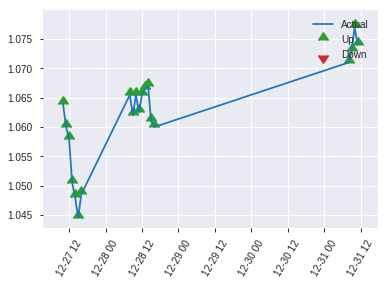


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24858934460094503
RMSE: 0.4985873490181485
LogLoss: 0.6903109598192338
Mean Per-Class Error: 0.4375201417982597
AUC: 0.5595794392523364
pr_auc: 0.6120143761274606
Gini: 0.11915887850467288
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36149672700448465: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    107  1        (107.0/107.0)
1      0    116  0        (0.0/116.0)
Total  0    223  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.361497     0.684366  221
max f2                       0.361497     0.84425   221
max f0point5                 0.498482     0.582298  130
max accuracy                 0.498817     0.560538  128
max precision                0.659677     1         0
max recall                   0.361497     1         221
max specificity              0.659677     1         0
max absolute_mcc             0.526838     0.19696   8
max min_per_class_accuracy   0.501781     0.53271   110
max mean_per_class_accuracy  0.511146     0.56248   26

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 49.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.545399           1.92241   1.92241            1                0.604836  1                           0.604836            0.0258621       0.0258621                  92.2414   92.2414
    2        0.0224215                   0.531232           1.92241   1.92241            1                0.533599  1                           0.576341            0.0172414       0.0431034                  92.2414   92.2414
    3        0.0313901                   0.528788           1.92241   1.92241            1                0.52982   1                           0.56305             0.0172414       0.0603448                  92.2414   92.2414
    4        0.0403587                   0.526295           1.92241   1.92241            1                0.52762   1                           0.555176            0.0172414       0.0775862                  92.2414   92.2414
    5        0.0538117                   0.523351           0.640805  1.60201            0.333333         0.52472   0.833333                    0.547562            0.00862069      0.0862069                  -35.9195  60.2011
    6        0.103139                    0.512598           1.39812   1.5045             0.727273         0.516412  0.782609                    0.532664            0.0689655       0.155172                   39.8119   50.4498
    7        0.152466                    0.51002            0.873824  1.30046            0.454545         0.510961  0.676471                    0.525643            0.0431034       0.198276                   -12.6176  30.0456
    8        0.201794                    0.508598           0.873824  1.19617            0.454545         0.509136  0.622222                    0.521608            0.0431034       0.241379                   -12.6176  19.6169
    9        0.300448                    0.506293           1.13597   1.1764             0.590909         0.50715   0.61194                     0.51686             0.112069        0.353448                   13.5972   17.6402
    10       0.399103                    0.504015           0.873824  1.10161            0.454545         0.50534   0.573034                    0.514013            0.0862069       0.439655                   -12.6176  10.1608
    11       0.502242                    0.501781           0.919415  1.06419            0.478261         0.502716  0.553571                    0.511693            0.0948276       0.534483                   -8.05847  6.41933
    12       0.600897                    0.498369           1.13597   1.07598            0.590909         0.499747  0.559701                    0.509732            0.112069        0.646552                   13.5972   7.59779
    13       0.699552                    0.494426           0.786442  1.03515            0.409091         0.49661   0.538462                    0.507881            0.0775862       0.724138                   -21.3558  3.51459
    14       0.798206                    0.488614           0.69906   0.993607           0.363636         0.492024  0.516854                    0.505921            0.0689655       0.793103                   -30.094   -0.639287
    15       0.896861                    0.473913           1.04859   0.999655           0.545455         0.48313   0.52                        0.503414            0.103448        0.896552                   4.85893   -0.0344828
    16       1                           0.361497           1.003     1                  0.521739         0.456125  0.520179                    0.498537    

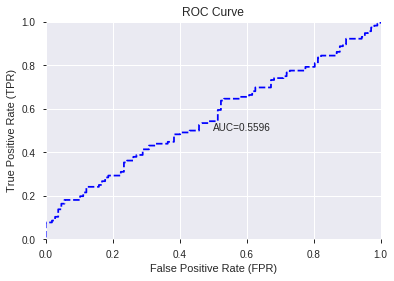

This function is available for GLM models only


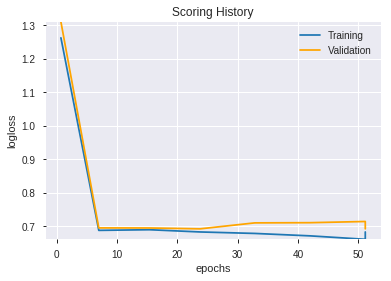

--2019-08-27 15:08:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_145612_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_145612_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_DCPERIOD',
 'AD',
 'OBV',
 'CORREL_8',
 'STOCHRSI_fastk',
 'CORREL_12',
 'CORREL_14',
 'BETA_8',
 'aroonup_24',
 'ATR_20',
 'BETA_12',
 'aroondown_12',
 'AROONOSC_14',
 'STDDEV_8',
 'DX_12',
 'ADX_20',
 'aroonup_30',
 'DX_14',
 'MFI_24',
 'ATR_12',
 'NATR_20',
 'aroondown_30',
 'aroondown_14',
 'AROONOSC_20',
 'STDDEV_12',
 'NATR_8',
 'ATR_14',
 'MOM_12',
 'ADXR_14',
 'STOCHF_fastk',
 'AROONOSC_24',
 'VAR_12',
 'STDDEV_14',
 'CCI_12',
 'BBANDS_middleband_14_5_4',
 'MINUS_DI_20',
 'NATR_24',
 'MACDFIX_signal_24',
 'NATR_14',
 'AROONOSC_30',
 'MINUS_DM_20',
 'MFI_20',
 'ATR_24',
 'aroondown_8',
 'ADX_14',
 'CDLHANGINGMAN',
 'BBANDS_upperband_14_3_3',
 'BETA_14',
 'PLUS_DM_30',
 'RSI_14',
 'CDLRICKSHAWMAN',
 'aroondown_20',
 'CORREL_20',
 'LINEARREG_SLOPE_14',
 'MACDFIX_signal_20',
 'aroonup_14',
 'MINUS_DM_30',
 'ADX_8',
 'PLUS_DM_14',
 'PLUS_DM_12',
 'MACDFIX_hist_12',
 'CDLLONGLEGGEDDOJI',
 'ROCP_24',
 'MINUS_DM_24',
 'VAR_8',
 'STOCH_slowd',
 'MFI_14',
 'WILLR_8',
 'MA_24_0',
 'M

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_150849_model_1  0.538833  0.695167              0.490654  0.500752  0.250752

variable  relative_importance  scaled_importance  percentage
0                 HT_DCPERIOD             0.081115           1.000000    0.025238
1                       DX_12             0.063593           0.783992    0.019787
2                  CDL3INSIDE             0.056907           0.701563    0.017706
3                   CDLONNECK             0.054010           0.665847    0.016805
4              CDL3LINESTRIKE             0.053296           0.657050    0.016583
..                        ...                  ...                ...         ...
390   BBANDS_upperband_14_5_3             0.000014           0.000177    0.000004
391   BBANDS_lowerband_14_4_2             0.000010           0.000128    0.000003
392                 MAVP_24_1             0.000008           0.000094    0.000002
393  BBANDS_middleband_14_2_2             0.000007           0.000084    0.000002
394                   MA_14_2             0.000004           0.000043    0.000001

[395 rows x 4 columns]

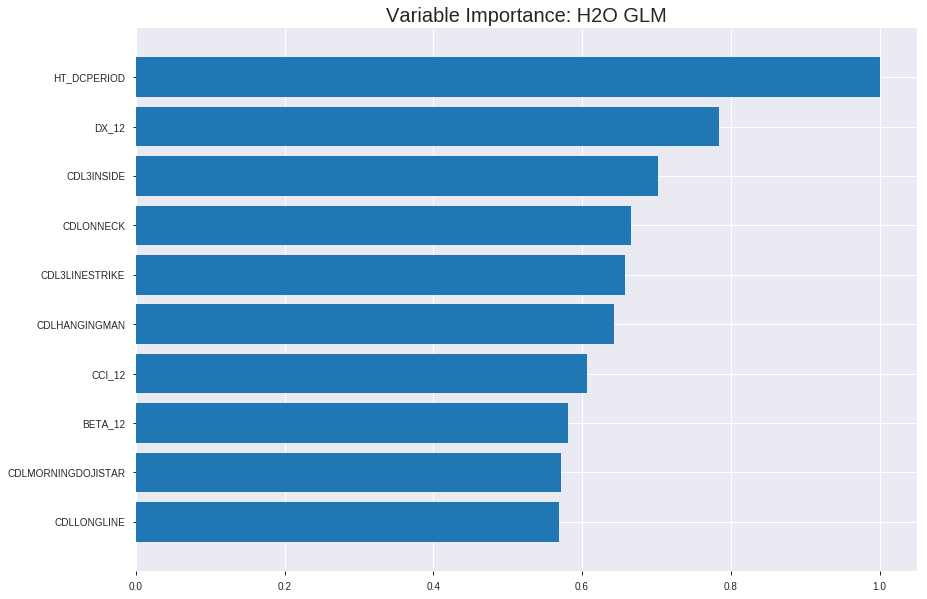

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_150849_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23900984721498283
RMSE: 0.48888633363490824
LogLoss: 0.6705381843932617
Null degrees of freedom: 1555
Residual degrees of freedom: 1160
Null deviance: 2154.9115712492066
Residual deviance: 2086.7148298318307
AIC: 2878.7148298318307
AUC: 0.6271765906793527
pr_auc: 0.6333963773453201
Gini: 0.25435318135870544
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4152836275388486: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      53   696   0.9292   (696.0/749.0)
1      15   792   0.0186   (15.0/807.0)
Total  68   1488  0.4569   (711.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.415284     0.690196  353
max f2                       0.361297     0.846105  381
max f0point5                 0.513039     0.617627  209
max accuracy                 0.516349     0.602828  201
max precision                0.818006     1         0
max recall                   0.314179     1         389
max specificity              0.818006     1         0
max absolute_mcc             0.516349     0.203556  201
max min_per_class_accuracy   0.52073      0.596796  192
max mean_per_class_accuracy  0.516349     0.601555  201

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 51.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.66657            1.5666    1.5666             0.8125           0.734107  0.8125                      0.734107            0.016109        0.016109                   56.6605   56.6605
    2        0.0205656                   0.634583           1.68711   1.62686            0.875            0.651235  0.84375                     0.692671            0.0173482       0.0334572                  68.7113   62.6859
    3        0.0302057                   0.626726           1.15688   1.47686            0.6              0.629931  0.765957                    0.672647            0.0111524       0.0446097                  15.6877   47.6865
    4        0.0404884                   0.618144           1.5666    1.49966            0.8125           0.622051  0.777778                    0.659798            0.016109        0.0607187                  56.6605   49.9656
    5        0.0501285                   0.610183           1.15688   1.43374            0.6              0.614565  0.74359                     0.651099            0.0111524       0.0718711                  15.6877   43.3737
    6        0.100257                    0.587569           1.35958   1.39666            0.705128         0.597819  0.724359                    0.624459            0.0681537       0.140025                   35.9578   39.6657
    7        0.150386                    0.575282           1.2607    1.35134            0.653846         0.581575  0.700855                    0.610164            0.063197        0.203222                   26.07     35.1338
    8        0.200514                    0.565924           1.1371    1.29778            0.589744         0.570019  0.673077                    0.600128            0.0570012       0.260223                   13.7102   29.7779
    9        0.300129                    0.549569           1.132     1.24276            0.587097         0.557513  0.64454                     0.585984            0.112763        0.372986                   13.1998   24.2755
    10       0.400386                    0.535448           1.06294   1.19773            0.551282         0.542353  0.621188                    0.575059            0.106568        0.479554                   6.29428   19.773
    11       0.5                         0.520808           1.10712   1.17968            0.574194         0.527446  0.611825                    0.565573            0.110285        0.589839                   10.7119   17.9678
    12       0.600257                    0.508676           0.926985  1.13747            0.480769         0.514633  0.589936                    0.557065            0.0929368       0.682776                   -7.3015   13.7472
    13       0.699871                    0.491929           0.920526  1.10659            0.477419         0.499985  0.573921                    0.54894             0.0916976       0.774473                   -7.9474   10.6594
    14       0.800129                    0.474903           0.803387  1.0686             0.416667         0.48316   0.554217                    0.540698            0.0805452       0.855019                   -19.6613  6.86015
    15       0.899743                    0.444181           0.845889  1.04394            0.43871          0.461008  0.541429                    0.531875            0.0842627       0.939281                   -15.4111  4.39441
    16       1                           0.179885           0.60563   1                  0.314103         0.399837  0.518638                    0.518638          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24485985799204305
RMSE: 0.49483316177479764
LogLoss: 0.6826293610144516
Null degrees of freedom: 444
Residual degrees of freedom: 49
Null deviance: 616.6992856395483
Residual deviance: 607.5401313028619
AIC: 1399.540131302862
AUC: 0.5885985124100573
pr_auc: 0.588672787249294
Gini: 0.17719702482011468
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3642068254766138: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   203  0.9355   (203.0/217.0)
1      3    225  0.0132   (3.0/228.0)
Total  17   428  0.4629   (206.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.364207     0.685976  382
max f2                       0.311582     0.843819  393
max f0point5                 0.418892     0.586207  336
max accuracy                 0.490894     0.570787  174
max precision                0.567084     0.757576  32
max recall                   0.311582     1         393
max specificity              0.772458     0.995392  0
max absolute_mcc             0.519547     0.16231   97
max min_per_class_accuracy   0.480222     0.56682   203
max mean_per_class_accuracy  0.490894     0.572803  174

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 47.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.633387           1.17105   1.17105            0.6              0.678308  0.6                         0.678308            0.0131579       0.0131579                  17.1053   17.1053
    2        0.0202247                   0.606124           0.975877  1.08431            0.5              0.615883  0.555556                    0.650563            0.00877193      0.0219298                  -2.41228  8.4308
    3        0.0314607                   0.594895           1.5614    1.2547             0.8              0.601241  0.642857                    0.632948            0.0175439       0.0394737                  56.1404   25.4699
    4        0.0404494                   0.584226           1.46382   1.30117            0.75             0.588158  0.666667                    0.622995            0.0131579       0.0526316                  46.3816   30.117
    5        0.0516854                   0.578405           1.5614    1.35774            0.8              0.581254  0.695652                    0.613921            0.0175439       0.0701754                  56.1404   35.7742
    6        0.101124                    0.550118           1.41946   1.38791            0.727273         0.562999  0.711111                    0.589026            0.0701754       0.140351                   41.9458   38.7914
    7        0.150562                    0.535087           0.798445  1.19436            0.409091         0.543341  0.61194                     0.574025            0.0394737       0.179825                   -20.1555  19.4357
    8        0.2                         0.524894           1.41946   1.25               0.727273         0.530785  0.640449                    0.563336            0.0701754       0.25                       41.9458   25
    9        0.301124                    0.507728           1.04094   1.17979            0.533333         0.515934  0.604478                    0.547418            0.105263        0.355263                   4.09357   17.9792
    10       0.4                         0.491743           1.06459   1.15132            0.545455         0.498783  0.589888                    0.535396            0.105263        0.460526                   6.45933   15.1316
    11       0.501124                    0.480383           1.04094   1.12904            0.533333         0.486956  0.578475                    0.525621            0.105263        0.565789                   4.09357   12.9042
    12       0.6                         0.470082           0.931519  1.09649            0.477273         0.475883  0.561798                    0.517424            0.0921053       0.657895                   -6.84809  9.64912
    13       0.698876                    0.455242           0.887161  1.06688            0.454545         0.462848  0.546624                    0.509703            0.0877193       0.745614                   -11.2839  6.68754
    14       0.8                         0.435942           0.824074  1.03618            0.422222         0.443961  0.530899                    0.501393            0.0833333       0.828947                   -17.5926  3.61842
    15       0.898876                    0.401              1.02024   1.03443            0.522727         0.419542  0.53                        0.492389            0.100877        0.929825                   2.02352   3.44298
    16       1                           0.171547           0.693957  1                  0.355556         0.357708  0.51236                     0.47877             0.07


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 15:08:49  0.000 sec   2            2.8       396           1.37501           1.37559
    2019-08-27 15:08:50  0.341 sec   4            2         396           1.37297           1.37435
    2019-08-27 15:08:50  0.664 sec   6            1.5       396           1.37049           1.37298
    2019-08-27 15:08:50  0.998 sec   8            1.1       396           1.36754           1.37158
    2019-08-27 15:08:51  1.337 sec   10           0.79      396           1.36411           1.37013
    2019-08-27 15:08:51  1.653 sec   12           0.57      396           1.36019           1.3687
    2019-08-27 15:08:51  1.978 sec   14           0.42      396           1.35584           1.36739
    2019-08-27 15:08:52  2.328 sec   16           0.3       396           1.35113           1.36628
    2019-08-27 15:08:52  2.660 sec   18           0.22      396           1.34617           1.36555
    2019-08-27 15:08:52  2.993 sec   20           0.16      396           1.34108           1.36526
    2019-08-27 15:08:53  3.333 sec   22           0.12      396           1.33598           1.36547
    2019-08-27 15:08:53  3.685 sec   24           0.085     396           1.33097           1.36615
    2019-08-27 15:08:53  4.025 sec   26           0.062     396           1.32613           1.36727
    2019-08-27 15:08:54  4.373 sec   28           0.045     396           1.32155           1.36878
    2019-08-27 15:08:54  4.710 sec   30           0.033     396           1.31717           1.37052

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5515695067264574)

('F1', 0.6884272997032642)

('auc', 0.5388333870447953)

('logloss', 0.6951670491219597)

('mean_per_class_error', 0.44698678698034167)

('rmse', 0.5007516931147277)

('mse', 0.2507522581572664)

glm prediction progress: |████████████████████████████████████████████████| 100%


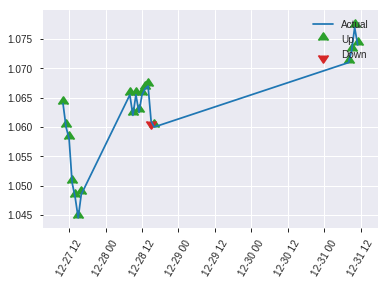


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2507522581572664
RMSE: 0.5007516931147277
LogLoss: 0.6951670491219597
Null degrees of freedom: 222
Residual degrees of freedom: -173
Null deviance: 308.7824388019844
Residual deviance: 310.044503908394
AIC: 1102.044503908394
AUC: 0.5388333870447953
pr_auc: 0.5428333492472402
Gini: 0.07766677408959066
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32407628656614196: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    105  0.9813   (105.0/107.0)
1      0    116  0        (0.0/116.0)
Total  2    221  0.4709   (105.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.324076     0.688427  220
max f2                       0.324076     0.846715  220
max f0point5                 0.419399     0.585443  207
max accuracy                 0.49661      0.55157   103
max precision                0.603519     0.625     7
max recall                   0.324076     1         220
max specificity              0.782295     0.990654  0
max absolute_mcc             0.49661      0.106181  103
max min_per_class_accuracy   0.493676     0.543103  110
max mean_per_class_accuracy  0.49661      0.553013  103

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 49.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.662619           0.640805  0.640805           0.333333         0.721168  0.333333                    0.721168            0.00862069      0.00862069                 -35.9195  -35.9195
    2        0.0224215                   0.622985           0.961207  0.768966           0.5              0.639356  0.4                         0.688443            0.00862069      0.0172414                  -3.87931  -23.1034
    3        0.0313901                   0.60637            1.92241   1.09852            1                0.613253  0.571429                    0.66696             0.0172414       0.0344828                  92.2414   9.85222
    4        0.0403587                   0.602519           0.961207  1.06801            0.5              0.603265  0.555556                    0.652806            0.00862069      0.0431034                  -3.87931  6.80077
    5        0.0538117                   0.600208           0.640805  0.961207           0.333333         0.601566  0.5                         0.639996            0.00862069      0.0517241                  -35.9195  -3.87931
    6        0.103139                    0.576041           1.22335   1.08658            0.636364         0.585837  0.565217                    0.614094            0.0603448       0.112069                   22.3354   8.65817
    7        0.152466                    0.558208           1.22335   1.13083            0.636364         0.565984  0.588235                    0.598529            0.0603448       0.172414                   22.3354   13.0832
    8        0.201794                    0.541258           1.04859   1.11073            0.545455         0.550102  0.577778                    0.586691            0.0517241       0.224138                   4.85893   11.0728
    9        0.300448                    0.524278           0.961207  1.06163            0.5              0.531834  0.552239                    0.568678            0.0948276       0.318966                   -3.87931  6.16315
    10       0.399103                    0.508358           1.13597   1.08001            0.590909         0.517161  0.561798                    0.555944            0.112069        0.431034                   13.5972   8.00077
    11       0.502242                    0.493439           1.08658   1.08136            0.565217         0.500162  0.5625                      0.544489            0.112069        0.543103                   8.65817   8.13578
    12       0.600897                    0.482303           0.873824  1.04729            0.454545         0.487376  0.544776                    0.535112            0.0862069       0.62931                    -12.6176  4.72851
    13       0.699552                    0.469828           0.786442  1.0105             0.409091         0.476455  0.525641                    0.52684             0.0775862       0.706897                   -21.3558  1.04996
    14       0.798206                    0.452445           1.04859   1.01521            0.545455         0.461431  0.52809                     0.518756            0.103448        0.810345                   4.85893   1.52073
    15       0.896861                    0.433257           1.04859   1.01888            0.545455         0.445298  0.53                        0.510675            0.103448        0.913793                   4.85893   1.88793
    16       1                           0.242051           0.835832  1                  0.434783         0.392464  0.520179                    0.498483      

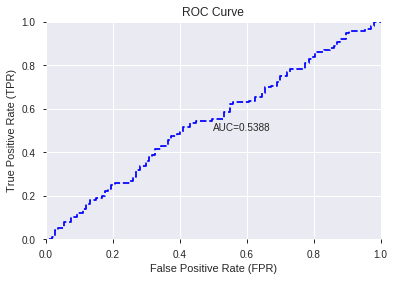

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


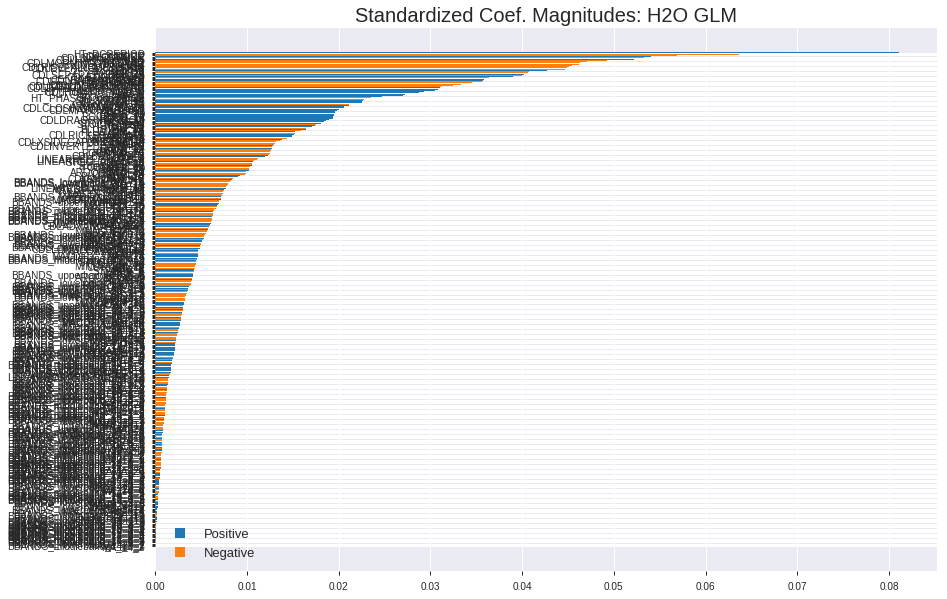

'log_likelihood'
--2019-08-27 15:09:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_150849_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_150849_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['HT_DCPERIOD',
 'DX_12',
 'CDL3INSIDE',
 'CDLONNECK',
 'CDL3LINESTRIKE',
 'CDLHANGINGMAN',
 'CCI_12',
 'BETA_12',
 'CDLMORNINGDOJISTAR',
 'CDLLONGLINE',
 'OBV',
 'CDLRISEFALL3METHODS',
 'CDLEVENINGDOJISTAR',
 'BETA_8',
 'aroonup_30',
 'MFI_24',
 'DX_14',
 'CDLSEPARATINGLINES',
 'CORREL_20',
 'CDLENGULFING',
 'CCI_8',
 'CDLHARAMICROSS',
 'CDLCOUNTERATTACK',
 'CDLHIKKAKE',
 'CDLHARAMI',
 'CDLUNIQUE3RIVER',
 'CDLIDENTICAL3CROWS',
 'CDLTASUKIGAP',
 'CDLDARKCLOUDCOVER',
 'CCI_30',
 'HT_PHASOR_inphase',
 'CDLHOMINGPIGEON',
 'VAR_8',
 'MFI_8',
 'STOCHF_fastk',
 'aroondown_30',
 'HT_PHASOR_quadrature',
 'CCI_14',
 'CDL3OUTSIDE',
 'DX_30',
 'aroondown_24',
 'AROONOSC_24',
 'MOM_14',
 'MINUS_DM_8',
 'CDLCLOSINGMARUBOZU',
 'CDLMATCHINGLOW',
 'ULTOSC',
 'ROCP_30',
 'ROC_30',
 'ROCR100_14',
 'ROCR_14',
 'ROC_14',
 'ROCP_14',
 'CDLDRAGONFLYDOJI',
 'MOM_30',
 'STOCH_slowk',
 'STOCHF_fastd',
 'TRANGE',
 'CCI_24',
 'VAR_12',
 'PLUS_DM_24',
 'WILLR_14',
 'PLUS_DM_20',
 'ADX_24',
 'MFI_12',
 'CDLRICKSHA

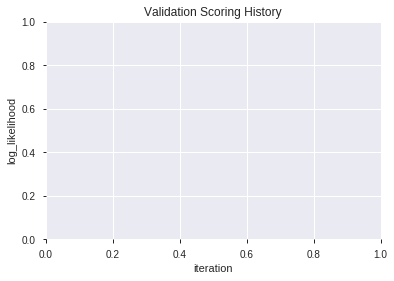

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_150913_model_5  0.548421  0.720061              0.490654  0.510757  0.260872
1  XGBoost_grid_1_AutoML_20190827_150913_model_2  0.527715  0.696910              0.500000  0.501812  0.251816
2               XGBoost_1_AutoML_20190827_150913  0.515308  0.710699              0.494965  0.507955  0.258018
3               XGBoost_3_AutoML_20190827_150913  0.514583  0.702259              0.485256  0.504288  0.254306
4  XGBoost_grid_1_AutoML_20190827_150913_model_6  0.514260  0.717717              0.500000  0.511459  0.261590
5  XGBoost_grid_1_AutoML_20190827_150913_model_4  0.512166  0.700165              0.500000  0.503343  0.253354
6               XGBoost_2_AutoML_20190827_150913  0.509507  0.710326              0.500000  0.507881  0.257943
7  XGBoost_grid_1_AutoML_20190827_150913_model_3  0.508218  0.709670              0.500000  0.507640  0.257698
8  XGBoost_grid_1_AutoML_20190827_150913_model_1  0.495529  0.712668              0.489929  0.509219  0.259304
9  XGBoost_grid_1_AutoML_20190827_150913_model_7  0.454399  0.728253              0.495327  0.516384  0.266653

variable  relative_importance  scaled_importance  percentage
0     BBANDS_upperband_14_0_2           412.810577           1.000000    0.019141
1        HT_PHASOR_quadrature           326.055481           0.789843    0.015119
2                       CCI_8           308.020721           0.746155    0.014282
3                      BETA_8           282.280090           0.683801    0.013089
4                       MFI_8           279.316040           0.676620    0.012951
..                        ...                  ...                ...         ...
341   BBANDS_upperband_20_2_4             2.116323           0.005127    0.000098
342            CDLMATCHINGLOW             1.974118           0.004782    0.000092
343  BBANDS_middleband_20_3_5             1.445090           0.003501    0.000067
344  BBANDS_middleband_14_0_5             1.286826           0.003117    0.000060
345  BBANDS_middleband_14_4_3             0.277159           0.000671    0.000013

[346 rows x 4 columns]

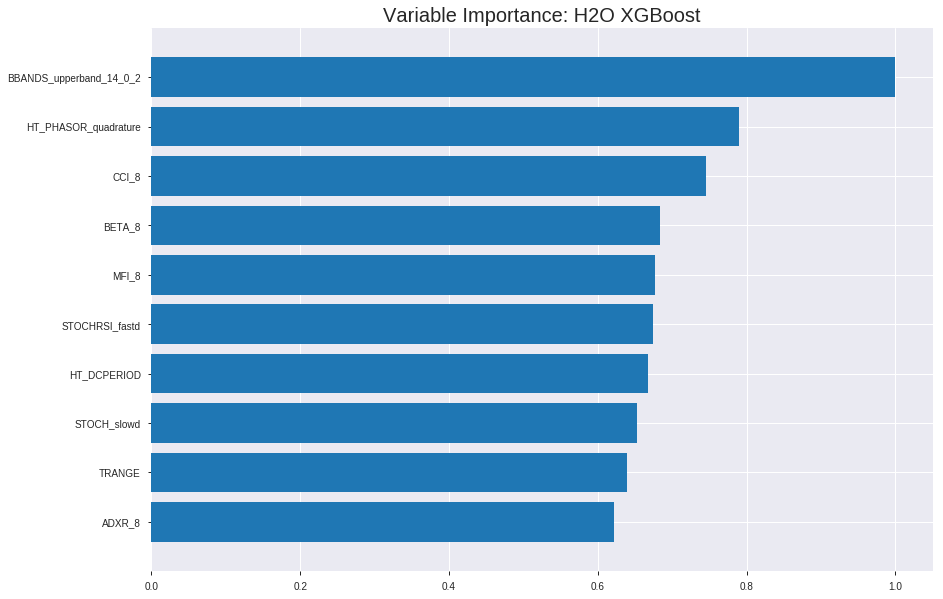

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_150913_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.04035587232888665
RMSE: 0.2008877107462939
LogLoss: 0.21315449425912544
Mean Per-Class Error: 0.0
AUC: 1.0
pr_auc: 0.9987608426270136
Gini: 1.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45833247900009155: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      749  0    0        (0.0/749.0)
1      0    807  0        (0.0/807.0)
Total  749  807  0        (0.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.458332     1        200
max f2                       0.458332     1        200
max f0point5                 0.458332     1        200
max accuracy                 0.458332     1        200
max precision                0.928822     1        0
max recall                   0.458332     1        200
max specificity              0.928822     1        0
max absolute_mcc             0.458332     1        200
max min_per_class_accuracy   0.458332     1        200
max mean_per_class_accuracy  0.458332     1        200

Gains/Lift Table: Avg response rate: 51.86 %, avg score: 51.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.917014           1.92813   1.92813            1                0.9226    1                           0.9226              0.0198265       0.0198265                  92.8129   92.8129
    2        0.0205656                   0.910401           1.92813   1.92813            1                0.913475  1                           0.918037            0.0198265       0.039653                   92.8129   92.8129
    3        0.0302057                   0.900829           1.92813   1.92813            1                0.904936  1                           0.913856            0.0185874       0.0582404                  92.8129   92.8129
    4        0.0404884                   0.898125           1.92813   1.92813            1                0.899123  1                           0.910114            0.0198265       0.0780669                  92.8129   92.8129
    5        0.0501285                   0.893767           1.92813   1.92813            1                0.895438  1                           0.907292            0.0185874       0.0966543                  92.8129   92.8129
    6        0.100257                    0.876262           1.92813   1.92813            1                0.88498   1                           0.896136            0.0966543       0.193309                   92.8129   92.8129
    7        0.150386                    0.85604            1.92813   1.92813            1                0.865529  1                           0.885934            0.0966543       0.289963                   92.8129   92.8129
    8        0.200514                    0.841307           1.92813   1.92813            1                0.849452  1                           0.876813            0.0966543       0.386617                   92.8129   92.8129
    9        0.300129                    0.814514           1.92813   1.92813            1                0.828706  1                           0.860846            0.192069        0.578686                   92.8129   92.8129
    10       0.400386                    0.775162           1.92813   1.92813            1                0.795873  1                           0.844577            0.193309        0.771995                   92.8129   92.8129
    11       0.5                         0.68149            1.92813   1.92813            1                0.740229  1                           0.823788            0.192069        0.964064                   92.8129   92.8129
    12       0.600257                    0.263703           0.358434  1.66595            0.185897         0.371195  0.864026                    0.748194            0.0359356       1                          -64.1566  66.5953
    13       0.699871                    0.210653           0         1.42883            0                0.233784  0.741047                    0.674977            0               1                          -100      42.8834
    14       0.800129                    0.16757            0         1.2498             0                0.189131  0.648193                    0.6141              0               1                          -100      24.9799
    15       0.899743                    0.133784           0         1.11143            0                0.149908  0.576429                    0.562707            0               1                          -100      11.1429
    16       1                           0.0689027          0         1                  0                0.111709  0.518638                    0.517491         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2638277408815472
RMSE: 0.513641646365973
LogLoss: 0.7262978674526671
Mean Per-Class Error: 0.4602837739510065
AUC: 0.5366137116986014
pr_auc: 0.553764038729827
Gini: 0.07322742339720278
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1351383775472641: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    216  0.9954   (216.0/217.0)
1      0    228  0        (0.0/228.0)
Total  1    444  0.4854   (216.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.135138     0.678571   398
max f2                       0.135138     0.840708   398
max f0point5                 0.375595     0.569853   314
max accuracy                 0.576316     0.534831   121
max precision                0.826556     1          0
max recall                   0.135138     1          398
max specificity              0.826556     1          0
max absolute_mcc             0.611499     0.0900493  100
max min_per_class_accuracy   0.481725     0.525346   202
max mean_per_class_accuracy  0.576316     0.539716   121

Gains/Lift Table: Avg response rate: 51.24 %, avg score: 49.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.815018           1.17105   1.17105            0.6              0.819331  0.6                         0.819331            0.0131579       0.0131579                  17.1053   17.1053
    2        0.0202247                   0.802643           1.46382   1.30117            0.75             0.808562  0.666667                    0.814545            0.0131579       0.0263158                  46.3816   30.117
    3        0.0314607                   0.778766           1.17105   1.2547             0.6              0.789591  0.642857                    0.805633            0.0131579       0.0394737                  17.1053   25.4699
    4        0.0404494                   0.765909           0.975877  1.19274            0.5              0.772449  0.611111                    0.798259            0.00877193      0.0482456                  -2.41228  19.2739
    5        0.0516854                   0.75655            1.17105   1.18802            0.6              0.761789  0.608696                    0.79033             0.0131579       0.0614035                  17.1053   18.8024
    6        0.101124                    0.705048           1.06459   1.12768            0.545455         0.730955  0.577778                    0.761302            0.0526316       0.114035                   6.45933   12.768
    7        0.150562                    0.668938           1.15331   1.1361             0.590909         0.683723  0.58209                     0.735829            0.0570175       0.171053                   15.3309   13.6096
    8        0.2                         0.631949           0.975877  1.09649            0.5              0.652716  0.561798                    0.715284            0.0482456       0.219298                   -2.41228  9.64912
    9        0.301124                    0.578734           1.17105   1.12153            0.6              0.607123  0.574627                    0.678961            0.118421        0.337719                   17.1053   12.1531
    10       0.4                         0.526961           0.931519  1.07456            0.477273         0.554736  0.550562                    0.648254            0.0921053       0.429825                   -6.84809  7.45614
    11       0.501124                    0.481725           0.954191  1.05027            0.488889         0.505756  0.538117                    0.619499            0.0964912       0.526316                   -4.5809   5.02714
    12       0.6                         0.446367           0.842803  1.01608            0.431818         0.46364   0.520599                    0.593814            0.0833333       0.609649                   -15.7197  1.60819
    13       0.698876                    0.416446           0.887161  0.997842           0.454545         0.428661  0.511254                    0.570449            0.0877193       0.697368                   -11.2839  -0.215773
    14       0.8                         0.367527           1.21442   1.02522            0.622222         0.393105  0.525281                    0.548031            0.122807        0.820175                   21.4425   2.52193
    15       0.898876                    0.28976            0.887161  1.01003            0.454545         0.328657  0.5175                      0.5239              0.0877193       0.907895                   -11.2839  1.00329
    16       1                           0.0984204          0.910819  1                  0.466667         0.226412  0.51236                     0.493817         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 15:09:28  7.284 sec   0                  0.5              0.693147            0.5             0                  1                0.481362                         0.5                0.693147              0.5               0                    1                  0.48764
    2019-08-27 15:09:28  7.983 sec   5                  0.447835         0.593452            0.966089        0.965607           1.92813          0.0919023                        0.500931           0.695061              0.5258            0.534154             0.780702           0.480899
    2019-08-27 15:09:29  8.403 sec   10                 0.402087         0.512619            0.993816        0.992767           1.92813          0.0366324                        0.501221           0.695691              0.527276          0.546438             1.17105            0.485393
    2019-08-27 15:09:29  8.800 sec   15                 0.362665         0.447223            0.998708        0.997635           1.92813          0.0115681                        0.501576           0.696515              0.536381          0.567954             1.95175            0.48764
    2019-08-27 15:09:30  9.201 sec   20                 0.328859         0.394172            0.99968         0.998477           1.92813          0.00642674                       0.506458           0.7072                0.524133          0.545141             1.95175            0.48764
    2019-08-27 15:09:30  9.627 sec   25                 0.29936          0.349577            0.999836        0.998613           1.92813          0.00514139                       0.508277           0.711364              0.521859          0.541598             1.5614             0.48764
    2019-08-27 15:09:30  10.072 sec  30                 0.27148          0.309117            0.999968        0.998731           1.92813          0.00128535                       0.507633           0.710686              0.536169          0.547509             0.780702           0.485393
    2019-08-27 15:09:31  10.502 sec  35                 0.251315         0.280629            0.999987        0.998749           1.92813          0.00192802                       0.508558           0.713089              0.535714          0.550949             1.5614             0.48764
    2019-08-27 15:09:31  10.906 sec  40                 0.2329           0.255595            1               0.998761           1.92813          0                                0.508801           0.713713              0.540727          0.559686             1.17105            0.485393
    2019-08-27 15:09:32  11.316 sec  45                 0.216909         0.234075            0.999998        0.998759           1.92813          0.000642674                      0.510571           0.71842               0.542657          0.558502             1.17105            0.485393
    2019-08-27 15:09:32  11.788 sec  50                 0.200888         0.213154            1               0.998761           1.92813          0                                0.513642           0.726298              0.536614          0.553764             1.17105            0.485393

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ----------------------
BBANDS_upperband_14_0_2   412.8105773925781      1.0                    0.019141394828456865
HT_PHASOR_quadrature      326.05548095703125     0.7898428451530597     0.015118693751506432
CCI_8                     308.0207214355469      0.7461551091570571     0.01428244954764556
BETA_8                    282.28009033203125     0.6838005269026479     0.013088895869350425
MFI_8                     279.3160400390625      0.6766203564920676     0.012951457392585904
---                       ---                    ---                    ---
BBANDS_upperband_20_2_4   2.1163225173950195     0.005126618922320929   9.813063692718295e-05
CDLMATCHINGLOW            1.9741179943084717     0.0047821400478096476  9.153683078010005e-05
BBANDS_middleband_20_3_5  1.4450898170471191     0.003500612378138885   6.700660367133974e-05
BBANDS_middleband_14_0_5  1.2868256568908691     0.0031172303408958262  5.96681367263322e-05
BBANDS_middleband_14_4_3  0.277159184217453      0.0006713955489417554  1.2851447288362676e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5650224215246636)

('F1', 0.6884272997032642)

('auc', 0.5484208830164357)

('logloss', 0.7200613900097439)

('mean_per_class_error', 0.43441830486625843)

('rmse', 0.5107567867943185)

('mse', 0.26087249525645684)

xgboost prediction progress: |████████████████████████████████████████████| 100%


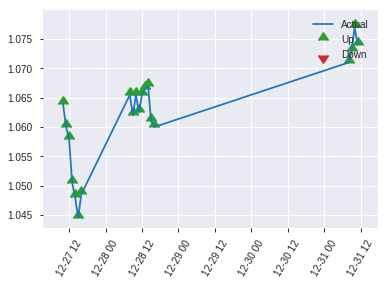


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.26087249525645684
RMSE: 0.5107567867943185
LogLoss: 0.7200613900097439
Mean Per-Class Error: 0.43441830486625843
AUC: 0.5484208830164357
pr_auc: 0.5453544459675148
Gini: 0.09684176603287131
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2527749836444855: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    105  0.9813   (105.0/107.0)
1      0    116  0        (0.0/116.0)
Total  2    221  0.4709   (105.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.252775     0.688427  220
max f2                       0.252775     0.846715  220
max f0point5                 0.376899     0.590596  188
max accuracy                 0.541058     0.565022  108
max precision                0.780695     0.666667  11
max recall                   0.252775     1         220
max specificity              0.846932     0.990654  0
max absolute_mcc             0.541058     0.131089  108
max min_per_class_accuracy   0.541058     0.551724  108
max mean_per_class_accuracy  0.541058     0.565582  108

Gains/Lift Table: Avg response rate: 52.02 %, avg score: 54.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.819372           0.640805  0.640805           0.333333         0.835312  0.333333                    0.835312            0.00862069      0.00862069                 -35.9195  -35.9195
    2        0.0224215                   0.807163           0         0.384483           0                0.81171   0.2                         0.825872            0               0.00862069                 -100      -61.5517
    3        0.0313901                   0.800031           1.92241   0.823892           1                0.804061  0.428571                    0.81964             0.0172414       0.0258621                  92.2414   -17.6108
    4        0.0403587                   0.789326           1.92241   1.06801            1                0.794753  0.555556                    0.814109            0.0172414       0.0431034                  92.2414   6.80077
    5        0.0538117                   0.780484           1.92241   1.28161            1                0.784342  0.666667                    0.806668            0.0258621       0.0689655                  92.2414   28.1609
    6        0.103139                    0.743395           0.69906   1.003              0.363636         0.761827  0.521739                    0.785222            0.0344828       0.103448                   -30.094   0.29985
    7        0.152466                    0.728745           1.22335   1.07429            0.636364         0.735948  0.558824                    0.769281            0.0603448       0.163793                   22.3354   7.42901
    8        0.201794                    0.709375           0.69906   0.982567           0.363636         0.717032  0.511111                    0.756509            0.0344828       0.198276                   -30.094   -1.7433
    9        0.300448                    0.627458           1.31074   1.09032            0.681818         0.668798  0.567164                    0.727708            0.12931         0.327586                   31.0737   9.03242
    10       0.399103                    0.58227            1.13597   1.10161            0.590909         0.602744  0.573034                    0.696818            0.112069        0.439655                   13.5972   10.1608
    11       0.502242                    0.539118           1.08658   1.09852            0.565217         0.558172  0.571429                    0.668346            0.112069        0.551724                   8.65817   9.85222
    12       0.600897                    0.493512           0.786442  1.04729            0.409091         0.518489  0.544776                    0.643743            0.0775862       0.62931                    -21.3558  4.72851
    13       0.699552                    0.449442           0.873824  1.02282            0.454545         0.472553  0.532051                    0.619601            0.0862069       0.715517                   -12.6176  2.28227
    14       0.798206                    0.402234           1.13597   1.03681            0.590909         0.426601  0.539326                    0.595747            0.112069        0.827586                   13.5972   3.68074
    15       0.896861                    0.345564           0.873824  1.01888            0.454545         0.375193  0.53                        0.571486            0.0862069       0.913793                   -12.6176  1.88793
    16       1                           0.236605           0.835832  1                  0.434783         0.299137  0.520179                    0.543396      

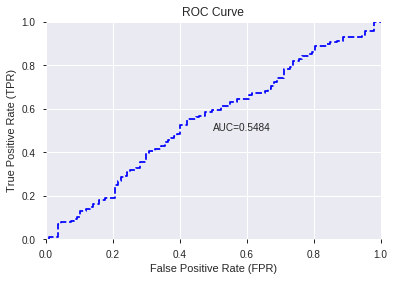

This function is available for GLM models only


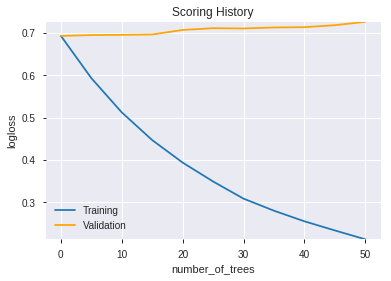

--2019-08-27 15:09:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.88.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.88.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.ge

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_150913_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_150913_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_bac4',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BBANDS_upperband_14_0_2',
 'HT_PHASOR_quadrature',
 'CCI_8',
 'BETA_8',
 'MFI_8',
 'STOCHRSI_fastd',
 'HT_DCPERIOD',
 'STOCH_slowd',
 'TRANGE',
 'ADXR_8',
 'BETA_12',
 'CCI_12',
 'ADX_8',
 'ADOSC',
 'ULTOSC',
 'HT_PHASOR_inphase',
 'CORREL_20',
 'STOCH_slowk',
 'WILLR_8',
 'MFI_12',
 'DX_30',
 'OBV',
 'ADXR_12',
 'STOCHF_fastk',
 'BETA_14',
 'PLUS_DM_8',
 'MFI_20',
 'MINUS_DI_8',
 'ADXR_14',
 'MFI_14',
 'CMO_8',
 'BBANDS_upperband_14_0_3',
 'ROCP_24',
 'DX_14',
 'STDDEV_8',
 'AD',
 'LINEARREG_ANGLE_12',
 'BBANDS_middleband_14_0_2',
 'BETA_20',
 'MACDFIX_8',
 'DX_12',
 'ATR_8',
 'STOCHRSI_fastk',
 'ADX_12',
 'CCI_20',
 'MACDFIX_hist_8',
 'BBANDS_lowerband_14_0_2',
 'MFI_24',
 'DX_20',
 'WILLR_24',
 'aroondown_8',
 'NATR_8',
 'PLUS_DI_8',
 'MINUS_DM_8',
 'AROONOSC_8',
 'PLUS_DM_12',
 'MOM_20',
 'LINEARREG_ANGLE_8',
 'MOM_30',
 'CORREL_14',
 'MOM_12',
 'MACDFIX_hist_14',
 'STDDEV_12',
 'TRIX_8',
 'ROC_12',
 'WILLR_12',
 'ADX_14',
 'CORREL_12',
 'BBANDS_lowerband_14_0_3',
 'PLUS_DM_30',


In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.578
GLM             0.552
XGBoost         0.578
dtype: float64

DeepLearning    GLM  XGBoost
All          0.565  0.525    0.552
DLF          0.574  0.538    0.578
Fwe          0.578  0.525    0.552
RFE          0.561  0.552    0.565
XGBF         0.574  0.538    0.578





F1


DeepLearning    0.702
GLM             0.688
XGBoost         0.688
dtype: float64

DeepLearning    GLM  XGBoost
All          0.693  0.684    0.684
DLF          0.702  0.684    0.684
Fwe          0.686  0.684    0.684
RFE          0.684  0.688    0.688
XGBF         0.686  0.684    0.684





auc


DeepLearning    0.568
GLM             0.539
XGBoost         0.570
dtype: float64

DeepLearning    GLM  XGBoost
All          0.568  0.507    0.550
DLF          0.551  0.527    0.570
Fwe          0.567  0.507    0.550
RFE          0.560  0.539    0.548
XGBF         0.549  0.527    0.570





logloss


DeepLearning    3.475
GLM             0.705
XGBoost         0.720
dtype: float64

DeepLearning    GLM  XGBoost
All          0.691  0.705    0.699
DLF          0.687  0.697    0.694
Fwe          3.475  0.705    0.699
RFE          0.690  0.695    0.720
XGBF         0.970  0.697    0.694





mean_per_class_error


DeepLearning    0.438
GLM             0.469
XGBoost         0.435
dtype: float64

DeepLearning    GLM  XGBoost
All          0.433  0.469    0.435
DLF          0.437  0.461    0.418
Fwe          0.414  0.469    0.435
RFE          0.438  0.447    0.434
XGBF         0.416  0.461    0.418





rmse


DeepLearning    0.650
GLM             0.505
XGBoost         0.511
dtype: float64

DeepLearning    GLM  XGBoost
All          0.499  0.505    0.503
DLF          0.497  0.502    0.500
Fwe          0.650  0.505    0.503
RFE          0.499  0.501    0.511
XGBF         0.561  0.502    0.500





mse


DeepLearning    0.423
GLM             0.255
XGBoost         0.261
dtype: float64

DeepLearning    GLM  XGBoost
All          0.249  0.255    0.253
DLF          0.247  0.252    0.250
Fwe          0.423  0.255    0.253
RFE          0.249  0.251    0.261
XGBF         0.314  0.252    0.250

{'F1':       DeepLearning    GLM  XGBoost
 All          0.693    NaN      NaN
 DLF          0.702    NaN      NaN
 DLF            NaN  0.684      NaN
 DLF            NaN    NaN    0.684
 All            NaN  0.684      NaN
 All            NaN    NaN    0.684
 XGBF         0.686    NaN      NaN
 XGBF           NaN  0.684      NaN
 XGBF           NaN    NaN    0.684
 Fwe          0.686    NaN      NaN
 Fwe            NaN  0.684      NaN
 Fwe            NaN    NaN    0.684
 RFE          0.684    NaN      NaN
 RFE            NaN  0.688      NaN
 RFE            NaN    NaN    0.688,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.565    NaN      NaN
 DLF          0.574    NaN      NaN
 DLF            NaN  0.538      NaN
 DLF            NaN    NaN    0.578
 All            NaN  0.525      NaN
 All            NaN    NaN    0.552
 XGBF         0.574    NaN      NaN
 XGBF           NaN  0.538      NaN
 XGBF           NaN    NaN    0.578
 Fwe          0.578    NaN      NaN
 Fwe     